<a href="https://colab.research.google.com/github/juanpazmino/DSMarket/blob/main/1121_SupML_%7BJuan_Pazmino%7D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ****Malware Prediction Ejercicio****

# CANVAS

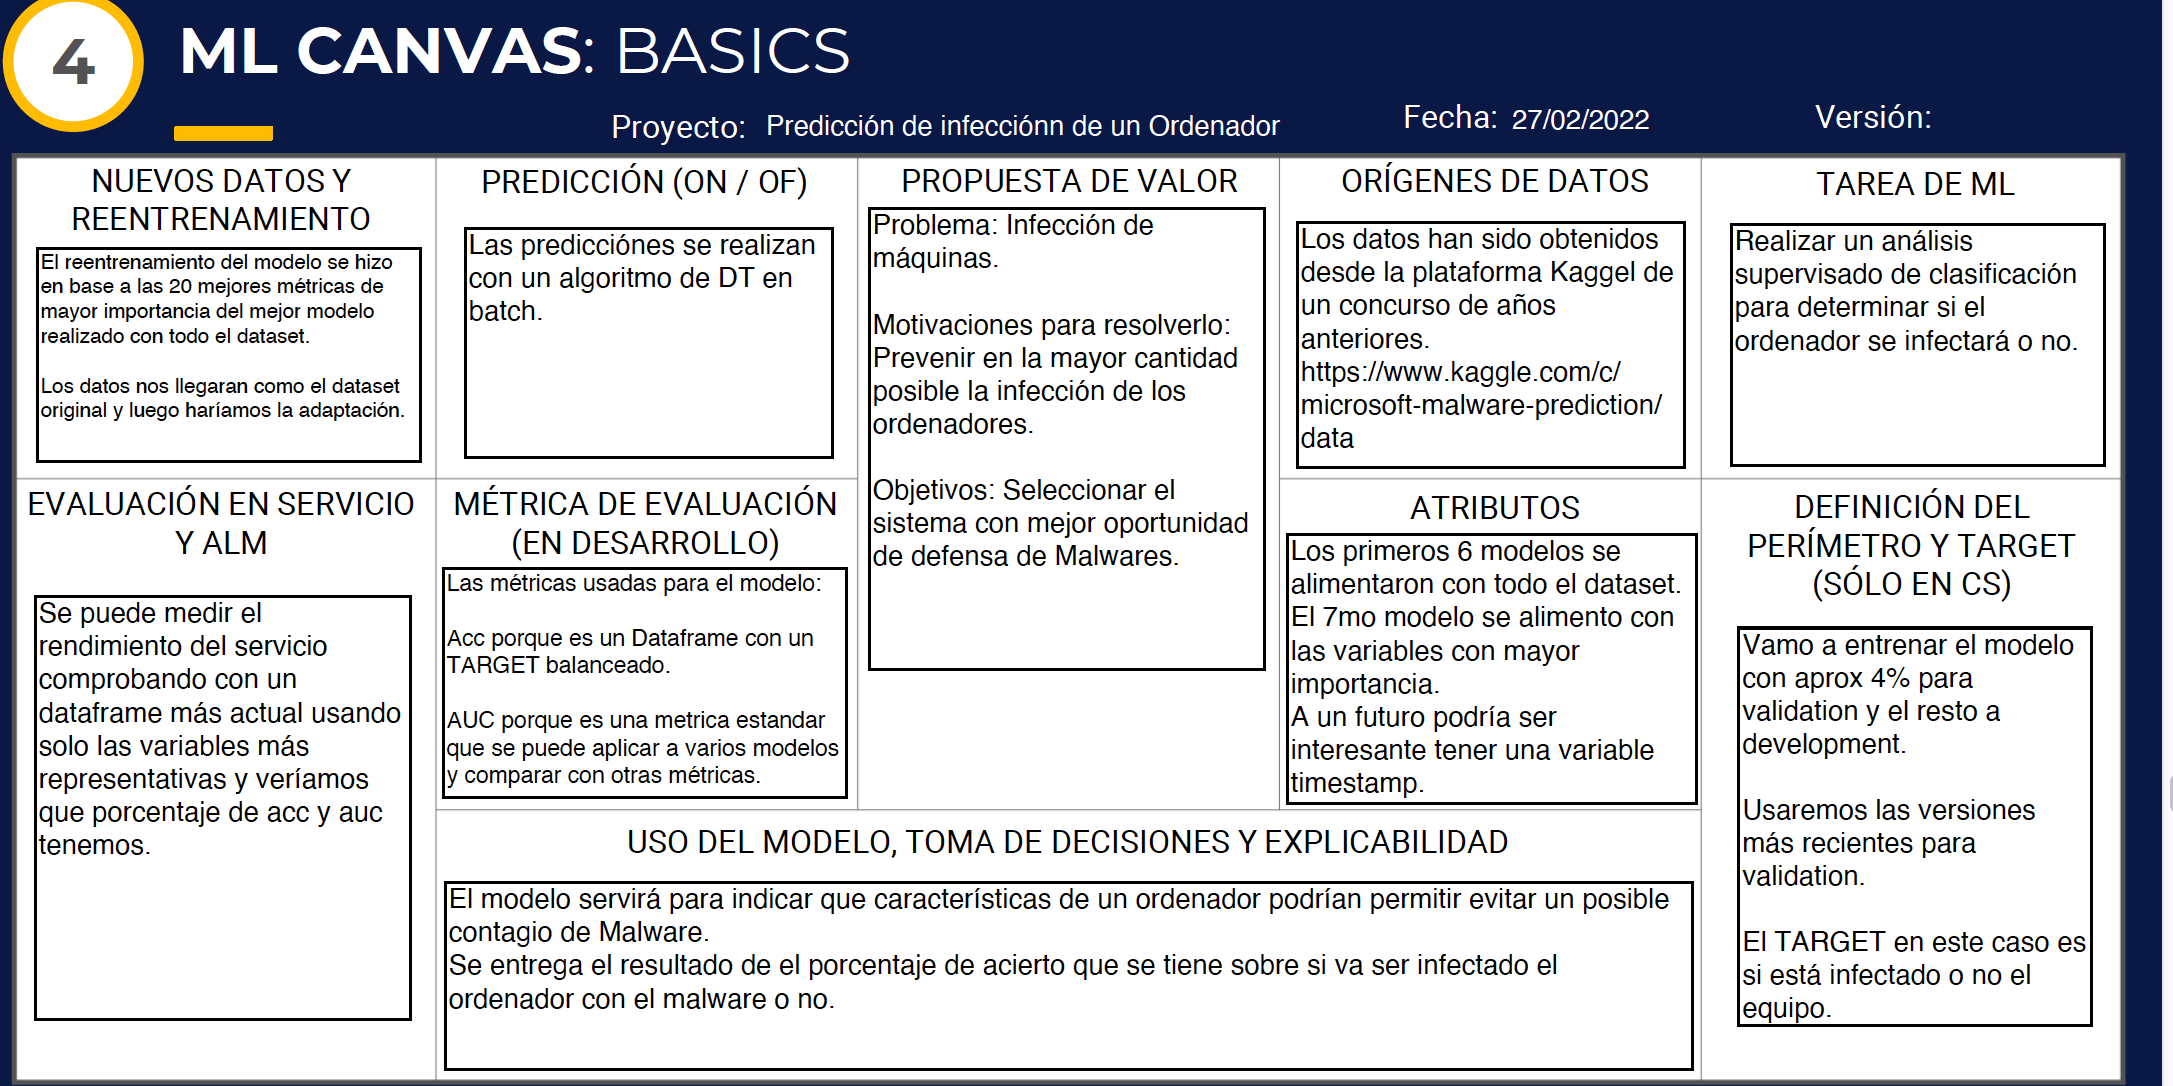

#Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

#check matplolib styles

In [ ]:
from scipy import stats
from datetime import datetime

from sklearn import model_selection
import xgboost as xgb
import lightgbm as lgb 
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn import preprocessing

###Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML_ejercicio/sample_mmp.csv', index_col=0)

#EDA


##2.1 MLC Tamaño del DataSet

In [ ]:
df.shape

(500000, 83)

In [ ]:
df.info(verbose= False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 8427007 to 4295573
Columns: 83 entries, MachineIdentifier to HasDetections
dtypes: float64(36), int64(17), object(30)
memory usage: 320.4+ MB


##2.2 MLC Visualización de Datos

In [ ]:
df.head()

MachineIdentifier  ... HasDetections
8427007  f1cd864e97bae82bdf96523e1a539121  ...             1
8829090  fd5ba6f5b75325ec0423a6c67cc75942  ...             0
2731904  4e628391e7cc7c482fb3286f486dbd25  ...             0
1359513  270a2e9d028144a4df12a9e3da79fba5  ...             1
236059   06ca8fa8d32c2abdc5b3577d676b3269  ...             1

[5 rows x 83 columns]

In [ ]:
df.tail()

MachineIdentifier  ... HasDetections
5826339  a739cacc292f3f1e745827c1ca6c6ada  ...             0
5740034  a4c232d528d98343e8f1b73650da7b82  ...             0
8819786  fd16cd542d660848d272e4552bcccb1e  ...             0
8713685  fa0841f8f6147de7c3d287e05270ed42  ...             0
4295573  7b45dc3537e17f16305c5983ca0a1cb9  ...             1

[5 rows x 83 columns]

## 2.3 MLC Tipos de Atributos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 8427007 to 4295573
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  500000 non-null  object 
 1   ProductName                                        500000 non-null  object 
 2   EngineVersion                                      500000 non-null  object 
 3   AppVersion                                         500000 non-null  object 
 4   AvSigVersion                                       500000 non-null  object 
 5   IsBeta                                             500000 non-null  int64  
 6   RtpStateBitfield                                   498168 non-null  float64
 7   IsSxsPassiveMode                                   500000 non-null  int64  
 8   DefaultBrowsersIdentifier                          24061 non-null  

##2.4-2.5. MLC Analizamos variables Categoricas, Numéricas y Nulos**

In [ ]:
def cat_numer_clasif(dataframe):

  styles = [dict(selector="caption", props=[("text-align", "left"),
                                            ("font-size", "120%"),
                                          ("font-weight", "bold")])]

  num_results= dataframe.describe(include= np.number).T.style.set_caption('Variables Numericas').set_table_styles(styles)
  cat_results=dataframe.describe(exclude= np.number).T.style.set_caption('Variables Categoricas').set_table_styles(styles)

  num_results_null=dataframe.select_dtypes(include = np.number).isnull().sum()
  cat_results_null=dataframe.select_dtypes(exclude = np.number).isnull().sum()

  return display(num_results, num_results_null, cat_results, cat_results_null)

In [ ]:
cat_numer_clasif(df)

IsBeta                                                    0
RtpStateBitfield                                       1832
IsSxsPassiveMode                                          0
DefaultBrowsersIdentifier                            475939
AVProductStatesIdentifier                              1938
AVProductsInstalled                                    1938
AVProductsEnabled                                      1938
HasTpm                                                    0
CountryIdentifier                                         0
CityIdentifier                                        18240
OrganizationIdentifier                               154563
GeoNameIdentifier                                        16
LocaleEnglishNameIdentifier                               0
OsBuild                                                   0
OsSuite                                                   0
IsProtected                                            1926
AutoSampleOptIn                         

MachineIdentifier                        0
ProductName                              0
EngineVersion                            0
AppVersion                               0
AvSigVersion                             0
Platform                                 0
Processor                                0
OsVer                                    0
OsPlatformSubRelease                     0
OsBuildLab                               1
SkuEdition                               0
PuaMode                             499874
SmartScreen                         178596
Census_MDC2FormFactor                    0
Census_DeviceFamily                      0
Census_ProcessorClass               497918
Census_PrimaryDiskTypeName             709
Census_ChassisTypeName                  37
Census_PowerPlatformRoleName             2
Census_InternalBatteryType          355603
Census_OSVersion                         0
Census_OSArchitecture                    0
Census_OSBranch                          0
Census_OSEd

####Verifico que no existan duplicados

In [ ]:
df.duplicated(keep=False).sum()

0

###Contamos las variables numéricas y categóricas

In [ ]:
len(df.describe(include= np.number).T)

53

In [ ]:
len(df.describe(exclude= np.number).T)

30

## 2.6. MLC Distribución del TARGET

In [ ]:
TARGET = 'HasDetections'

In [ ]:
df[TARGET].sum()

249953

In [ ]:
df[TARGET].isnull().sum()

0

In [ ]:
df[TARGET].value_counts()

0    250047
1    249953
Name: HasDetections, dtype: int64

In [ ]:
(df[TARGET]).mean()*100

49.9906

El TARGET esta bien balanceado, por lo que se puede tener una buena propuesta para el modelo de predicción.

#MLC 2.7-2.11 Data Understanding 

# Exportamos una tabla con toda la información a Excel de control


In [ ]:
df_types_col= df.dtypes

In [ ]:
df_description = df.describe(include = 'all').T

In [ ]:
df_info= pd.concat([df_types_col, df_description], axis=1)

In [ ]:
df_info.head(10)

0     count  unique  ...      50%      75%      max
MachineIdentifier           object    500000  500000  ...      NaN      NaN      NaN
ProductName                 object    500000       3  ...      NaN      NaN      NaN
EngineVersion               object    500000      53  ...      NaN      NaN      NaN
AppVersion                  object    500000      95  ...      NaN      NaN      NaN
AvSigVersion                object    500000    6455  ...      NaN      NaN      NaN
IsBeta                       int64  500000.0     NaN  ...      0.0      0.0      1.0
RtpStateBitfield           float64  498168.0     NaN  ...      7.0      7.0     35.0
IsSxsPassiveMode             int64  500000.0     NaN  ...      0.0      0.0      1.0
DefaultBrowsersIdentifier  float64   24061.0     NaN  ...   1632.0   2381.0   3209.0
AVProductStatesIdentifier  float64  498062.0     NaN  ...  53447.0  53447.0  70492.0

[10 rows x 12 columns]

Exporto la tabla a excel para poder llevar un control de que se ha realizado.

In [ ]:
#from google.colab import files
#df_info.to_excel('df_col_names_types.xlsx')
#files.download('df_col_names_types.xlsx')

###Vamos a visualizar la correlación que hay entre variables numéricas.

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

#Copia del df orginal para trabajarlo

In [ ]:
df_clean= df.copy()

In [ ]:
df['PuaMode'].value_counts()

on    126
Name: PuaMode, dtype: int64

#Funcion para ver graficamente la relación

In [ ]:
def graf_corr(dataframe):
  return dataframe.corr().style.background_gradient(cmap='coolwarm')

In [ ]:
graf_corr(df_clean)

# 3 MLC Data Preparation

# Variables Numéricas

##Limpieza de datos 

##### NO existe ninguna relación con la variable Census_IsWIMBootEnabled, por lo tanto vamos a eliminarla.

In [ ]:
df_clean.drop('Census_IsWIMBootEnabled', axis = 1, inplace= True)

##IsBeta

In [ ]:
df_clean['IsBeta'].describe()

count    500000.000000
mean          0.000002
std           0.001414
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: IsBeta, dtype: float64

In [ ]:
df_clean['IsBeta'].value_counts()

0    499999
1         1
Name: IsBeta, dtype: int64

In [ ]:
df_clean[[TARGET,'IsBeta']].corr()

HasDetections    IsBeta
HasDetections       1.000000 -0.001414
IsBeta             -0.001414  1.000000

Al ser una muestra desbalanceada, no la tomaremos en cuenta en el modelo.

In [ ]:
df_clean.drop('IsBeta', axis=1, inplace= True)

## RtpStateBitfield

In [ ]:
df_clean['RtpStateBitfield'].value_counts(dropna= False)

7.0     484841
0.0      10610
NaN       1832
8.0       1277
5.0       1158
3.0        176
1.0        105
35.0         1
Name: RtpStateBitfield, dtype: int64

In [ ]:
df_clean['RtpStateBitfield'].describe()

count    498168.000000
mean          6.846207
std           1.023049
min           0.000000
25%           7.000000
50%           7.000000
75%           7.000000
max          35.000000
Name: RtpStateBitfield, dtype: float64

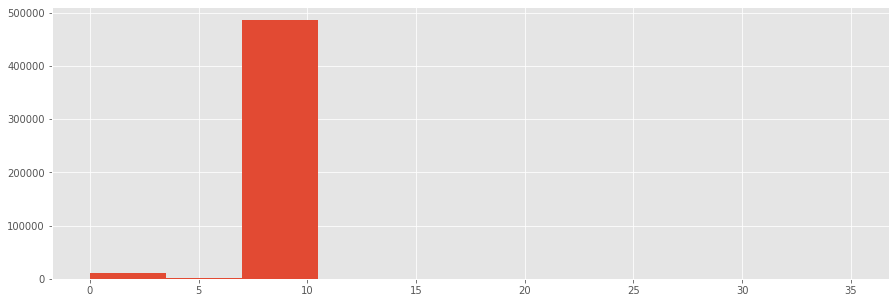

In [ ]:
plt.figure(figsize= (15,5))

df_clean['RtpStateBitfield'].hist()

In [ ]:
df_clean['RtpStateBitfield'].median()

7.0

In [ ]:
df_clean['RtpStateBitfield'].mean()

6.8462065006182655

In [ ]:
df_clean['RtpStateBitfield'].mode()

0    7.0
dtype: float64

In [ ]:
df_clean['RtpStateBitfield'].fillna(-1, inplace=True)

In [ ]:
df_clean['RtpStateBitfield'].describe()

count    500000.000000
mean          6.817458
std           1.125849
min          -1.000000
25%           7.000000
50%           7.000000
75%           7.000000
max          35.000000
Name: RtpStateBitfield, dtype: float64

In [ ]:
df_clean[(df_clean['RtpStateBitfield']>=7 )& (df_clean['RtpStateBitfield']<10)].describe()

RtpStateBitfield  IsSxsPassiveMode  ...  Wdft_RegionIdentifier  HasDetections
count     486118.000000          486118.0  ...          469638.000000  486118.000000
mean           7.002627               0.0  ...               7.887126       0.503649
std            0.051186               0.0  ...               4.556162       0.499987
min            7.000000               0.0  ...               1.000000       0.000000
25%            7.000000               0.0  ...               3.000000       0.000000
50%            7.000000               0.0  ...              10.000000       1.000000
75%            7.000000               0.0  ...              11.000000       1.000000
max            8.000000               0.0  ...              15.000000       1.000000

[8 rows x 51 columns]

Conclusión: Como no se va a usar un algoritmo de regresión lineal, no importa que hayan outliers, ya que su comportamiento no afectará drásticamente, por ello no se ha 'normalizado' la escala.

In [ ]:
df_clean[[TARGET,'RtpStateBitfield']].corr()

HasDetections  RtpStateBitfield
HasDetections          1.000000          0.039216
RtpStateBitfield       0.039216          1.000000

## Creamos una función para describir las variables numéricas, y su relación con el TARGET

In [ ]:
def descrp_num(dataframe, col_name, Target):

  val_counts = pd.DataFrame(dataframe[col_name].value_counts(dropna= False))
  describe_ = pd.DataFrame(dataframe[col_name].describe())
  nulos = dataframe[col_name].isnull().sum()

  plt.figure(figsize= (15,5))
  dataframe[col_name].hist()

  corr_= dataframe[[Target,col_name]].corr()

  return display('VALUE COUNTS',val_counts,'NULOS', nulos, 'DESCRIBE',describe_, 'CORR',corr_ )
                                                                                    

'VALUE COUNTS'

RtpStateBitfield
 7.0             484841
 0.0              10610
-1.0               1832
 8.0               1277
 5.0               1158
 3.0                176
 1.0                105
 35.0                 1

'NULOS'

0

'DESCRIBE'

RtpStateBitfield
count     500000.000000
mean           6.817458
std            1.125849
min           -1.000000
25%            7.000000
50%            7.000000
75%            7.000000
max           35.000000

'CORR'

HasDetections  RtpStateBitfield
HasDetections          1.000000          0.039216
RtpStateBitfield       0.039216          1.000000

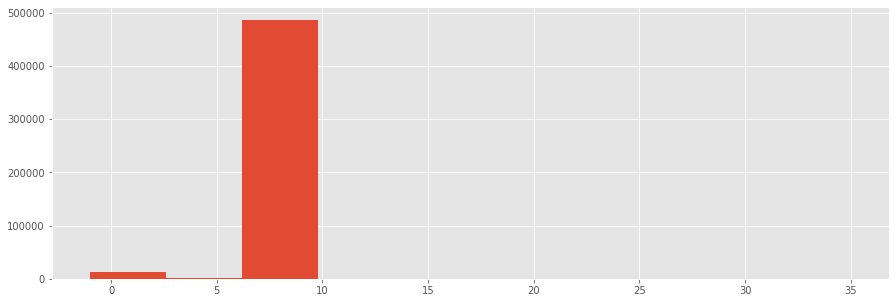

In [ ]:
descrp_num(df_clean,'RtpStateBitfield', TARGET) #Funciona correctamente

## IsSxsPassiveMode

'VALUE COUNTS'

IsSxsPassiveMode
0            491379
1              8621

'NULOS'

0

'DESCRIBE'

IsSxsPassiveMode
count     500000.000000
mean           0.017242
std            0.130172
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000

'CORR'

HasDetections  IsSxsPassiveMode
HasDetections          1.000000         -0.034038
IsSxsPassiveMode      -0.034038          1.000000

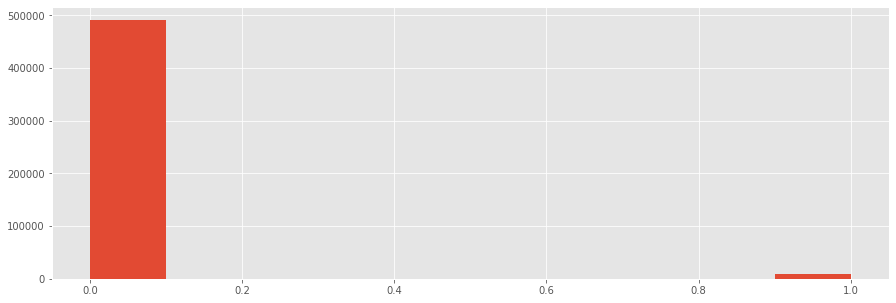

In [ ]:
descrp_num(df_clean, 'IsSxsPassiveMode',TARGET)

Similiar a 'IsBeta' en su distribución y la correlación con el TARGET es baja, por lo tanto la eliminaremos.

In [ ]:
df_clean.drop('IsSxsPassiveMode', axis=1, inplace= True)

## DefaultBrowsersIdentifier

In [ ]:
graf_corr(df_clean)

'VALUE COUNTS'

DefaultBrowsersIdentifier
NaN                        475939
239.0                        2589
3195.0                       2423
1632.0                       1601
3176.0                       1313
...                           ...
1692.0                          1
2722.0                          1
914.0                           1
1648.0                          1
1427.0                          1

[555 rows x 1 columns]

'NULOS'

475939

'DESCRIBE'

DefaultBrowsersIdentifier
count               24061.000000
mean                 1652.824529
std                  1004.754276
min                     1.000000
25%                   788.000000
50%                  1632.000000
75%                  2381.000000
max                  3209.000000

'CORR'

HasDetections  DefaultBrowsersIdentifier
HasDetections                   1.000000                   0.000956
DefaultBrowsersIdentifier       0.000956                   1.000000

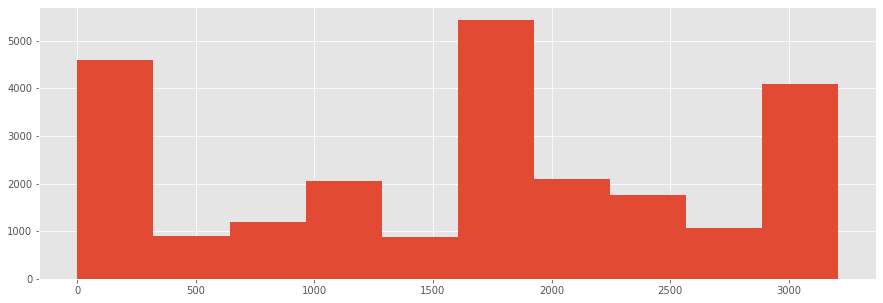

In [ ]:
descrp_num(df_clean, 'DefaultBrowsersIdentifier',TARGET)

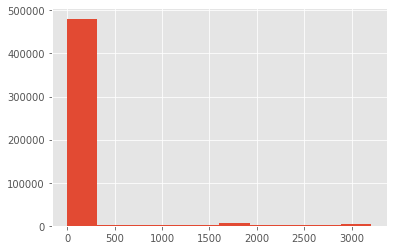

In [ ]:
df_clean['DefaultBrowsersIdentifier'].fillna(-1).hist()

Al no tener una correlación grande y tener tan desbalanceado los datos, y no tener relación con otras variables como "SMode", "Census_IsFlightsDisabled", la borramos

In [ ]:
df_clean.drop('DefaultBrowsersIdentifier',axis=1, inplace = True)

## AVProductStatesIdentifier

'VALUE COUNTS'

AVProductStatesIdentifier
53447.0                     326463
7945.0                       26642
47238.0                      18436
62773.0                      14931
46413.0                       6343
...                            ...
2451.0                           1
19604.0                          1
3193.0                           1
26492.0                          1
18324.0                          1

[5517 rows x 1 columns]

'NULOS'

1938

'DESCRIBE'

AVProductStatesIdentifier
count              498062.000000
mean                47850.908413
std                 14023.085346
min                     3.000000
25%                 49480.000000
50%                 53447.000000
75%                 53447.000000
max                 70492.000000

'CORR'

HasDetections  AVProductStatesIdentifier
HasDetections                   1.000000                   0.116163
AVProductStatesIdentifier       0.116163                   1.000000

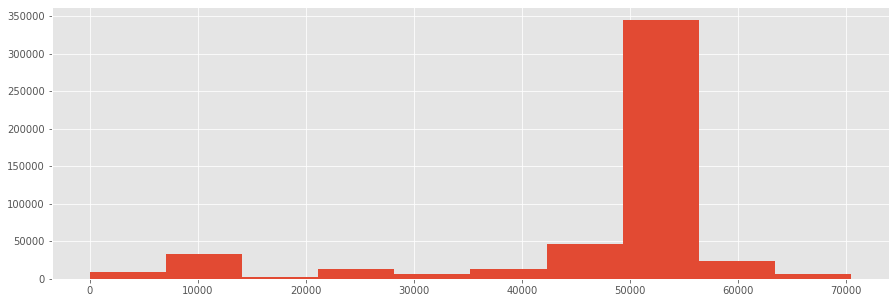

In [ ]:
descrp_num(df_clean, 'AVProductStatesIdentifier', TARGET)

In [ ]:
df_clean['AVProductStatesIdentifier'].min()

3.0

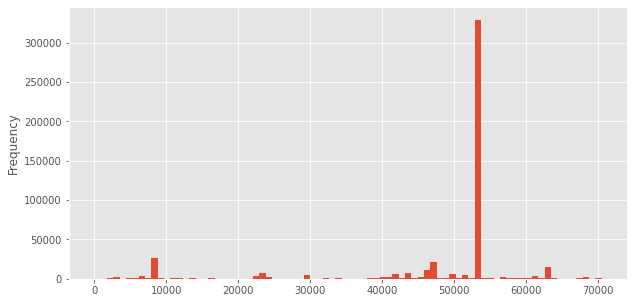

In [ ]:
plt.figure(figsize=(10,5))
df_clean['AVProductStatesIdentifier'].plot(kind='hist', bins=80)

Al tener un valor mínimo 3.0, vamos a llenar los nulos con un valor extremo.

In [ ]:
df_clean['AVProductStatesIdentifier'].fillna(-1, inplace=True)

## AVProductsInstalled

'VALUE COUNTS'

AVProductsInstalled
1.0               348046
2.0               137856
3.0                11617
NaN                 1938
4.0                  514
5.0                   29

'NULOS'

1938

'DESCRIBE'

AVProductsInstalled
count        498062.000000
mean              1.326763
std               0.523000
min               1.000000
25%               1.000000
50%               1.000000
75%               2.000000
max               5.000000

'CORR'

HasDetections  AVProductsInstalled
HasDetections             1.000000            -0.148761
AVProductsInstalled      -0.148761             1.000000

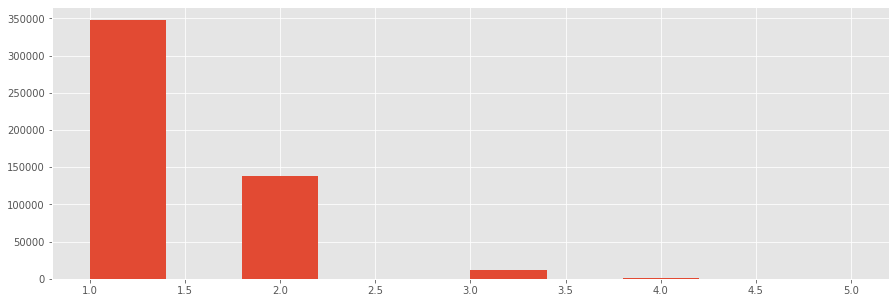

In [ ]:
descrp_num(df_clean, 'AVProductsInstalled', TARGET)

### Corregimos los valores nulos con valor extremo

In [ ]:
df_clean['AVProductsInstalled'].fillna(-1, inplace= True)

## AVProductsEnabled

'VALUE COUNTS'

AVProductsEnabled
1.0             485179
2.0              11074
NaN               1938
0.0               1467
3.0                316
4.0                 26

'NULOS'

1938

'DESCRIBE'

AVProductsEnabled
count      498062.000000
mean            1.020714
std             0.166608
min             0.000000
25%             1.000000
50%             1.000000
75%             1.000000
max             4.000000

'CORR'

HasDetections  AVProductsEnabled
HasDetections           1.000000          -0.041943
AVProductsEnabled      -0.041943           1.000000

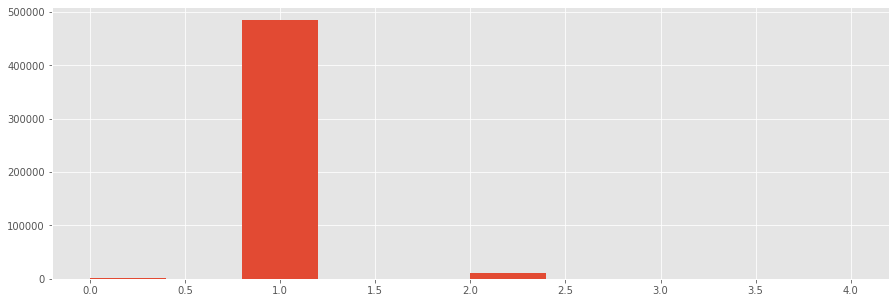

In [ ]:
descrp_num(df_clean, 'AVProductsEnabled', TARGET)

### Variable desbalanceada, no se usará. Eliminar.

In [ ]:
df_clean.drop('AVProductsEnabled',axis=1, inplace = True)

## HasTpm

'VALUE COUNTS'

HasTpm
1  493908
0    6092

'NULOS'

0

'DESCRIBE'

HasTpm
count  500000.000000
mean        0.987816
std         0.109707
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000

'CORR'

HasDetections    HasTpm
HasDetections       1.000000  0.007198
HasTpm              0.007198  1.000000

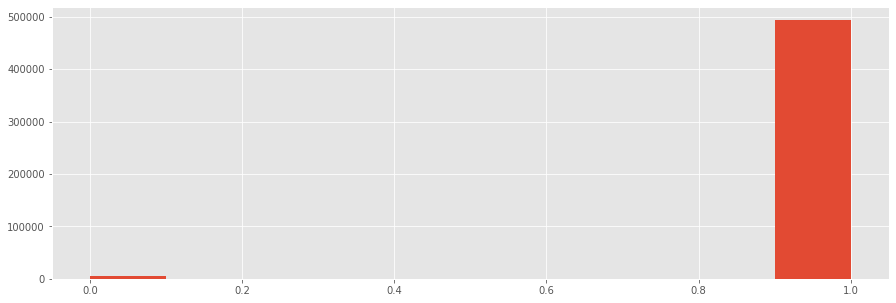

In [ ]:
descrp_num(df_clean,'HasTpm',TARGET)

### En este caso a pesar de estar desbalanceada la variable tiene un impacto sobre el TARGET que podría influir. La mantenemos.

## CountryIdentifier

'VALUE COUNTS'

CountryIdentifier
43               22339
29               19273
141              18420
93               16205
171              15743
..                 ...
212                 13
37                  12
165                 11
217                 10
193                  9

[222 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

CountryIdentifier
count      500000.000000
mean          108.037454
std            63.068540
min             1.000000
25%            51.000000
50%            97.000000
75%           162.000000
max           222.000000

'CORR'

HasDetections  CountryIdentifier
HasDetections           1.000000           0.006652
CountryIdentifier       0.006652           1.000000

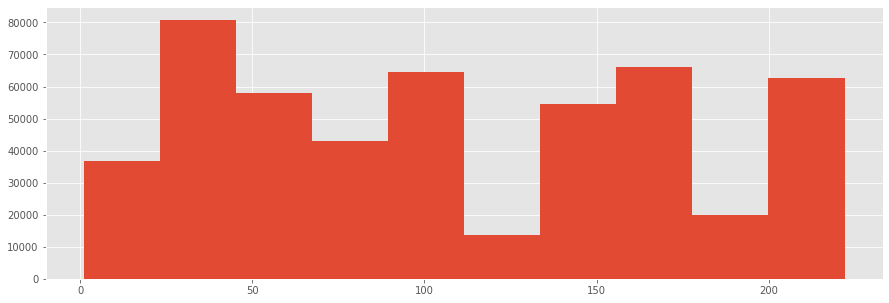

In [ ]:
descrp_num(df_clean, 'CountryIdentifier', TARGET)

### Buena distribución, mantenemos la variable.

## CityIdentifier

'VALUE COUNTS'

CityIdentifier
NaN                18240
130775.0            5271
16668.0             4747
82373.0             4649
10222.0             4011
...                  ...
151632.0               1
41727.0                1
83230.0                1
131294.0               1
148194.0               1

[37158 rows x 1 columns]

'NULOS'

18240

'DESCRIBE'

CityIdentifier
count   481760.000000
mean     81271.646027
std      48985.129677
min          7.000000
25%      36825.000000
50%      82373.000000
75%     123939.500000
max     167958.000000

'CORR'

HasDetections  CityIdentifier
HasDetections        1.000000       -0.004538
CityIdentifier      -0.004538        1.000000

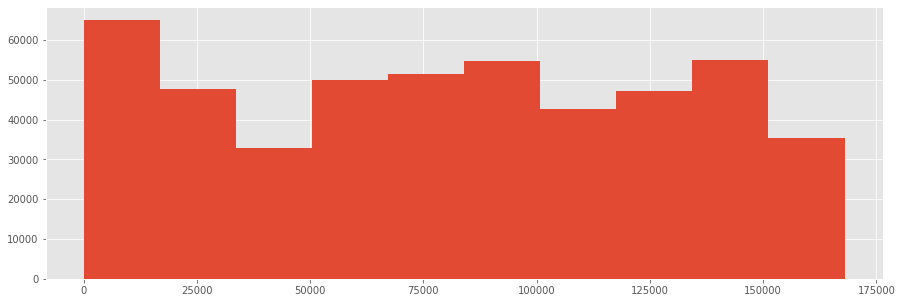

In [ ]:
descrp_num(df_clean, 'CityIdentifier', TARGET)

Trabajamos los nulos, siendo el mínimo 7, podemos usar -1.

In [ ]:
df_clean['CityIdentifier'].fillna(-1, inplace= True)

## OrganizationIdentifier

'VALUE COUNTS'

OrganizationIdentifier
27.0                  234885
NaN                   154563
18.0                   98842
48.0                    3658
50.0                    2538
37.0                    1048
11.0                    1037
49.0                     747
46.0                     641
14.0                     255
32.0                     230
36.0                     207
52.0                     174
33.0                     171
2.0                      153
5.0                      110
40.0                     100
28.0                      98
4.0                       79
10.0                      69
51.0                      53
1.0                       39
20.0                      38
8.0                       37
6.0                       25
31.0                      23
47.0                      22
39.0                      21
22.0                      21
3.0                       20
21.0                      19
16.0                      16
19.0                      10
29.0                       8
42.0                       8
7.0                        7
44.0                       6
26.0                       6
43.0                       4
45.0                       4
41.0                       2
35.0                       2
23.0                       2
25.0                       1
17.0                       1

'NULOS'

154563

'DESCRIBE'

OrganizationIdentifier
count           345437.000000
mean                24.869936
std                  5.613712
min                  1.000000
25%                 18.000000
50%                 27.000000
75%                 27.000000
max                 52.000000

'CORR'

HasDetections  OrganizationIdentifier
HasDetections                1.000000                0.005402
OrganizationIdentifier       0.005402                1.000000

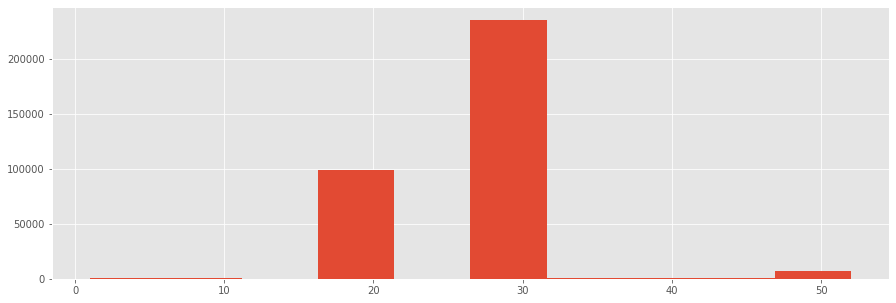

In [ ]:
descrp_num(df_clean, 'OrganizationIdentifier', TARGET)

In [ ]:
df_clean['OrganizationIdentifier'].fillna(-1,inplace=True)

Mantenemos la variable.

## GeoNameIdentifier

'VALUE COUNTS'

GeoNameIdentifier
277.0              86080
211.0              23593
53.0               22977
89.0               20174
240.0              19489
...                  ...
132.0                  1
280.0                  1
231.0                  1
113.0                  1
221.0                  1

[269 rows x 1 columns]

'NULOS'

16

'DESCRIBE'

GeoNameIdentifier
count      499984.000000
mean          169.730423
std            89.325172
min             1.000000
25%            89.000000
50%           181.000000
75%           267.000000
max           296.000000

'CORR'

HasDetections  GeoNameIdentifier
HasDetections           1.000000           0.003417
GeoNameIdentifier       0.003417           1.000000

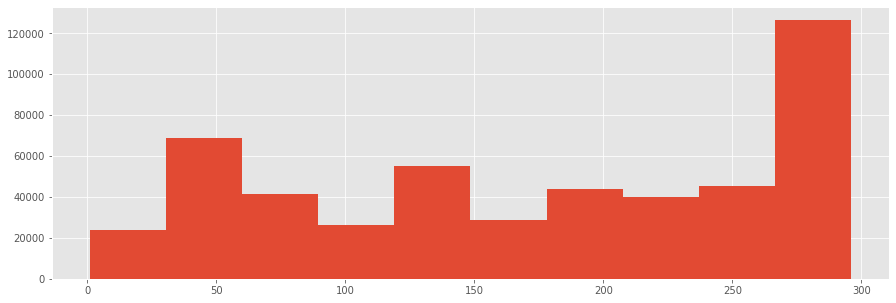

In [ ]:
descrp_num(df_clean, 'GeoNameIdentifier', TARGET)

In [ ]:
df_clean['GeoNameIdentifier'].fillna(-1, inplace= True)

Mantenemos la Variable

## LocaleEnglishNameIdentifier

'VALUE COUNTS'

LocaleEnglishNameIdentifier
75                        117818
182                        25187
42                         23007
74                         22894
88                         20988
..                           ...
152                            1
155                            1
165                            1
190                            1
127                            1

[233 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

LocaleEnglishNameIdentifier
count                500000.000000
mean                    122.610998
std                      69.303165
min                       1.000000
25%                      74.000000
50%                      88.000000
75%                     182.000000
max                     283.000000

'CORR'

HasDetections  LocaleEnglishNameIdentifier
HasDetections                     1.000000                     0.017019
LocaleEnglishNameIdentifier       0.017019                     1.000000

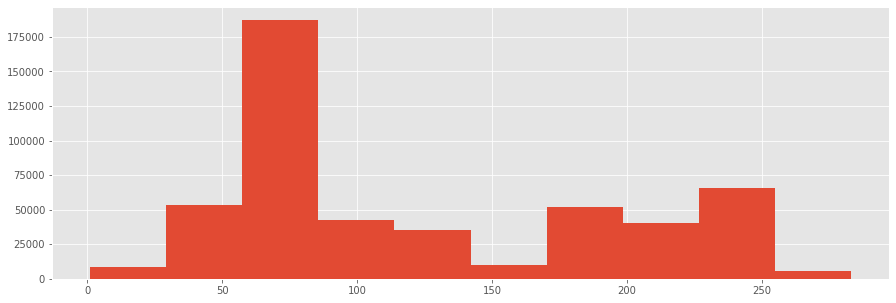

In [ ]:
descrp_num(df_clean, 'LocaleEnglishNameIdentifier', TARGET)

## OsSuite

'VALUE COUNTS'

OsSuite
768   311226
256   187951
272      677
16        53
400       47
305       33
784       10
274        2
18         1

'NULOS'

0

'DESCRIBE'

OsSuite
count  500000.000000
mean      574.718574
std       248.203346
min        16.000000
25%       256.000000
50%       768.000000
75%       768.000000
max       784.000000

'CORR'

HasDetections   OsSuite
HasDetections       1.000000 -0.019877
OsSuite            -0.019877  1.000000

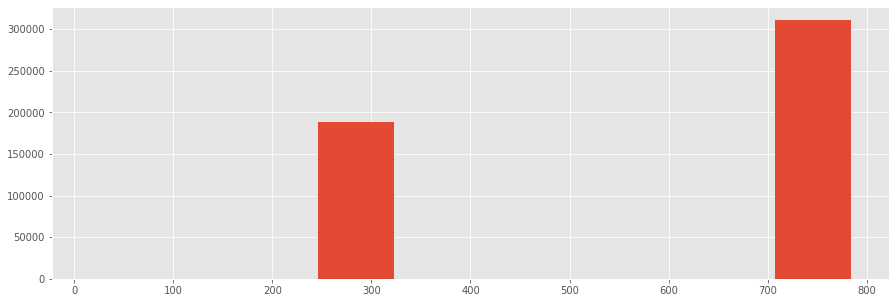

In [ ]:
descrp_num(df_clean, 'OsSuite', TARGET)

Variable no tan balanceada pero tiene valores que el modelo podría usarlos.

In [ ]:
df_clean[['OsBuildLab','OsBuild','Census_OSBuildNumber','Census_OSBuildRevision','Census_OSArchitecture','Census_OSBranch','OsPlatformSubRelease']].head(10)

OsBuildLab  ...  OsPlatformSubRelease
8427007           17134.1.amd64fre.rs4_release.180410-1804  ...                   rs4
8829090           17134.1.amd64fre.rs4_release.180410-1804  ...                   rs4
2731904    10586.1176.amd64fre.th2_release_sec.170913-1848  ...                   th2
1359513           17134.1.amd64fre.rs4_release.180410-1804  ...                   rs4
236059            17134.1.amd64fre.rs4_release.180410-1804  ...                   rs4
3771983  16299.431.amd64fre.rs3_release_svc_escrow.1805...  ...                   rs3
4833329             15063.0.x86fre.rs2_release.170317-1834  ...                   rs2
985557            15063.0.amd64fre.rs2_release.170317-1834  ...                   rs2
387390            17134.1.amd64fre.rs4_release.180410-1804  ...                   rs4
7131823             17134.1.x86fre.rs4_release.180410-1804  ...                   rs4

[10 rows x 7 columns]

## IsProtected

'VALUE COUNTS'

IsProtected
1.0       471073
0.0        27001
NaN         1926

'NULOS'

1926

'DESCRIBE'

IsProtected
count  498074.000000
mean        0.945789
std         0.226433
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000

'CORR'

HasDetections  IsProtected
HasDetections       1.000000     0.056203
IsProtected         0.056203     1.000000

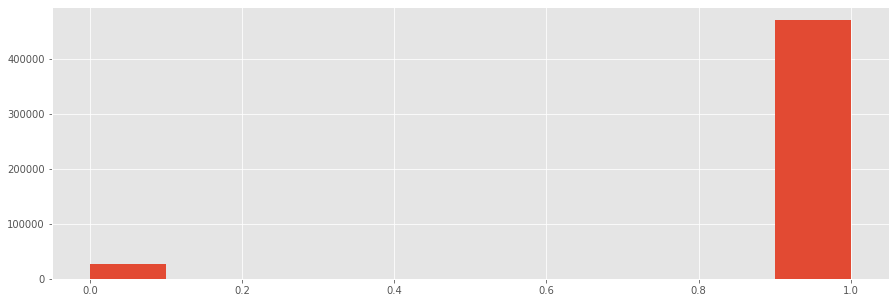

In [ ]:
descrp_num(df_clean, 'IsProtected', TARGET)

In [ ]:
df_clean['IsProtected'].fillna(0,inplace=True)

Mantenemos la variable, por su distribución y la descripción de la de Kaggle

## AutoSampleOptIn

'VALUE COUNTS'

AutoSampleOptIn
0           499986
1               14

'NULOS'

0

'DESCRIBE'

AutoSampleOptIn
count    500000.000000
mean          0.000028
std           0.005291
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000

'CORR'

HasDetections  AutoSampleOptIn
HasDetections     1.000000e+00     9.948164e-07
AutoSampleOptIn   9.948164e-07     1.000000e+00

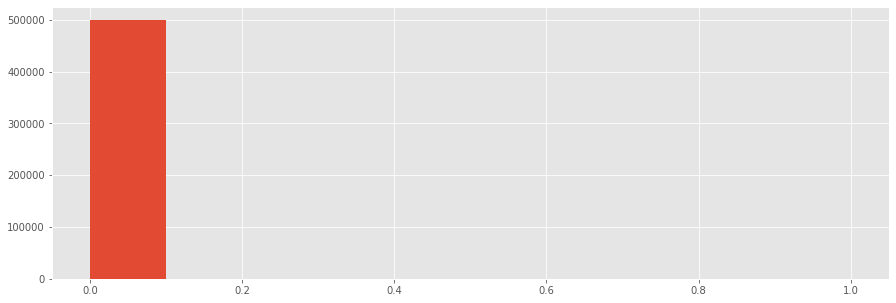

In [ ]:
descrp_num(df_clean, 'AutoSampleOptIn', TARGET)

Variable muy desbalanceada la eliminamos.


In [ ]:
df_clean.drop('AutoSampleOptIn', axis=1, inplace= True)

## SMode

'VALUE COUNTS'

SMode
0.0  469946
NaN   29848
1.0     206

'NULOS'

29848

'DESCRIBE'

SMode
count  470152.000000
mean        0.000438
std         0.020928
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

'CORR'

HasDetections     SMode
HasDetections       1.000000 -0.013631
SMode              -0.013631  1.000000

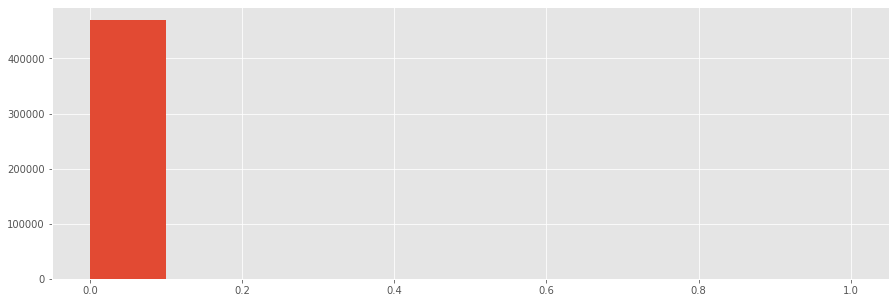

In [ ]:
descrp_num(df_clean, 'SMode', TARGET)

In [ ]:
df_clean['SMode'].fillna(-1, inplace= True)

## IeVerIdentifier

'VALUE COUNTS'

IeVerIdentifier
137.0           219142
117.0            98667
108.0            26353
111.0            26143
98.0             19731
...                ...
79.0                 1
15.0                 1
54.0                 1
192.0                1
281.0                1

[180 rows x 1 columns]

'NULOS'

3209

'DESCRIBE'

IeVerIdentifier
count    496791.000000
mean        126.662566
std          42.634892
min           8.000000
25%         111.000000
50%         135.000000
75%         137.000000
max         429.000000

'CORR'

HasDetections  IeVerIdentifier
HasDetections         1.000000         0.018316
IeVerIdentifier       0.018316         1.000000

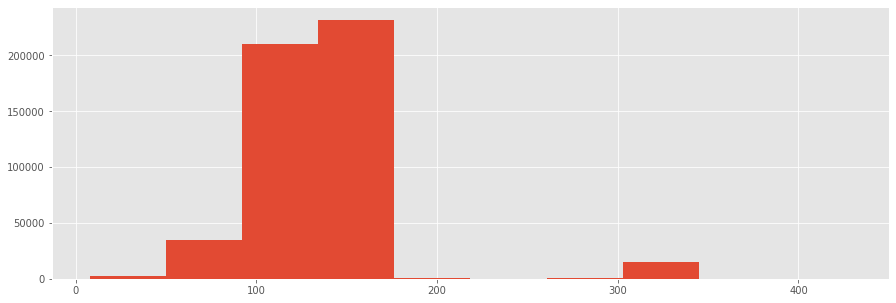

In [ ]:
descrp_num(df_clean, 'IeVerIdentifier', TARGET)

In [ ]:
df_clean['IeVerIdentifier'].fillna(-1, inplace= True)

Mantenemos la variable.

## Firewall

'VALUE COUNTS'

Firewall
1.0    484071
0.0     10767
NaN      5162

'NULOS'

5162

'DESCRIBE'

Firewall
count  494838.000000
mean        0.978241
std         0.145895
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000

'CORR'

HasDetections  Firewall
HasDetections       1.000000  0.002089
Firewall            0.002089  1.000000

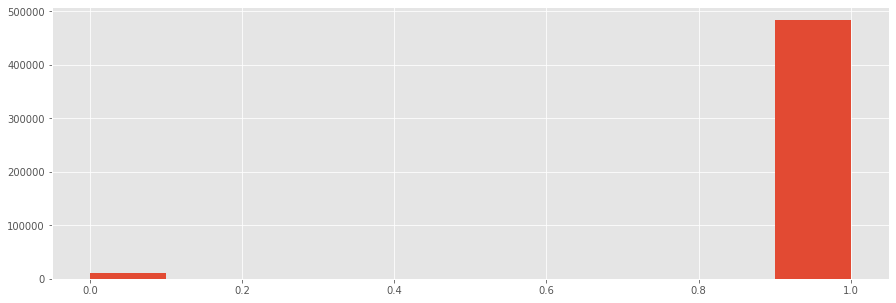

In [ ]:
descrp_num(df_clean, 'Firewall', TARGET)

In [ ]:
df_clean['Firewall'].fillna(-1, inplace= True)

Mantenemos la variable.

## UacLuaenable

'VALUE COUNTS'

UacLuaenable
1.0              496276
0.0                3086
NaN                 623
48.0                 13
2.0                   1
6357062.0             1

'NULOS'

623

'DESCRIBE'

UacLuaenable
count  4.993770e+05
mean   1.372503e+01
std    8.995848e+03
min    0.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    6.357062e+06

'CORR'

HasDetections  UacLuaenable
HasDetections       1.000000      0.001416
UacLuaenable        0.001416      1.000000

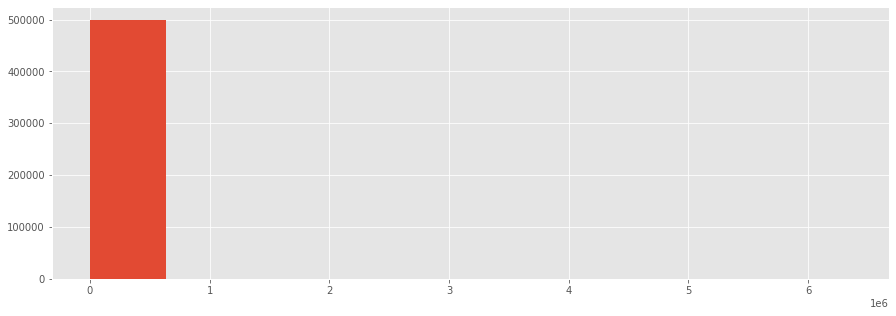

In [ ]:
descrp_num(df_clean, 'UacLuaenable', TARGET)

Variable desbalanceada, la descartamos.

In [ ]:
df_clean.drop('UacLuaenable', axis = 1,inplace = True)

## Census_OEMNameIdentifier

'VALUE COUNTS'

Census_OEMNameIdentifier
2668.0                     72011
2102.0                     57924
1443.0                     53210
2206.0                     51888
585.0                      50304
...                          ...
3997.0                         1
3546.0                         1
4037.0                         1
2429.0                         1
1900.0                         1

[1590 rows x 1 columns]

'NULOS'

5381

'DESCRIBE'

Census_OEMNameIdentifier
count             494619.000000
mean                2218.646481
std                 1315.709604
min                   54.000000
25%                 1443.000000
50%                 2102.000000
75%                 2668.000000
max                 6143.000000

'CORR'

HasDetections  Census_OEMNameIdentifier
HasDetections                  1.000000                 -0.015754
Census_OEMNameIdentifier      -0.015754                  1.000000

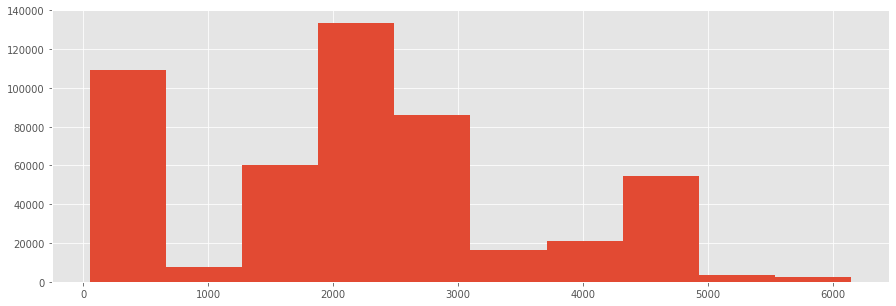

In [ ]:
descrp_num(df_clean, 'Census_OEMNameIdentifier', TARGET)

In [ ]:
df_clean['Census_OEMNameIdentifier'].fillna(-1, inplace= True)

Mantenemos la variable.

## **Comentario**: En las variable que empiezan con Census hay algunas que tienen correlación muy alta por eso usamos el cmap.

In [ ]:
graf_corr(df_clean)

## Census_OEMModelIdentifier

'VALUE COUNTS'

Census_OEMModelIdentifier
313586.0                      17092
242491.0                      14726
317701.0                       7676
317708.0                       6541
NaN                            5764
...                             ...
1917.0                            1
318232.0                          1
342796.0                          1
8067.0                            1
35038.0                           1

[40698 rows x 1 columns]

'NULOS'

5764

'DESCRIBE'

Census_OEMModelIdentifier
count              494236.000000
mean               239128.046882
std                 72048.883577
min                     1.000000
25%                189641.750000
50%                247520.000000
75%                304438.000000
max                345493.000000

'CORR'

HasDetections  Census_OEMModelIdentifier
HasDetections                   1.000000                  -0.002902
Census_OEMModelIdentifier      -0.002902                   1.000000

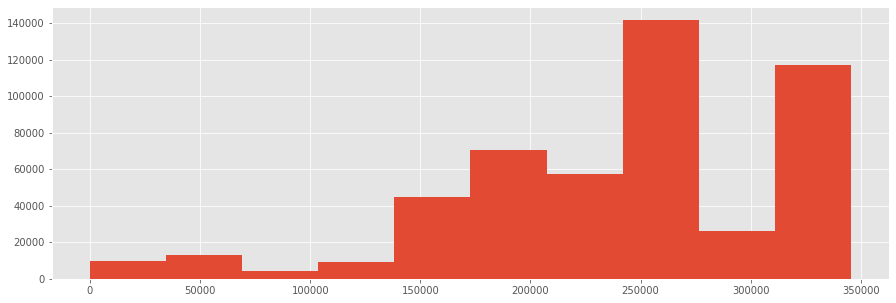

In [ ]:
descrp_num(df_clean,'Census_OEMModelIdentifier', TARGET)

In [ ]:
df_clean['Census_OEMModelIdentifier'].fillna(-1, inplace = True)

Mantenemos la variable

## Census_ProcessorCoreCount

'VALUE COUNTS'

Census_ProcessorCoreCount
4.0                      304102
2.0                      129178
8.0                       48995
12.0                       5184
6.0                        4023
1.0                        3980
NaN                        2347
16.0                       1006
3.0                         752
32.0                        113
20.0                         97
24.0                         95
40.0                         39
28.0                         17
36.0                         16
48.0                         15
5.0                          10
10.0                         10
56.0                          8
7.0                           3
11.0                          2
64.0                          2
52.0                          1
44.0                          1
88.0                          1
80.0                          1
14.0                          1
46.0                          1

'NULOS'

2347

'DESCRIBE'

Census_ProcessorCoreCount
count              497653.000000
mean                    3.994074
std                     2.071281
min                     1.000000
25%                     2.000000
50%                     4.000000
75%                     4.000000
max                    88.000000

'CORR'

HasDetections  Census_ProcessorCoreCount
HasDetections                   1.000000                   0.056069
Census_ProcessorCoreCount       0.056069                   1.000000

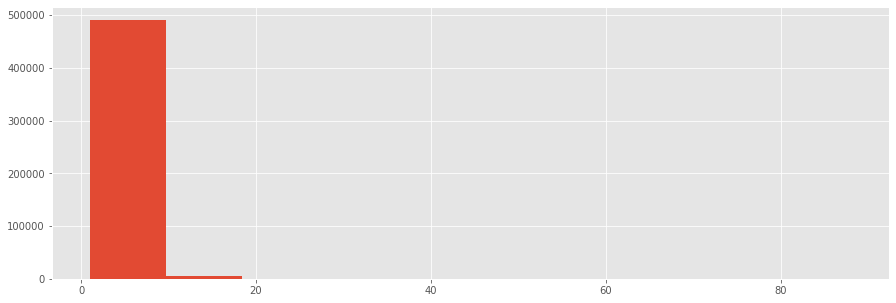

In [ ]:
descrp_num(df_clean, 'Census_ProcessorCoreCount', TARGET)

In [ ]:
df_clean['Census_ProcessorCoreCount'].fillna(-1, inplace= True)

Mantenemos la variable.

## Census_ProcessorManufacturerIdentifier

'VALUE COUNTS'

Census_ProcessorManufacturerIdentifier
5.0                                   439028
1.0                                    58604
NaN                                     2347
10.0                                      14
3.0                                        7

'NULOS'

2347

'DESCRIBE'

Census_ProcessorManufacturerIdentifier
count                           497653.000000
mean                                 4.529069
std                                  1.289635
min                                  1.000000
25%                                  5.000000
50%                                  5.000000
75%                                  5.000000
max                                 10.000000

'CORR'

HasDetections  Census_ProcessorManufacturerIdentifier
HasDetections                                1.000000                                0.007172
Census_ProcessorManufacturerIdentifier       0.007172                                1.000000

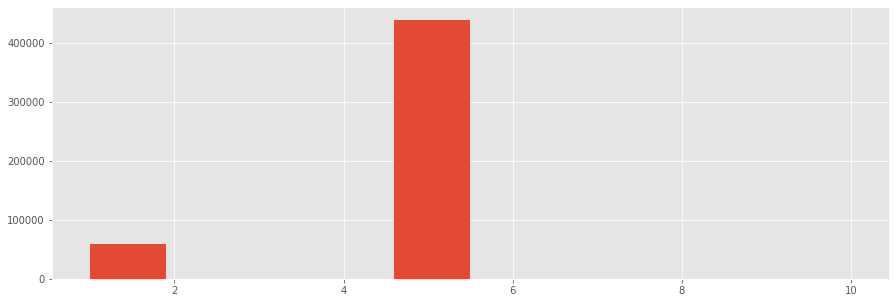

In [ ]:
descrp_num(df_clean, 'Census_ProcessorManufacturerIdentifier', TARGET)

Eliminamos la variable por el desbalance que hay.

In [ ]:
df_clean.drop('Census_ProcessorManufacturerIdentifier', axis = 1, inplace = True)

## Census_ProcessorModelIdentifier

'VALUE COUNTS'

Census_ProcessorModelIdentifier
2697.0                            16180
1998.0                            14874
2660.0                            10736
2373.0                             9885
1992.0                             9502
...                                 ...
4091.0                                1
1328.0                                1
1852.0                                1
3130.0                                1
4027.0                                1

[2244 rows x 1 columns]

'NULOS'

2349

'DESCRIBE'

Census_ProcessorModelIdentifier
count                    497651.000000
mean                       2370.986509
std                         842.136675
min                           3.000000
25%                        1998.000000
50%                        2500.000000
75%                        2877.000000
max                        4472.000000

'CORR'

HasDetections  Census_ProcessorModelIdentifier
HasDetections                         1.000000                         0.021671
Census_ProcessorModelIdentifier       0.021671                         1.000000

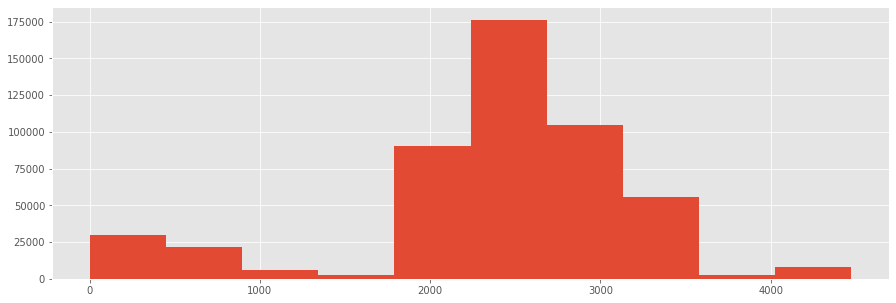

In [ ]:
descrp_num(df_clean, 'Census_ProcessorModelIdentifier', TARGET)

In [ ]:
df_clean['Census_ProcessorModelIdentifier'].fillna(-1, inplace= True)

Mantenemos la variable.

## Census_PrimaryDiskTotalCapacity

'VALUE COUNTS'

Census_PrimaryDiskTotalCapacity
476940.0                           158683
953869.0                           122183
305245.0                            26687
122104.0                            26444
244198.0                            25159
...                                   ...
948333.0                                1
20646.0                                 1
122069.0                                1
190652.0                                1
152499.0                                1

[1104 rows x 1 columns]

'NULOS'

2976

'DESCRIBE'

Census_PrimaryDiskTotalCapacity
count                     4.970240e+05
mean                      5.140433e+05
std                       3.704468e+05
min                       1.024000e+04
25%                       2.393720e+05
50%                       4.769400e+05
75%                       9.538690e+05
max                       4.768767e+07

'CORR'

HasDetections  Census_PrimaryDiskTotalCapacity
HasDetections                         1.000000                         0.048048
Census_PrimaryDiskTotalCapacity       0.048048                         1.000000

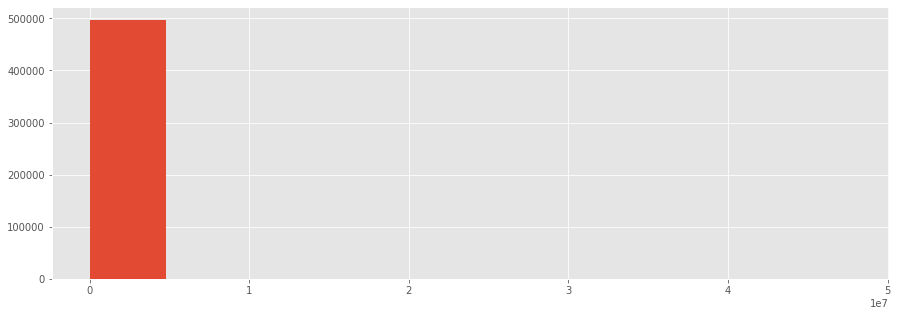

In [ ]:
descrp_num(df_clean, 'Census_PrimaryDiskTotalCapacity', TARGET)

In [ ]:
df_clean['Census_PrimaryDiskTotalCapacity'].fillna(-1, inplace = True)

Mantenemos la variable.

## Census_SystemVolumeTotalCapacity

'VALUE COUNTS'

Census_SystemVolumeTotalCapacity
NaN                                   2976
28542.0                               2922
926992.0                              2866
476389.0                              2380
476324.0                              2306
...                                    ...
221517.0                                 1
580181.0                                 1
127615.0                                 1
236484.0                                 1
470309.0                                 1

[142052 rows x 1 columns]

'NULOS'

2976

'DESCRIBE'

Census_SystemVolumeTotalCapacity
count                      4.970240e+05
mean                       3.780546e+05
std                        3.384722e+05
min                        9.689000e+03
25%                        1.207750e+05
50%                        2.494500e+05
75%                        4.759810e+05
max                        4.768710e+07

'CORR'

HasDetections  Census_SystemVolumeTotalCapacity
HasDetections                          1.000000                          0.013595
Census_SystemVolumeTotalCapacity       0.013595                          1.000000

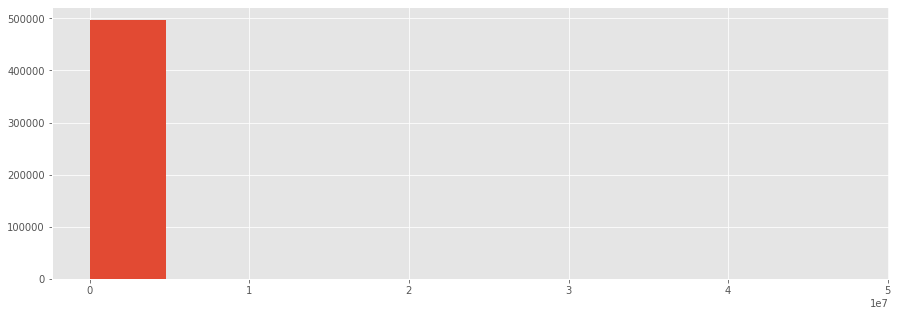

In [ ]:
descrp_num(df_clean, 'Census_SystemVolumeTotalCapacity', TARGET)

In [ ]:
df_clean['Census_SystemVolumeTotalCapacity'].fillna(-1, inplace = True)

Mantenemos la variable.

## Census_HasOpticalDiskDrive

'VALUE COUNTS'

Census_HasOpticalDiskDrive
0                      461483
1                       38517

'NULOS'

0

'DESCRIBE'

Census_HasOpticalDiskDrive
count               500000.000000
mean                     0.077034
std                      0.266646
min                      0.000000
25%                      0.000000
50%                      0.000000
75%                      0.000000
max                      1.000000

'CORR'

HasDetections  Census_HasOpticalDiskDrive
HasDetections                    1.000000                    0.020073
Census_HasOpticalDiskDrive       0.020073                    1.000000

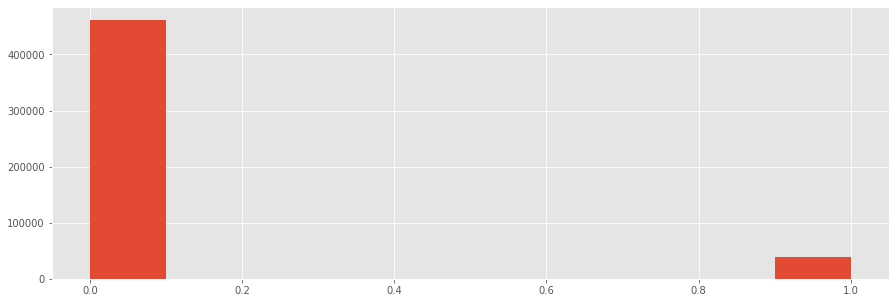

In [ ]:
descrp_num(df_clean, 'Census_HasOpticalDiskDrive', TARGET)

Boolean lo mantenemos.

## Census_TotalPhysicalRAM

'VALUE COUNTS'

Census_TotalPhysicalRAM
4096.0                    228678
8192.0                    123174
2048.0                     61694
16384.0                    30179
6144.0                     22349
...                          ...
1279.0                         1
2096.0                         1
2064.0                         1
2804.0                         1
4120.0                         1

[553 rows x 1 columns]

'NULOS'

4556

'DESCRIBE'

Census_TotalPhysicalRAM
count            495444.000000
mean               6129.232176
std                4964.521253
min                 512.000000
25%                4096.000000
50%                4096.000000
75%                8192.000000
max              393216.000000

'CORR'

HasDetections  Census_TotalPhysicalRAM
HasDetections                 1.000000                 0.060432
Census_TotalPhysicalRAM       0.060432                 1.000000

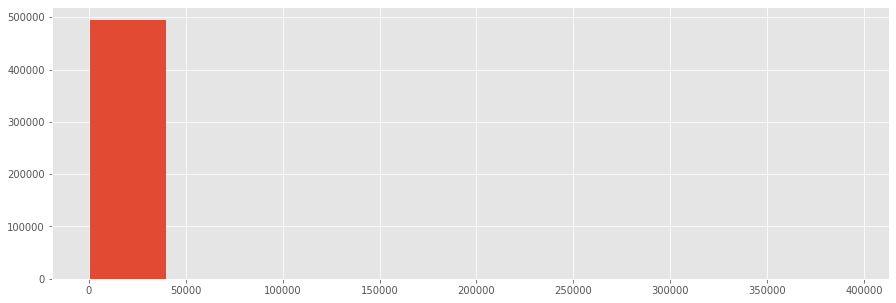

In [ ]:
descrp_num(df_clean, 'Census_TotalPhysicalRAM', TARGET)

In [ ]:
df_clean['Census_TotalPhysicalRAM'].fillna(-1, inplace = True)

Mantenemos la variable

## Census_InternalPrimaryDiagonalDisplaySizeInInches

'VALUE COUNTS'

Census_InternalPrimaryDiagonalDisplaySizeInInches
15.5                                             171319
13.9                                              52873
14.0                                              30492
11.6                                              17592
21.5                                              15441
...                                                 ...
7.3                                                   1
36.4                                                  1
61.7                                                  1
73.2                                                  1
95.4                                                  1

[521 rows x 1 columns]

'NULOS'

2654

'DESCRIBE'

Census_InternalPrimaryDiagonalDisplaySizeInInches
count                                      497346.000000
mean                                           16.689837
std                                             5.932014
min                                             4.900000
25%                                            13.900000
50%                                            15.500000
75%                                            17.200000
max                                           142.000000

'CORR'

HasDetections  Census_InternalPrimaryDiagonalDisplaySizeInInches
HasDetections                                           1.000000                                           0.032757
Census_InternalPrimaryDiagonalDisplaySizeInInches       0.032757                                           1.000000

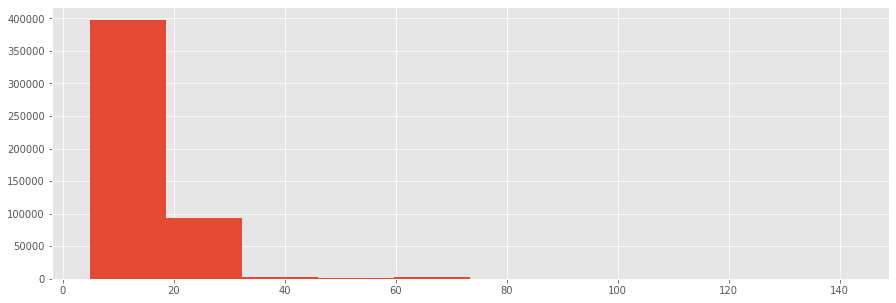

In [ ]:
descrp_num(df_clean, 'Census_InternalPrimaryDiagonalDisplaySizeInInches', TARGET)

In [ ]:
df_clean['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(-1, inplace = True)

Mantenemos la variable.

## Census_InternalPrimaryDisplayResolutionHorizontal

'VALUE COUNTS'

Census_InternalPrimaryDisplayResolutionHorizontal
1366.0                                              251999
1920.0                                              125095
1280.0                                               29690
1600.0                                               28231
1024.0                                               19327
...                                                    ...
6016.0                                                   1
4288.0                                                   1
1646.0                                                   1
2528.0                                                   1
10320.0                                                  1

[475 rows x 1 columns]

'NULOS'

2650

'DESCRIBE'

Census_InternalPrimaryDisplayResolutionHorizontal
count                                      497350.000000
mean                                         1548.304317
std                                           368.565945
min                                            -1.000000
25%                                          1366.000000
50%                                          1366.000000
75%                                          1920.000000
max                                         11520.000000

'CORR'

HasDetections  Census_InternalPrimaryDisplayResolutionHorizontal
HasDetections                                           1.000000                                           0.031411
Census_InternalPrimaryDisplayResolutionHorizontal       0.031411                                           1.000000

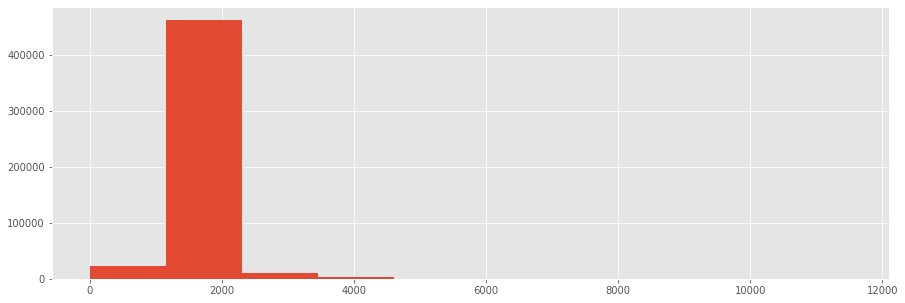

In [ ]:
descrp_num(df_clean, 'Census_InternalPrimaryDisplayResolutionHorizontal', TARGET)

In [ ]:
df_clean[df_clean['Census_InternalPrimaryDisplayResolutionHorizontal']==0]

Empty DataFrame
Columns: [MachineIdentifier, ProductName, EngineVersion, AppVersion, AvSigVersion, RtpStateBitfield, AVProductStatesIdentifier, AVProductsInstalled, HasTpm, CountryIdentifier, CityIdentifier, OrganizationIdentifier, GeoNameIdentifier, LocaleEnglishNameIdentifier, Platform, Processor, OsVer, OsBuild, OsSuite, OsPlatformSubRelease, OsBuildLab, SkuEdition, IsProtected, PuaMode, SMode, IeVerIdentifier, SmartScreen, Firewall, Census_MDC2FormFactor, Census_DeviceFamily, Census_OEMNameIdentifier, Census_OEMModelIdentifier, Census_ProcessorCoreCount, Census_ProcessorModelIdentifier, Census_ProcessorClass, Census_PrimaryDiskTotalCapacity, Census_PrimaryDiskTypeName, Census_SystemVolumeTotalCapacity, Census_HasOpticalDiskDrive, Census_TotalPhysicalRAM, Census_ChassisTypeName, Census_InternalPrimaryDiagonalDisplaySizeInInches, Census_InternalPrimaryDisplayResolutionHorizontal, Census_InternalPrimaryDisplayResolutionVertical, Census_PowerPlatformRoleName, Census_InternalBatteryType, Census_InternalBatteryNumberOfCharges, Census_OSVersion, Census_OSArchitecture, Census_OSBranch, Census_OSBuildNumber, Census_OSBuildRevision, Census_OSEdition, Census_OSSkuName, Census_OSInstallTypeName, Census_OSInstallLanguageIdentifier, Census_OSUILocaleIdentifier, Census_OSWUAutoUpdateOptionsName, Census_IsPortableOperatingSystem, Census_GenuineStateName, Census_ActivationChannel, Census_IsFlightingInternal, Census_IsFlightsDisabled, Census_FlightRing, Census_ThresholdOptIn, Census_FirmwareManufacturerIdentifier, Census_FirmwareVersionIdentifier, Census_IsSecureBootEnabled, Census_IsVirtualDevice, Census_IsTouchEnabled, Census_IsPenCapable, Census_IsAlwaysOnAlwaysConnectedCapable, Wdft_IsGamer, Wdft_RegionIdentifier, HasDetections]
Index: []

In [ ]:
df_clean.loc[df_clean['Census_InternalPrimaryDisplayResolutionHorizontal'] == -1, 'Census_InternalPrimaryDisplayResolutionHorizontal'] = 0

In [ ]:
df_clean['Census_InternalPrimaryDisplayResolutionHorizontal'].fillna(-1, inplace = True)

Cambiamos los valores de -1 a 0, porque no hay pantallas con pulgadas negativas, y los nulos llenamos con -1.

## Census_InternalPrimaryDisplayResolutionVertical

'VALUE COUNTS'

Census_InternalPrimaryDisplayResolutionVertical
768.0                                            277762
1080.0                                           121145
900.0                                             36912
800.0                                             14687
1024.0                                            10603
...                                                 ...
1960.0                                                1
1295.0                                                1
2286.0                                                1
880.0                                                 1
1612.0                                                1

[515 rows x 1 columns]

'NULOS'

2650

'DESCRIBE'

Census_InternalPrimaryDisplayResolutionVertical
count                                    497350.000000
mean                                        898.239345
std                                         214.862450
min                                          -1.000000
25%                                         768.000000
50%                                         768.000000
75%                                        1080.000000
max                                        4320.000000

'CORR'

HasDetections  Census_InternalPrimaryDisplayResolutionVertical
HasDetections                                          1.00000                                          0.01356
Census_InternalPrimaryDisplayResolutionVertical        0.01356                                          1.00000

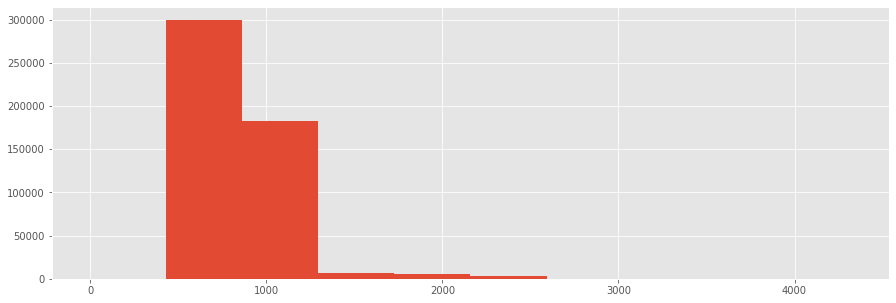

In [ ]:
descrp_num(df_clean, 'Census_InternalPrimaryDisplayResolutionVertical', TARGET)

In [ ]:
df_clean.loc[df_clean['Census_InternalPrimaryDisplayResolutionVertical'] == -1, 'Census_InternalPrimaryDisplayResolutionVertical'] = 0

In [ ]:
df_clean['Census_InternalPrimaryDisplayResolutionVertical'].fillna(-1, inplace = True)

Cambiamos los valores de -1 a 0, porque no hay pantallas con pulgadas negativas, y los nulos llenamos con -1.

## Census_InternalBatteryNumberOfCharges

'VALUE COUNTS'

Census_InternalBatteryNumberOfCharges
0.000000e+00                                 283189
4.294967e+09                                 126436
NaN                                           15038
1.000000e+00                                   2955
1.600000e+01                                   1517
...                                             ...
1.253000e+03                                      1
3.313400e+04                                      1
1.182000e+03                                      1
5.377000e+04                                      1
1.900000e+03                                      1

[5249 rows x 1 columns]

'NULOS'

15038

'DESCRIBE'

Census_InternalBatteryNumberOfCharges
count                           4.849620e+05
mean                            1.125600e+09
std                             1.888768e+09
min                             0.000000e+00
25%                             0.000000e+00
50%                             0.000000e+00
75%                             4.294967e+09
max                             4.294967e+09

'CORR'

HasDetections  Census_InternalBatteryNumberOfCharges
HasDetections                                1.00000                                0.01998
Census_InternalBatteryNumberOfCharges        0.01998                                1.00000

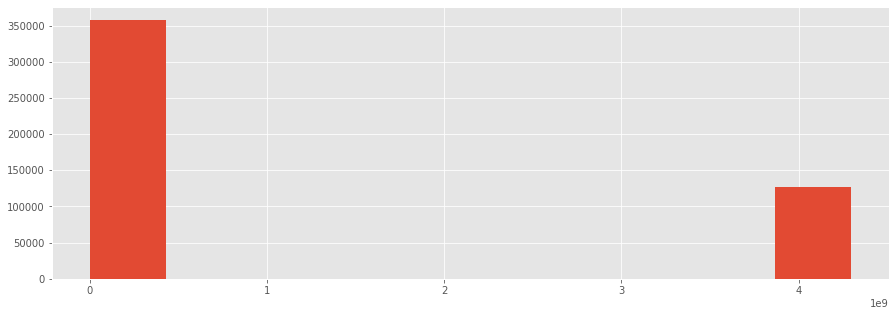

In [ ]:
descrp_num(df_clean, 'Census_InternalBatteryNumberOfCharges', TARGET)

In [ ]:
df_clean['Census_InternalBatteryNumberOfCharges'].fillna(-1, inplace = True)

Mantenemos la variable.

## Census_OSInstallLanguageIdentifier

'VALUE COUNTS'

Census_OSInstallLanguageIdentifier
8.0                               178405
9.0                                58013
7.0                                28766
29.0                               27669
14.0                               24191
37.0                               22635
10.0                               20268
26.0                               18520
5.0                                14085
35.0                               11497
39.0                               11221
18.0                               10600
20.0                                9512
24.0                                8127
25.0                                7502
27.0                                5956
19.0                                4775
17.0                                4695
1.0                                 4516
3.0                                 4067
NaN                                 3332
6.0                                 2881
33.0                                2807
15.0                                2311
4.0                                 1996
30.0                                1793
23.0                                1652
31.0                                1213
12.0                                1119
2.0                                 1096
36.0                                 846
16.0                                 837
28.0                                 713
34.0                                 584
13.0                                 581
21.0                                 413
32.0                                 246
11.0                                 197
38.0                                 185
22.0                                 178

'NULOS'

3332

'DESCRIBE'

Census_OSInstallLanguageIdentifier
count                       496668.000000
mean                            14.605509
std                             10.200946
min                              1.000000
25%                              8.000000
50%                              9.000000
75%                             20.000000
max                             39.000000

'CORR'

HasDetections  Census_OSInstallLanguageIdentifier
HasDetections                            1.000000                            0.004451
Census_OSInstallLanguageIdentifier       0.004451                            1.000000

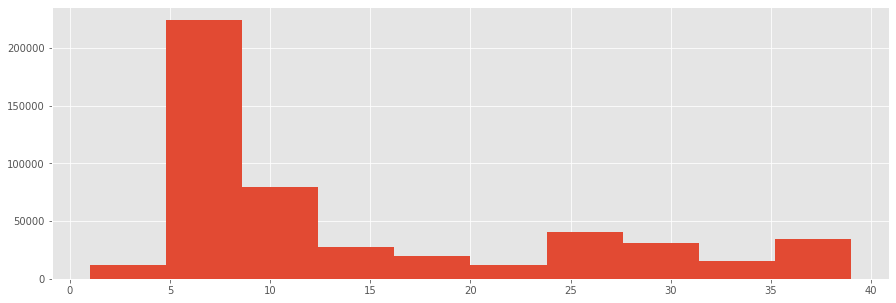

In [ ]:
descrp_num(df_clean, 'Census_OSInstallLanguageIdentifier', TARGET)

In [ ]:
df_clean['Census_OSInstallLanguageIdentifier'].fillna(-1, inplace = True)

Mantenemos la variable.

## Census_OSUILocaleIdentifier

'VALUE COUNTS'

Census_OSUILocaleIdentifier
31                        177983
34                         58307
30                         28798
125                        28001
49                         24423
..                           ...
89                             1
22                             1
6                              1
71                             1
141                            1

[92 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

Census_OSUILocaleIdentifier
count                500000.000000
mean                     60.446306
std                      45.000423
min                       1.000000
25%                      31.000000
50%                      34.000000
75%                      90.000000
max                     162.000000

'CORR'

HasDetections  Census_OSUILocaleIdentifier
HasDetections                     1.000000                     0.003678
Census_OSUILocaleIdentifier       0.003678                     1.000000

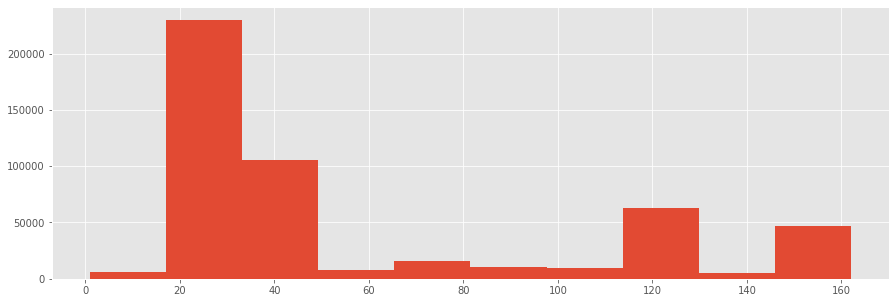

In [ ]:
descrp_num(df_clean, 'Census_OSUILocaleIdentifier', TARGET)

Mantenemos la variable.

## Census_OSUILocaleIdentifier

'VALUE COUNTS'

Census_OSUILocaleIdentifier
31                        177983
34                         58307
30                         28798
125                        28001
49                         24423
..                           ...
89                             1
22                             1
6                              1
71                             1
141                            1

[92 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

Census_OSUILocaleIdentifier
count                500000.000000
mean                     60.446306
std                      45.000423
min                       1.000000
25%                      31.000000
50%                      34.000000
75%                      90.000000
max                     162.000000

'CORR'

HasDetections  Census_OSUILocaleIdentifier
HasDetections                     1.000000                     0.003678
Census_OSUILocaleIdentifier       0.003678                     1.000000

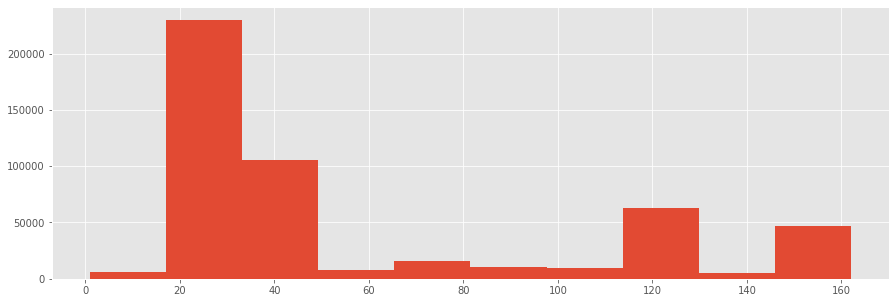

In [ ]:
descrp_num(df_clean, 'Census_OSUILocaleIdentifier', TARGET)

Mantenemos la variable.

## Census_IsPortableOperatingSystem

'VALUE COUNTS'

Census_IsPortableOperatingSystem
0                            499739
1                               261

'NULOS'

0

'DESCRIBE'

Census_IsPortableOperatingSystem
count                     500000.000000
mean                           0.000522
std                            0.022841
min                            0.000000
25%                            0.000000
50%                            0.000000
75%                            0.000000
max                            1.000000

'CORR'

HasDetections  Census_IsPortableOperatingSystem
HasDetections                          1.000000                          0.000792
Census_IsPortableOperatingSystem       0.000792                          1.000000

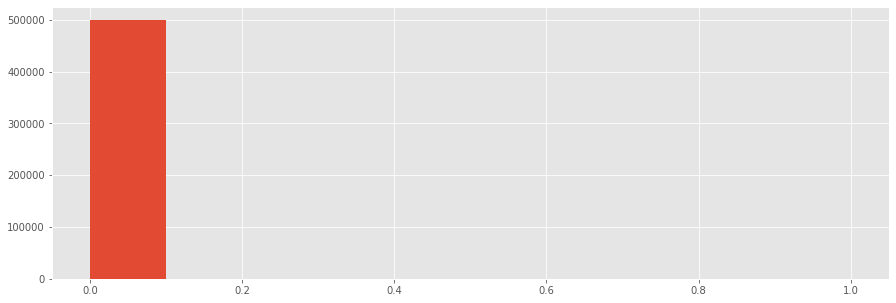

In [ ]:
descrp_num(df_clean, 'Census_IsPortableOperatingSystem', TARGET)

Boolean, la mantenemos.

##Census_IsFlightingInternal

'VALUE COUNTS'

Census_IsFlightingInternal
NaN                      415225
0.0                       84773
1.0                           2

'NULOS'

415225

'DESCRIBE'

Census_IsFlightingInternal
count                84775.000000
mean                     0.000024
std                      0.004857
min                      0.000000
25%                      0.000000
50%                      0.000000
75%                      0.000000
max                      1.000000

'CORR'

HasDetections  Census_IsFlightingInternal
HasDetections                    1.000000                    0.000147
Census_IsFlightingInternal       0.000147                    1.000000

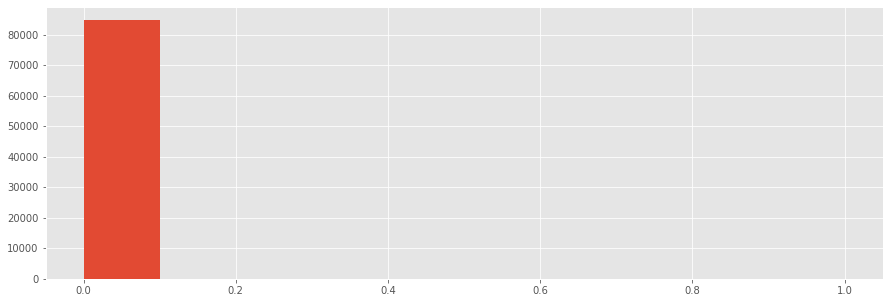

In [ ]:
descrp_num(df_clean, 'Census_IsFlightingInternal', TARGET)

Muy desbalanceada, la eliminamos muy desbalanceada.





In [ ]:
df_clean.drop('Census_IsFlightingInternal', axis=1, inplace= True)

## Census_IsFlightsDisabled

'VALUE COUNTS'

Census_IsFlightsDisabled
0.0                    491060
NaN                      8933
1.0                         7

'NULOS'

8933

'DESCRIBE'

Census_IsFlightsDisabled
count             491067.000000
mean                   0.000014
std                    0.003776
min                    0.000000
25%                    0.000000
50%                    0.000000
75%                    0.000000
max                    1.000000

'CORR'

HasDetections  Census_IsFlightsDisabled
HasDetections                  1.000000                 -0.003774
Census_IsFlightsDisabled      -0.003774                  1.000000

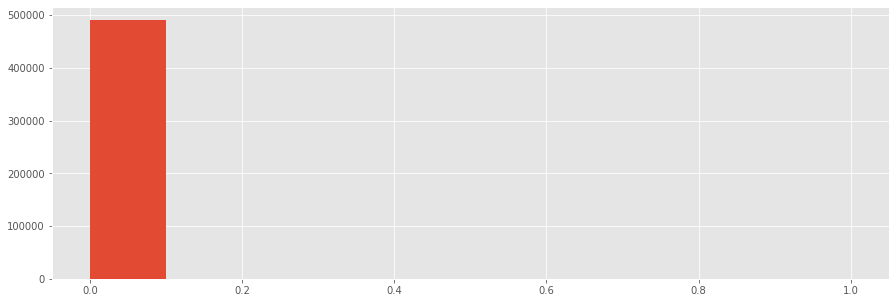

In [ ]:
descrp_num(df_clean, 'Census_IsFlightsDisabled', TARGET)

Muy desbalanceada, la eliminamos muy desbalanceada.

In [ ]:
df_clean.drop('Census_IsFlightsDisabled', axis=1, inplace= True)

## Census_ThresholdOptIn

'VALUE COUNTS'

Census_ThresholdOptIn
NaN                 318104
0.0                 181849
1.0                     47

'NULOS'

318104

'DESCRIBE'

Census_ThresholdOptIn
count          181896.000000
mean                0.000258
std                 0.016072
min                 0.000000
25%                 0.000000
50%                 0.000000
75%                 0.000000
max                 1.000000

'CORR'

HasDetections  Census_ThresholdOptIn
HasDetections                1.00000               -0.00071
Census_ThresholdOptIn       -0.00071                1.00000

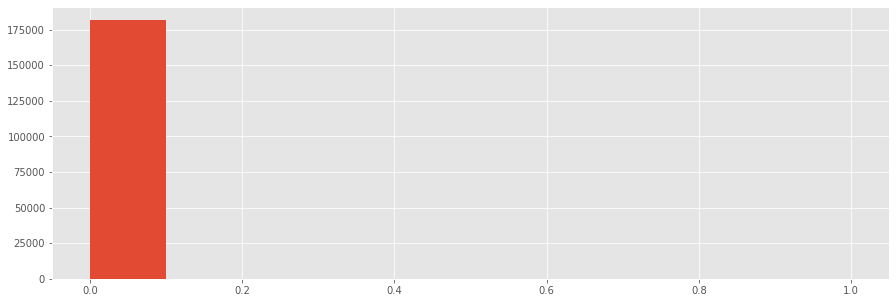

In [ ]:
descrp_num(df_clean, 'Census_ThresholdOptIn', TARGET)

In [ ]:
df_clean['Census_ThresholdOptIn'].fillna(-1, inplace = True)

Mantenemos la variable.



## Census_FirmwareManufacturerIdentifier

'VALUE COUNTS'

Census_FirmwareManufacturerIdentifier
142.0                                 151374
628.0                                  68781
554.0                                  65673
355.0                                  52758
556.0                                  44919
...                                      ...
33.0                                       1
697.0                                      1
13.0                                       1
334.0                                      1
585.0                                      1

[304 rows x 1 columns]

'NULOS'

10349

'DESCRIBE'

Census_FirmwareManufacturerIdentifier
count                          489651.000000
mean                              402.675943
std                               221.527124
min                                11.000000
25%                               142.000000
50%                               500.000000
75%                               556.000000
max                              1084.000000

'CORR'

HasDetections  Census_FirmwareManufacturerIdentifier
HasDetections                               1.000000                              -0.026531
Census_FirmwareManufacturerIdentifier      -0.026531                               1.000000

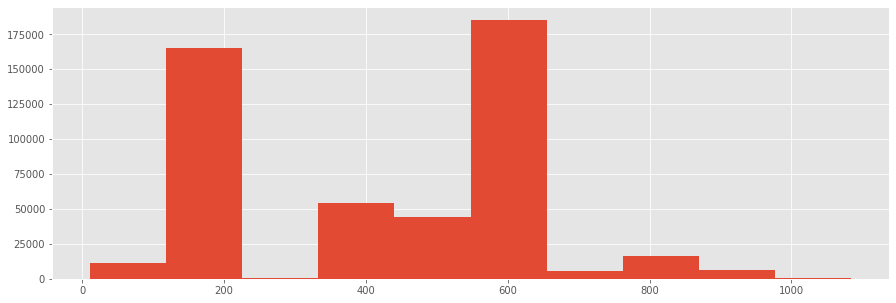

In [ ]:
descrp_num(df_clean, 'Census_FirmwareManufacturerIdentifier', TARGET)

In [ ]:
df_clean['Census_FirmwareManufacturerIdentifier'].fillna(-1, inplace = True)

Mantenemos la variable.

## Census_FirmwareVersionIdentifier

'VALUE COUNTS'

Census_FirmwareVersionIdentifier
NaN                                  9061
33105.0                              5036
33111.0                              3356
33054.0                              3124
33108.0                              3071
...                                   ...
41482.0                                 1
41752.0                                 1
20762.0                                 1
15577.0                                 1
54497.0                                 1

[23570 rows x 1 columns]

'NULOS'

9061

'DESCRIBE'

Census_FirmwareVersionIdentifier
count                     490939.000000
mean                       33030.988944
std                        21220.161428
min                           10.000000
25%                        13156.000000
50%                        33070.000000
75%                        52436.000000
max                        72091.000000

'CORR'

HasDetections  Census_FirmwareVersionIdentifier
HasDetections                          1.000000                          0.001599
Census_FirmwareVersionIdentifier       0.001599                          1.000000

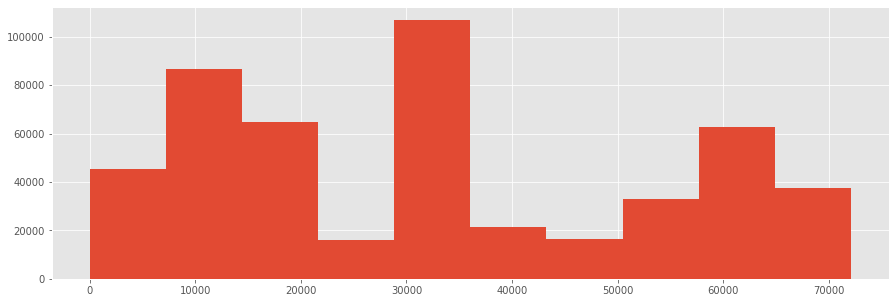

In [ ]:
descrp_num(df_clean, 'Census_FirmwareVersionIdentifier', TARGET)

In [ ]:
df_clean['Census_FirmwareVersionIdentifier'].fillna(-1, inplace = True)

Mantenemos la variable.

## Census_IsSecureBootEnabled

'VALUE COUNTS'

Census_IsSecureBootEnabled
0                      257281
1                      242719

'NULOS'

0

'DESCRIBE'

Census_IsSecureBootEnabled
count               500000.000000
mean                     0.485438
std                      0.499788
min                      0.000000
25%                      0.000000
50%                      0.000000
75%                      1.000000
max                      1.000000

'CORR'

HasDetections  Census_IsSecureBootEnabled
HasDetections                    1.000000                   -0.002487
Census_IsSecureBootEnabled      -0.002487                    1.000000

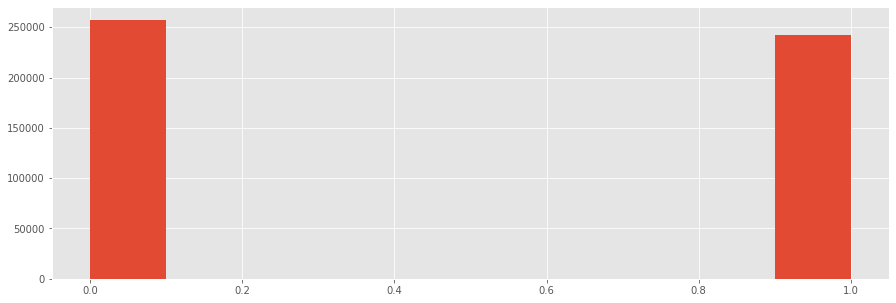

In [ ]:
descrp_num(df_clean, 'Census_IsSecureBootEnabled', TARGET)

Boolean balanceada, la mantenemos.

## Census_IsVirtualDevice



'VALUE COUNTS'

Census_IsVirtualDevice
0.0                  495572
1.0                    3527
NaN                     901

'NULOS'

901

'DESCRIBE'

Census_IsVirtualDevice
count           499099.000000
mean                 0.007067
std                  0.083766
min                  0.000000
25%                  0.000000
50%                  0.000000
75%                  0.000000
max                  1.000000

'CORR'

HasDetections  Census_IsVirtualDevice
HasDetections                1.000000               -0.050279
Census_IsVirtualDevice      -0.050279                1.000000

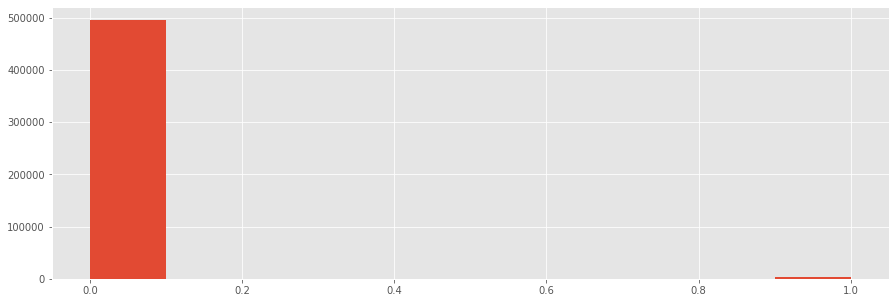

In [ ]:
descrp_num(df_clean, 'Census_IsVirtualDevice', TARGET)

Llenamos los nulos con el valor de la minoría para tener un Boolean y considerando que es un porcentaje muy bajo en comparación a los False.

In [ ]:
df_clean['Census_IsVirtualDevice'].fillna(1, inplace = True)

## Census_IsTouchEnabled

'VALUE COUNTS'

Census_IsTouchEnabled
0                 437283
1                  62717

'NULOS'

0

'DESCRIBE'

Census_IsTouchEnabled
count          500000.000000
mean                0.125434
std                 0.331211
min                 0.000000
25%                 0.000000
50%                 0.000000
75%                 0.000000
max                 1.000000

'CORR'

HasDetections  Census_IsTouchEnabled
HasDetections               1.000000              -0.040622
Census_IsTouchEnabled      -0.040622               1.000000

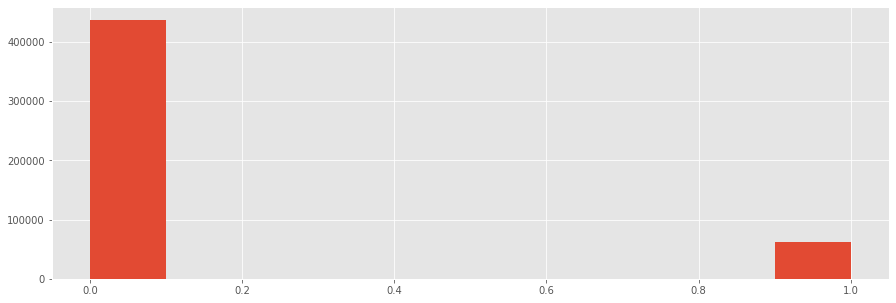

In [ ]:
descrp_num(df_clean, 'Census_IsTouchEnabled', TARGET)

Boolean, mantenemos.

## Census_IsPenCapable

'VALUE COUNTS'

Census_IsPenCapable
0               481128
1                18872

'NULOS'

0

'DESCRIBE'

Census_IsPenCapable
count        500000.000000
mean              0.037744
std               0.190577
min               0.000000
25%               0.000000
50%               0.000000
75%               0.000000
max               1.000000

'CORR'

HasDetections  Census_IsPenCapable
HasDetections              1.00000             -0.01688
Census_IsPenCapable       -0.01688              1.00000

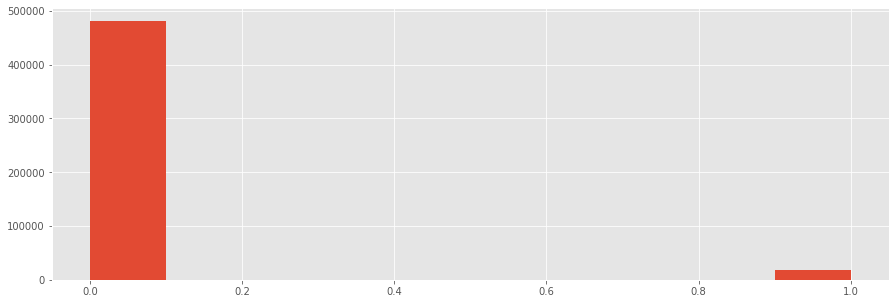

In [ ]:
descrp_num(df_clean, 'Census_IsPenCapable', TARGET)

Boolean, mantenemos.

## Census_IsAlwaysOnAlwaysConnectedCapable

'VALUE COUNTS'

Census_IsAlwaysOnAlwaysConnectedCapable
0.0                                   467569
1.0                                    28391
NaN                                     4040

'NULOS'

4040

'DESCRIBE'

Census_IsAlwaysOnAlwaysConnectedCapable
count                            495960.000000
mean                                  0.057245
std                                   0.232310
min                                   0.000000
25%                                   0.000000
50%                                   0.000000
75%                                   0.000000
max                                   1.000000

'CORR'

HasDetections  Census_IsAlwaysOnAlwaysConnectedCapable
HasDetections                                  1.00000                                 -0.06312
Census_IsAlwaysOnAlwaysConnectedCapable       -0.06312                                  1.00000

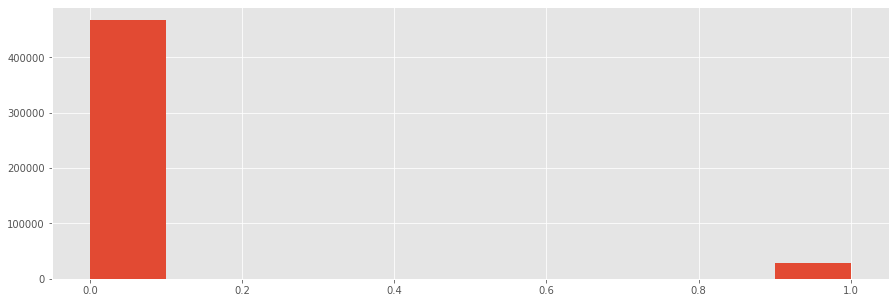

In [ ]:
descrp_num(df_clean, 'Census_IsAlwaysOnAlwaysConnectedCapable', TARGET)

In [ ]:
df_clean['Census_IsAlwaysOnAlwaysConnectedCapable'].fillna(1, inplace = True)

Boolean, mantenemos.

## Wdft_IsGamer

'VALUE COUNTS'

Wdft_IsGamer
0.0        345835
1.0        137215
NaN         16950

'NULOS'

16950

'DESCRIBE'

Wdft_IsGamer
count  483050.000000
mean        0.284060
std         0.450966
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

'CORR'

HasDetections  Wdft_IsGamer
HasDetections       1.000000      0.056858
Wdft_IsGamer        0.056858      1.000000

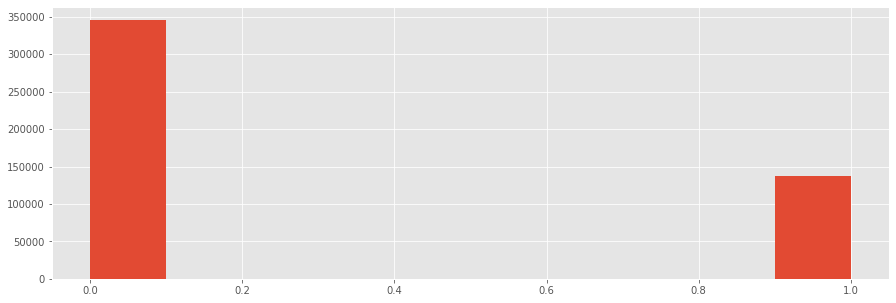

In [ ]:
descrp_num(df_clean,'Wdft_IsGamer', TARGET)

In [ ]:
df_clean['Wdft_IsGamer'].fillna(1, inplace = True)

Transformada a Boolean, por minoría la mantenemos.

## Wdft_RegionIdentifier

'VALUE COUNTS'

Wdft_RegionIdentifier
10.0                 100392
11.0                  75612
3.0                   73069
1.0                   68692
15.0                  57346
7.0                   33362
NaN                   16950
8.0                   15761
13.0                  12681
5.0                   11466
12.0                   9115
6.0                    8750
4.0                    7586
9.0                    4521
2.0                    4470
14.0                    227

'NULOS'

16950

'DESCRIBE'

Wdft_RegionIdentifier
count          483050.000000
mean                7.888577
std                 4.551764
min                 1.000000
25%                 3.000000
50%                10.000000
75%                11.000000
max                15.000000

'CORR'

HasDetections  Wdft_RegionIdentifier
HasDetections                 1.0000                -0.0217
Wdft_RegionIdentifier        -0.0217                 1.0000

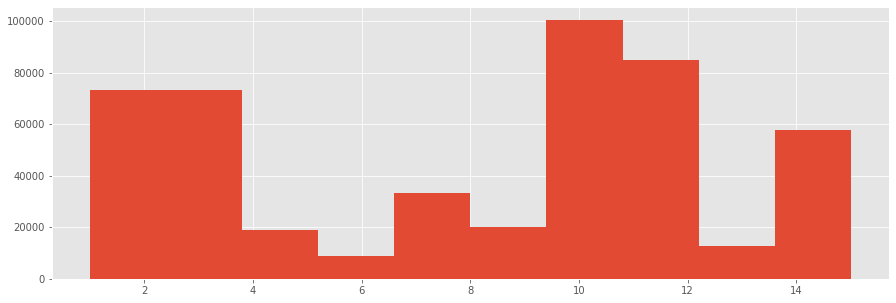

In [ ]:
descrp_num(df_clean, 'Wdft_RegionIdentifier',TARGET)

In [ ]:
df_clean['Wdft_RegionIdentifier'].fillna(-1, inplace = True)

Mantenemos la variable.

# Ahora pasamos al análisis de Categóricas.

In [ ]:
df_clean.describe(exclude = np.number).T

count  ...    freq
MachineIdentifier                 500000  ...       1
ProductName                       500000  ...  494604
EngineVersion                     500000  ...  216491
AppVersion                        500000  ...  288809
AvSigVersion                      500000  ...    5771
Platform                          500000  ...  483048
Processor                         500000  ...  454423
OsVer                             500000  ...  483830
OsPlatformSubRelease              500000  ...  220779
OsBuildLab                        499999  ...  206436
SkuEdition                        500000  ...  308567
PuaMode                              126  ...     126
SmartScreen                       321404  ...  241594
Census_MDC2FormFactor             500000  ...  320948
Census_DeviceFamily               500000  ...  499183
Census_ProcessorClass               2082  ...    1196
Census_PrimaryDiskTypeName        499291  ...  325429
Census_ChassisTypeName            499963  ...  294232
Census_PowerPlatformRoleName      499998  ...  346378
Census_InternalBatteryType        144397  ...  113500
Census_OSVersion                  500000  ...   79975
Census_OSArchitecture             500000  ...  454435
Census_OSBranch                   500000  ...  226001
Census_OSEdition                  500000  ...  194469
Census_OSSkuName                  500000  ...  194464
Census_OSInstallTypeName          500000  ...  146780
Census_OSWUAutoUpdateOptionsName  500000  ...  222482
Census_GenuineStateName           500000  ...  441402
Census_ActivationChannel          500000  ...  264932
Census_FlightRing                 500000  ...  468299

[30 rows x 4 columns]

## Eliminamos las columnas con poca varianza.

In [ ]:
df_clean.describe(exclude = np.number).T

count  ...    freq
MachineIdentifier                 500000  ...       1
ProductName                       500000  ...  494604
EngineVersion                     500000  ...  216491
AppVersion                        500000  ...  288809
AvSigVersion                      500000  ...    5771
Platform                          500000  ...  483048
Processor                         500000  ...  454423
OsVer                             500000  ...  483830
OsPlatformSubRelease              500000  ...  220779
OsBuildLab                        499999  ...  206436
SkuEdition                        500000  ...  308567
PuaMode                              126  ...     126
SmartScreen                       321404  ...  241594
Census_MDC2FormFactor             500000  ...  320948
Census_DeviceFamily               500000  ...  499183
Census_ProcessorClass               2082  ...    1196
Census_PrimaryDiskTypeName        499291  ...  325429
Census_ChassisTypeName            499963  ...  294232
Census_PowerPlatformRoleName      499998  ...  346378
Census_InternalBatteryType        144397  ...  113500
Census_OSVersion                  500000  ...   79975
Census_OSArchitecture             500000  ...  454435
Census_OSBranch                   500000  ...  226001
Census_OSEdition                  500000  ...  194469
Census_OSSkuName                  500000  ...  194464
Census_OSInstallTypeName          500000  ...  146780
Census_OSWUAutoUpdateOptionsName  500000  ...  222482
Census_GenuineStateName           500000  ...  441402
Census_ActivationChannel          500000  ...  264932
Census_FlightRing                 500000  ...  468299

[30 rows x 4 columns]

In [ ]:
[col for col in df_clean.columns if df_clean[col].nunique(dropna= False) ==1]

[]

No existe ninguna columna que tenga un solo valor, si contamos con los NULOS.

## ProductName

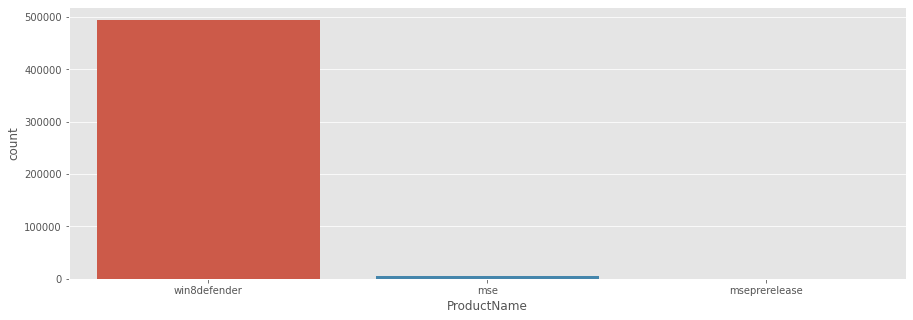

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(df_clean['ProductName'])

In [ ]:
df_clean['ProductName'].value_counts()

win8defender     494604
mse                5395
mseprerelease         1
Name: ProductName, dtype: int64

In [ ]:
df_clean['ProductName'].describe().T

count           500000
unique               3
top       win8defender
freq            494604
Name: ProductName, dtype: object

In [ ]:
pd.crosstab(df['ProductName'],columns=df[TARGET])

HasDetections       0       1
ProductName                  
mse              2809    2586
mseprerelease       1       0
win8defender   247237  247367

## Definimos dos funciones para Categoricas: Descripción y Unificación

In [ ]:
def descrp_cat(dataframe, col_name, Target):

  val_counts = pd.DataFrame(dataframe[col_name].value_counts(dropna= False))
  describe_ = pd.DataFrame(dataframe[col_name].describe())
  nulos = dataframe[col_name].isnull().sum()
  

  plt.figure(figsize=(15,5))
  plt.xticks(rotation=90)
  sns.countplot(dataframe[col_name])

  tab = pd.crosstab(dataframe[col_name],columns=dataframe[Target])

  return display('VALUE COUNTS',val_counts,'NULOS', nulos, 'DESCRIBE',describe_,'CROSSTAB', tab)

'VALUE COUNTS'

ProductName
win8defender        494604
mse                   5395
mseprerelease            1

'NULOS'

0

'DESCRIBE'

ProductName
count         500000
unique             3
top     win8defender
freq          494604

'CROSSTAB'

HasDetections       0       1
ProductName                  
mse              2809    2586
mseprerelease       1       0
win8defender   247237  247367

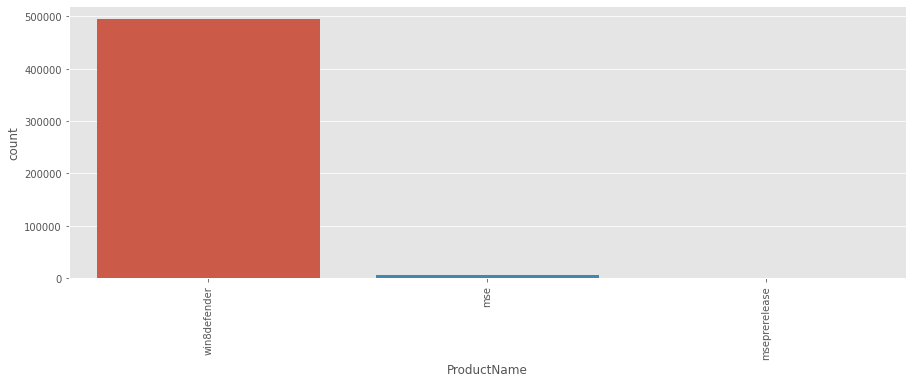

In [ ]:
descrp_cat(df_clean,'ProductName', TARGET)

In [ ]:
def unific_cate(dataframe, column, num_values):
  top_browsers = dataframe[column].value_counts().head(num_values)
  top_browsers_list = top_browsers.index.to_list()
  top_browsers_list.append('Otros')
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_browsers_list)
  return dataframe[column].fillna('Otros')

In [ ]:
unific_cate(df_clean, 'ProductName',1)

8427007    win8defender
8829090    win8defender
2731904    win8defender
1359513    win8defender
236059     win8defender
               ...     
5826339    win8defender
5740034    win8defender
8819786    win8defender
8713685    win8defender
4295573    win8defender
Name: ProductName, Length: 500000, dtype: category
Categories (2, object): ['win8defender', 'Otros']

## ProductName 2

Al haber tanta diferencia entre los 3 productos, los vamos a agrupar para volverlos un boolean.

In [ ]:
df_clean['ProductName']=unific_cate(df_clean, 'ProductName',1)
df_clean['ProductName'].value_counts()

win8defender    494604
Otros             5396
Name: ProductName, dtype: int64

In [ ]:
df_clean['ProductName_win8defender']=df_clean['ProductName']=='win8defender'

In [ ]:
df_clean['ProductName_win8defender']=df_clean['ProductName_win8defender'].astype(int)

In [ ]:
df_clean['ProductName_win8defender'].value_counts()

1    494604
0      5396
Name: ProductName_win8defender, dtype: int64

In [ ]:
df_clean.head()

MachineIdentifier  ... ProductName_win8defender
8427007  f1cd864e97bae82bdf96523e1a539121  ...                        1
8829090  fd5ba6f5b75325ec0423a6c67cc75942  ...                        1
2731904  4e628391e7cc7c482fb3286f486dbd25  ...                        1
1359513  270a2e9d028144a4df12a9e3da79fba5  ...                        1
236059   06ca8fa8d32c2abdc5b3577d676b3269  ...                        1

[5 rows x 74 columns]

In [ ]:
df_clean.tail()

MachineIdentifier  ... ProductName_win8defender
5826339  a739cacc292f3f1e745827c1ca6c6ada  ...                        1
5740034  a4c232d528d98343e8f1b73650da7b82  ...                        1
8819786  fd16cd542d660848d272e4552bcccb1e  ...                        1
8713685  fa0841f8f6147de7c3d287e05270ed42  ...                        1
4295573  7b45dc3537e17f16305c5983ca0a1cb9  ...                        1

[5 rows x 74 columns]

In [ ]:
df_clean.drop('ProductName',axis =1, inplace = True)

## EngineVersion

In [ ]:
descrp_cat(df_clean, 'EngineVersion',TARGET)

'VALUE COUNTS'

EngineVersion
1.1.15200.1         216491
1.1.15100.1         205494
1.1.15000.2          14752
1.1.14901.4          11984
1.1.14600.4           9005
1.1.14800.3           7548
1.1.15300.6           6769
1.1.14104.0           5240
1.1.15300.5           3883
1.1.13504.0           3876
1.1.14700.5           2593
1.1.14500.5           2591
1.1.14405.2           1972
1.1.14306.0           1329
1.1.14202.0            840
1.1.14003.0            804
1.1.13303.0            516
1.1.13903.0            515
1.1.13804.0            513
1.1.13407.0            479
1.1.13601.0            420
1.1.12902.0            321
1.1.14305.0            270
1.1.13701.0            255
1.1.13704.0            255
1.1.13202.0            245
1.1.13103.0            235
1.1.13000.0            220
1.1.15000.1            138
1.1.12805.0            115
1.1.14901.3             71
1.1.14700.4             65
1.1.14700.3             61
1.1.14800.1             51
1.1.14500.2             19
1.1.14201.0             11
1.1.14303.0             10
1.1.12101.0              7
1.1.14103.0              5
1.1.12804.0              4
1.1.13802.0              4
1.1.13902.0              4
1.1.13803.0              3
1.1.12603.0              3
1.1.11701.0              3
1.1.14001.0              2
1.1.14002.0              2
1.1.14102.0              2
1.1.13406.0              1
1.1.12400.0              1
1.1.12706.0              1
1.1.13102.0              1
1.1.10401.0              1

'NULOS'

0

'DESCRIBE'

EngineVersion
count         500000
unique            53
top      1.1.15200.1
freq          216491

'CROSSTAB'

HasDetections       0       1
EngineVersion                
1.1.10401.0         1       0
1.1.11701.0         1       2
1.1.12101.0         3       4
1.1.12400.0         0       1
1.1.12603.0         2       1
1.1.12706.0         1       0
1.1.12804.0         3       1
1.1.12805.0        64      51
1.1.12902.0       193     128
1.1.13000.0       139      81
1.1.13102.0         0       1
1.1.13103.0       151      84
1.1.13202.0       160      85
1.1.13303.0       347     169
1.1.13406.0         0       1
1.1.13407.0       305     174
1.1.13504.0      2170    1706
1.1.13601.0       280     140
1.1.13701.0       169      86
1.1.13704.0       156      99
1.1.13802.0         1       3
1.1.13803.0         3       0
1.1.13804.0       319     194
1.1.13902.0         3       1
1.1.13903.0       307     208
1.1.14001.0         2       0
1.1.14002.0         2       0
1.1.14003.0       460     344
1.1.14102.0         2       0
1.1.14103.0         5       0
1.1.14104.0      2942    2298
1.1.14201.0         6       5
1.1.14202.0       483     357
1.1.14303.0         6       4
1.1.14305.0       156     114
1.1.14306.0       819     510
1.1.14405.2      1197     775
1.1.14500.2        14       5
1.1.14500.5      1559    1032
1.1.14600.4      5019    3986
1.1.14700.3        40      21
1.1.14700.4        41      24
1.1.14700.5      1738     855
1.1.14800.1        38      13
1.1.14800.3      5242    2306
1.1.14901.3        53      18
1.1.14901.4      8314    3670
1.1.15000.1       105      33
1.1.15000.2      9711    5041
1.1.15100.1     91937  113557
1.1.15200.1    110038  106453
1.1.15300.5      1858    2025
1.1.15300.6      3482    3287

In [ ]:
test_1=pd.DataFrame(df_clean['EngineVersion'].sort_values().unique())
test_1.columns = ['EngineVersion']
test_1['EngineVersion_Index'] =test_1.index 


In [ ]:
test_1

EngineVersion  EngineVersion_Index
0    1.1.10401.0                    0
1    1.1.11701.0                    1
2    1.1.12101.0                    2
3    1.1.12400.0                    3
4    1.1.12603.0                    4
5    1.1.12706.0                    5
6    1.1.12804.0                    6
7    1.1.12805.0                    7
8    1.1.12902.0                    8
9    1.1.13000.0                    9
10   1.1.13102.0                   10
11   1.1.13103.0                   11
12   1.1.13202.0                   12
13   1.1.13303.0                   13
14   1.1.13406.0                   14
15   1.1.13407.0                   15
16   1.1.13504.0                   16
17   1.1.13601.0                   17
18   1.1.13701.0                   18
19   1.1.13704.0                   19
20   1.1.13802.0                   20
21   1.1.13803.0                   21
22   1.1.13804.0                   22
23   1.1.13902.0                   23
24   1.1.13903.0                   24
25   1.1.14001.0                   25
26   1.1.14002.0                   26
27   1.1.14003.0                   27
28   1.1.14102.0                   28
29   1.1.14103.0                   29
30   1.1.14104.0                   30
31   1.1.14201.0                   31
32   1.1.14202.0                   32
33   1.1.14303.0                   33
34   1.1.14305.0                   34
35   1.1.14306.0                   35
36   1.1.14405.2                   36
37   1.1.14500.2                   37
38   1.1.14500.5                   38
39   1.1.14600.4                   39
40   1.1.14700.3                   40
41   1.1.14700.4                   41
42   1.1.14700.5                   42
43   1.1.14800.1                   43
44   1.1.14800.3                   44
45   1.1.14901.3                   45
46   1.1.14901.4                   46
47   1.1.15000.1                   47
48   1.1.15000.2                   48
49   1.1.15100.1                   49
50   1.1.15200.1                   50
51   1.1.15300.5                   51
52   1.1.15300.6                   52

In [ ]:
df_clean= df_clean.merge(test_1, on = 'EngineVersion')


In [ ]:
df_clean[['EngineVersion','EngineVersion_Index']]

EngineVersion  EngineVersion_Index
0        1.1.15100.1                   49
1        1.1.15100.1                   49
2        1.1.15100.1                   49
3        1.1.15100.1                   49
4        1.1.15100.1                   49
...              ...                  ...
499995   1.1.12706.0                    5
499996   1.1.13102.0                   10
499997   1.1.10401.0                    0
499998   1.1.14102.0                   28
499999   1.1.14102.0                   28

[500000 rows x 2 columns]

In [ ]:
df_clean.drop('EngineVersion', axis = 1, inplace = True)

In [ ]:
df_clean.head()

MachineIdentifier  ... EngineVersion_Index
0  f1cd864e97bae82bdf96523e1a539121  ...                  49
1  fd5ba6f5b75325ec0423a6c67cc75942  ...                  49
2  4e628391e7cc7c482fb3286f486dbd25  ...                  49
3  1c4ec21828b563afb6b0aa72ef88926d  ...                  49
4  0b247aa88737776d0f88ce4dee447216  ...                  49

[5 rows x 73 columns]

## Creamos la funcion 'N_Rows', para usar el numero de valores (value_counts) de cada objeto.



In [ ]:
def n_rows(dataframe,col_name):
  
  df_trial = pd.DataFrame(dataframe[col_name].value_counts(dropna = False))
  df_trial.columns = [col_name+'_COUNT']
  df_trial[col_name] = df_trial.index

  return df_trial




## AppVersion

'VALUE COUNTS'

AppVersion
4.18.1807.18075      288809
4.18.1806.18062       47641
4.12.16299.15         20197
4.10.209.0            15292
4.13.17134.1          14414
...                     ...
4.13.17639.1000           1
4.9.10586.456             1
4.15.17650.1001           1
4.18.1806.20033           1
4.15.17655.1000           1

[95 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

AppVersion
count            500000
unique               95
top     4.18.1807.18075
freq             288809

'CROSSTAB'

HasDetections       0     1
AppVersion                 
4.10.14393.0     2067  2332
4.10.14393.1066   212   192
4.10.14393.1198   618   653
4.10.14393.1532     3     4
4.10.14393.1593   258   278
...               ...   ...
4.9.10586.873     132    96
4.9.10586.916     183   128
4.9.10586.962     154   108
4.9.10586.965     167    99
4.9.218.0         185   149

[95 rows x 2 columns]

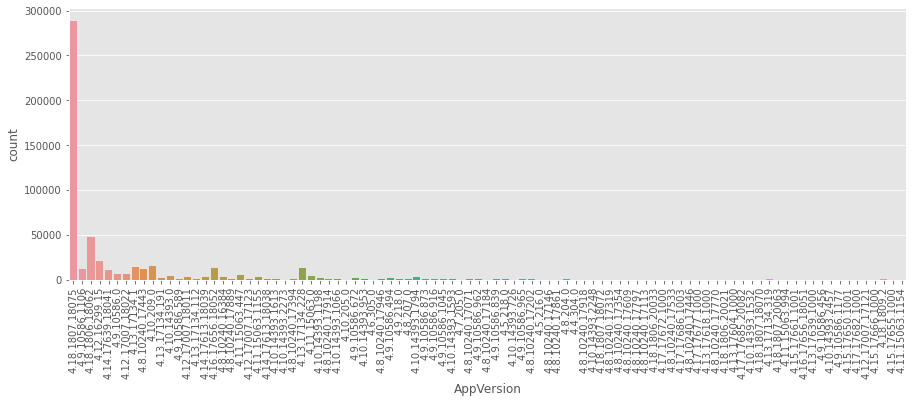

In [ ]:
descrp_cat(df_clean,'AppVersion',TARGET)

In [ ]:
test_2=pd.DataFrame(df_clean['AppVersion'].sort_values().unique())
test_2

0
0      4.10.14393.0
1   4.10.14393.1066
2   4.10.14393.1198
3   4.10.14393.1532
4   4.10.14393.1593
..              ...
90    4.9.10586.873
91    4.9.10586.916
92    4.9.10586.962
93    4.9.10586.965
94        4.9.218.0

[95 rows x 1 columns]

In [ ]:
test_2.columns = ['AppVersion']
test_2['AppVersion_Index'] =test_2.index 

In [ ]:
test_2

AppVersion  AppVersion_Index
0      4.10.14393.0                 0
1   4.10.14393.1066                 1
2   4.10.14393.1198                 2
3   4.10.14393.1532                 3
4   4.10.14393.1593                 4
..              ...               ...
90    4.9.10586.873                90
91    4.9.10586.916                91
92    4.9.10586.962                92
93    4.9.10586.965                93
94        4.9.218.0                94

[95 rows x 2 columns]

In [ ]:
df_clean= df_clean.merge(test_2, on ='AppVersion')

In [ ]:
df_clean.drop('AppVersion', axis = 1, inplace= True)

In [ ]:
df_clean.describe(include=np.number).T

count  ...           max
RtpStateBitfield                                   500000.0  ...  3.500000e+01
AVProductStatesIdentifier                          500000.0  ...  7.049200e+04
AVProductsInstalled                                500000.0  ...  5.000000e+00
HasTpm                                             500000.0  ...  1.000000e+00
CountryIdentifier                                  500000.0  ...  2.220000e+02
CityIdentifier                                     500000.0  ...  1.679580e+05
OrganizationIdentifier                             500000.0  ...  5.200000e+01
GeoNameIdentifier                                  500000.0  ...  2.960000e+02
LocaleEnglishNameIdentifier                        500000.0  ...  2.830000e+02
OsBuild                                            500000.0  ...  1.824200e+04
OsSuite                                            500000.0  ...  7.840000e+02
IsProtected                                        500000.0  ...  1.000000e+00
SMode                                              500000.0  ...  1.000000e+00
IeVerIdentifier                                    500000.0  ...  4.290000e+02
Firewall                                           500000.0  ...  1.000000e+00
Census_OEMNameIdentifier                           500000.0  ...  6.143000e+03
Census_OEMModelIdentifier                          500000.0  ...  3.454930e+05
Census_ProcessorCoreCount                          500000.0  ...  8.800000e+01
Census_ProcessorModelIdentifier                    500000.0  ...  4.472000e+03
Census_PrimaryDiskTotalCapacity                    500000.0  ...  4.768767e+07
Census_SystemVolumeTotalCapacity                   500000.0  ...  4.768710e+07
Census_HasOpticalDiskDrive                         500000.0  ...  1.000000e+00
Census_TotalPhysicalRAM                            500000.0  ...  3.932160e+05
Census_InternalPrimaryDiagonalDisplaySizeInInches  500000.0  ...  1.420000e+02
Census_InternalPrimaryDisplayResolutionHorizontal  500000.0  ...  1.152000e+04
Census_InternalPrimaryDisplayResolutionVertical    500000.0  ...  4.320000e+03
Census_InternalBatteryNumberOfCharges              500000.0  ...  4.294967e+09
Census_OSBuildNumber                               500000.0  ...  1.824200e+04
Census_OSBuildRevision                             500000.0  ...  1.906900e+04
Census_OSInstallLanguageIdentifier                 500000.0  ...  3.900000e+01
Census_OSUILocaleIdentifier                        500000.0  ...  1.620000e+02
Census_IsPortableOperatingSystem                   500000.0  ...  1.000000e+00
Census_ThresholdOptIn                              500000.0  ...  1.000000e+00
Census_FirmwareManufacturerIdentifier              500000.0  ...  1.084000e+03
Census_FirmwareVersionIdentifier                   500000.0  ...  7.209100e+04
Census_IsSecureBootEnabled                         500000.0  ...  1.000000e+00
Census_IsVirtualDevice                             500000.0  ...  1.000000e+00
Census_IsTouchEnabled                              500000.0  ...  1.000000e+00
Census_IsPenCapable                                500000.0  ...  1.000000e+00
Census_IsAlwaysOnAlwaysConnectedCapable            500000.0  ...  1.000000e+00
Wdft_IsGamer                                       500000.0  ...  1.000000e+00
Wdft_RegionIdentifier                              500000.0  ...  1.500000e+01
HasDetections                                      500000.0  ...  1.000000e+00
ProductName_win8defender                           500000.0  ...  1.000000e+00
EngineVersion_Index                                500000.0  ...  5.200000e+01
AppVersion_Index                                   500000.0  ...  9.400000e+01

[46 rows x 8 columns]

## AvSigVersion

'VALUE COUNTS'

AvSigVersion
1.273.1420.0          5771
1.263.48.0            5537
1.275.1140.0          5317
1.275.727.0           5214
1.273.371.0           4799
...                    ...
1.225.4092.0             1
1.225.1999.0             1
1.229.1509.0             1
1.225.4056.0             1
1.225.2794.0             1

[6455 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

AvSigVersion
count         500000
unique          6455
top     1.273.1420.0
freq            5771

'CROSSTAB'

HasDetections    0    1
AvSigVersion           
0.0.0.0          4    0
1.169.55.0       1    0
1.199.1615.0     1    2
1.207.1891.0     0    1
1.207.2950.0     3    3
...            ...  ...
1.277.51.0     241  170
1.277.58.0      51   25
1.277.62.0      45   35
1.277.64.0      33   27
1.277.67.0       6    1

[6455 rows x 2 columns]

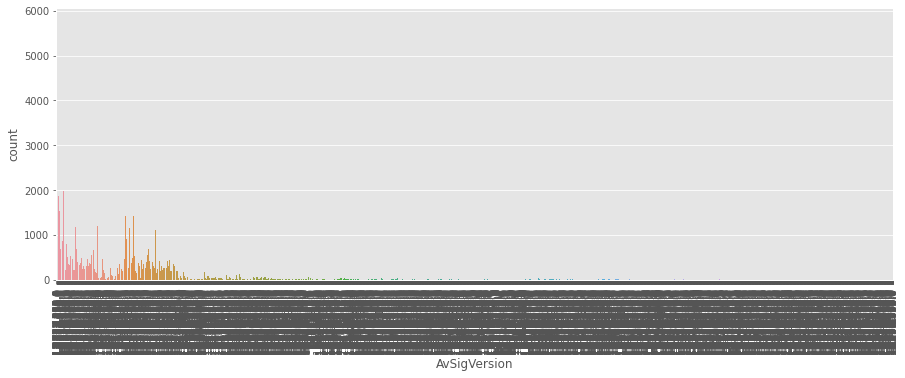

In [ ]:
descrp_cat(df_clean, 'AvSigVersion',TARGET)

In [ ]:
n_rows(df_clean,'AvSigVersion')

AvSigVersion_COUNT  AvSigVersion
1.273.1420.0                5771  1.273.1420.0
1.263.48.0                  5537    1.263.48.0
1.275.1140.0                5317  1.275.1140.0
1.275.727.0                 5214   1.275.727.0
1.273.371.0                 4799   1.273.371.0
...                          ...           ...
1.225.4092.0                   1  1.225.4092.0
1.225.1999.0                   1  1.225.1999.0
1.229.1509.0                   1  1.229.1509.0
1.225.4056.0                   1  1.225.4056.0
1.225.2794.0                   1  1.225.2794.0

[6455 rows x 2 columns]

In [ ]:
df_clean= df_clean.merge(n_rows(df_clean,'AvSigVersion'), on = 'AvSigVersion')

In [ ]:
df_clean.drop('AvSigVersion', axis= 1, inplace = True)

In [ ]:
df_clean.head(1)

MachineIdentifier  ...  AvSigVersion_COUNT
0  f1cd864e97bae82bdf96523e1a539121  ...                1043

[1 rows x 73 columns]

## Platform

'VALUE COUNTS'

Platform
windows10      483048
windows8        10825
windows7         5314
windows2016       813

'NULOS'

0

'DESCRIBE'

Platform
count      500000
unique          4
top     windows10
freq       483048

'CORR'

HasDetections
HasDetections            1.0

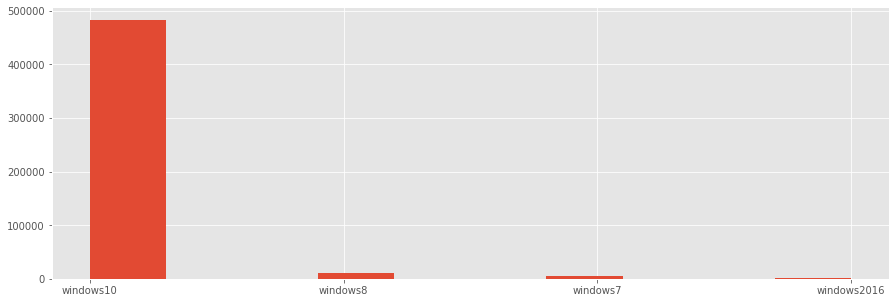

In [ ]:
descrp_num(df_clean, 'Platform',TARGET)

Label Encoder


In [ ]:
encoder= LabelEncoder()
df_clean['Platform_Id']= LabelEncoder().fit_transform(df_clean['Platform'])

In [ ]:
df_clean[['Platform_Id','Platform']].value_counts()

Platform_Id  Platform   
0            windows10      483048
3            windows8        10825
2            windows7         5314
1            windows2016       813
dtype: int64

In [ ]:
df_clean['Platform_Id'].value_counts()

0    483048
3     10825
2      5314
1       813
Name: Platform_Id, dtype: int64

In [ ]:
df_clean.drop('Platform', axis= 1, inplace = True)

## Processor

'VALUE COUNTS'

Processor
x64       454423
x86        45563
arm64         14

'NULOS'

0

'DESCRIBE'

Processor
count     500000
unique         3
top          x64
freq      454423

'CORR'

HasDetections
HasDetections            1.0

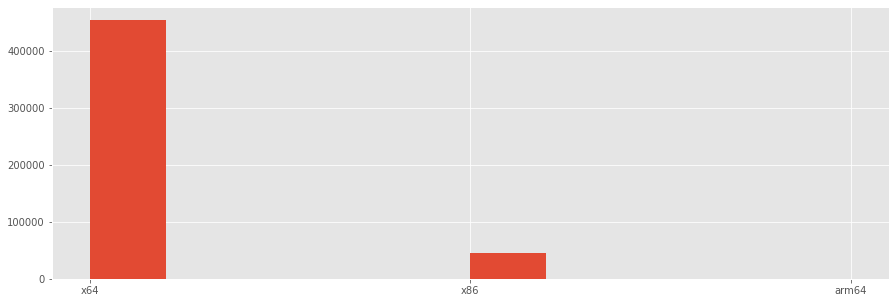

In [ ]:
descrp_num(df_clean, 'Processor', TARGET)

Agrupamos

In [ ]:
df_clean['Processor']=unific_cate(df_clean,'Processor',1)

In [ ]:
df_clean['Processor_x64']=(df_clean['Processor'] == 'x64').astype(int)

In [ ]:
df_clean['Processor_x64'].value_counts()

1    454423
0     45577
Name: Processor_x64, dtype: int64

In [ ]:
df_clean.drop('Processor', axis =1, inplace= True)

## OsVer

'VALUE COUNTS'

OsVer
10.0.0.0    483830
6.3.0.0      10818
6.1.1.0       5281
6.1.0.0         33
10.0.3.0        12
10.0.1.0         7
6.3.1.0          2
10.0.0.1         2
10.0.32.72       2
6.3.3.0          2
10.0.0.112       1
6.3.7.0          1
10.0.7.0         1
10.0.8.0         1
6.3.5.0          1
10.0.2.0         1
10.0.80.0        1
10.0.4.0         1
10.0.32.0        1
10.0.5.0         1
6.3.32.72        1

'NULOS'

0

'DESCRIBE'

OsVer
count     500000
unique        21
top     10.0.0.0
freq      483830

'CROSSTAB'

HasDetections       0       1
OsVer                        
10.0.0.0       242075  241755
10.0.0.1            0       2
10.0.0.112          0       1
10.0.1.0            2       5
10.0.2.0            0       1
10.0.3.0            3       9
10.0.32.0           0       1
10.0.32.72          2       0
10.0.4.0            1       0
10.0.5.0            0       1
10.0.7.0            0       1
10.0.8.0            0       1
10.0.80.0           1       0
6.1.0.0            23      10
6.1.1.0          2729    2552
6.3.0.0          5206    5612
6.3.1.0             1       1
6.3.3.0             2       0
6.3.32.72           1       0
6.3.5.0             1       0
6.3.7.0             0       1

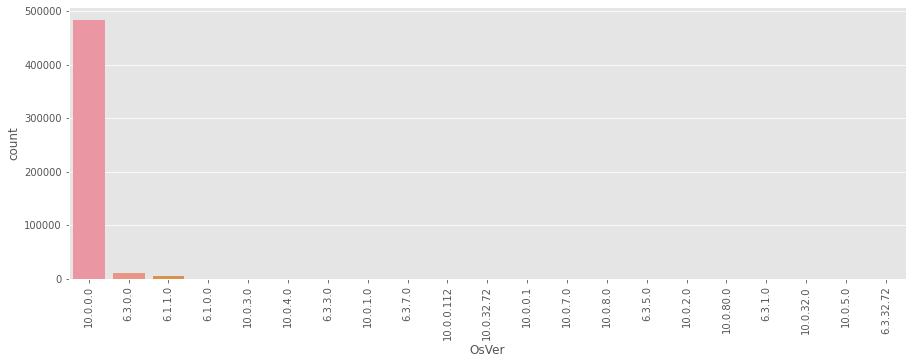

In [ ]:
descrp_cat(df_clean,'OsVer', TARGET)

La volvemos numérica para poder utilizar como punto de división del Development y Validation.

In [ ]:
test_1=pd.DataFrame(df_clean['OsVer'].sort_values().unique())
test_1

0
0     10.0.0.0
1     10.0.0.1
2   10.0.0.112
3     10.0.1.0
4     10.0.2.0
5     10.0.3.0
6    10.0.32.0
7   10.0.32.72
8     10.0.4.0
9     10.0.5.0
10    10.0.7.0
11    10.0.8.0
12   10.0.80.0
13     6.1.0.0
14     6.1.1.0
15     6.3.0.0
16     6.3.1.0
17     6.3.3.0
18   6.3.32.72
19     6.3.5.0
20     6.3.7.0

In [ ]:
test_1.columns = ['OsVer']
test_1['OsVer_Index'] =test_1.index 

In [ ]:
test_1

OsVer  OsVer_Index
0     10.0.0.0            0
1     10.0.0.1            1
2   10.0.0.112            2
3     10.0.1.0            3
4     10.0.2.0            4
5     10.0.3.0            5
6    10.0.32.0            6
7   10.0.32.72            7
8     10.0.4.0            8
9     10.0.5.0            9
10    10.0.7.0           10
11    10.0.8.0           11
12   10.0.80.0           12
13     6.1.0.0           13
14     6.1.1.0           14
15     6.3.0.0           15
16     6.3.1.0           16
17     6.3.3.0           17
18   6.3.32.72           18
19     6.3.5.0           19
20     6.3.7.0           20

In [ ]:
df_clean= df_clean.merge(test_1, on ='OsVer')

In [ ]:
df_clean.head(1)

MachineIdentifier  ...  OsVer_Index
0  f1cd864e97bae82bdf96523e1a539121  ...            0

[1 rows x 74 columns]

In [ ]:
df_clean.drop('OsVer', axis= 1, inplace= True)

## OHE 

In [ ]:
def OHE(col_name,dataframe):
  _dummy_dataset=pd.get_dummies(dataframe[col_name],prefix=col_name)
  dataframe = pd.concat([dataframe,_dummy_dataset],axis = 1)
  return dataframe.drop([col_name], axis = 1)

##OsPlatformSubRelease

'VALUE COUNTS'

OsPlatformSubRelease
rs4                       220779
rs3                       139901
rs2                        43352
rs1                        40717
th2                        22955
th1                        15014
windows8.1                 10825
windows7                    5314
prers5                      1143

'NULOS'

0

'DESCRIBE'

OsPlatformSubRelease
count                500000
unique                    9
top                     rs4
freq                 220779

'CROSSTAB'

HasDetections              0       1
OsPlatformSubRelease                
prers5                   640     503
rs1                    21869   18848
rs2                    22574   20778
rs3                    71166   68735
rs4                   105783  114996
th1                     7705    7309
th2                    12347   10608
windows7                2752    2562
windows8.1              5211    5614

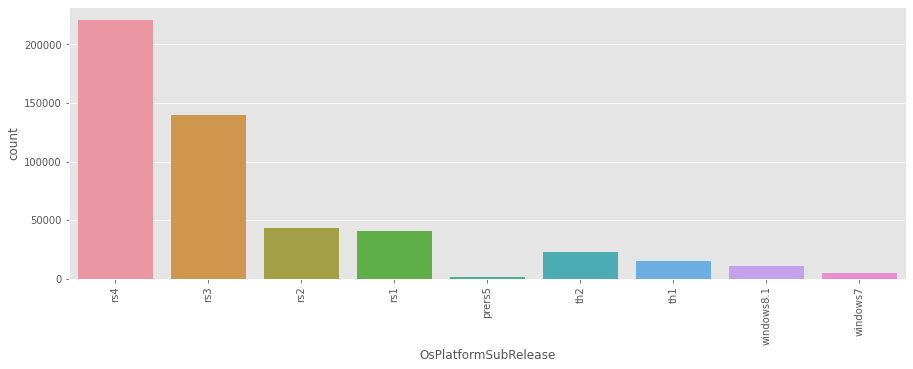

In [ ]:
descrp_cat(df_clean,'OsPlatformSubRelease', TARGET)

Vamos a aplicar OHE.

In [ ]:
OHE('OsPlatformSubRelease',df_clean)

MachineIdentifier  ...  OsPlatformSubRelease_windows8.1
0       f1cd864e97bae82bdf96523e1a539121  ...                                0
1       ccd1f947803b4fb01fe083ef73fca491  ...                                0
2       f045ba8adeb047ad57e477f413465428  ...                                0
3       231d5020f24627e1cf031a6ce72c8c11  ...                                0
4       d785fe91cfe91f246e3025dad169798c  ...                                0
...                                  ...  ...                              ...
499995  da750ba2364053258c8dd9e19612543a  ...                                1
499996  f3c75ed7cb47076b3217f56b21ba9ff1  ...                                1
499997  1a84c4668b7b35425704e120f5c591a2  ...                                0
499998  304d441735dd9c1f9d481bf3e64a7933  ...                                0
499999  b67ee7335d478732ce81fcfac7936f3d  ...                                1

[500000 rows x 81 columns]

In [ ]:
df_clean = OHE('OsPlatformSubRelease',df_clean)

##OsBuildLab 

'VALUE COUNTS'

OsBuildLab
17134.1.amd64fre.rs4_release.180410-1804                206436
16299.431.amd64fre.rs3_release_svc_escrow.18050...       69884
16299.15.amd64fre.rs3_release.170928-1534                53826
15063.0.amd64fre.rs2_release.170317-1834                 39908
17134.1.x86fre.rs4_release.180410-1804                   14334
...                                                        ...
9600.18379.x86fre.winblue_ltsb.160614-0600                   1
14393.1670.amd64fre.rs1_release_inmarket.170821...           1
17754.1.x86fre.rs5_release.180831-1429                       1
14393.1737.amd64fre.rs1_release_inmarket.170914...           1
7600.21980.amd64fre.win7_ldr.150318-1623                     1

[454 rows x 1 columns]

'NULOS'

1

'DESCRIBE'

OsBuildLab
count                                     499999
unique                                       453
top     17134.1.amd64fre.rs4_release.180410-1804
freq                                      206436

'CROSSTAB'

HasDetections                                          0     1
OsBuildLab                                                    
10240.16384.amd64fre.th1.150709-1700                 716   699
10240.16384.x86fre.th1.150709-1700                    75    56
10240.16387.amd64fre.th1_st1.150711-1429               5     2
10240.16393.amd64fre.th1_st1.150717-1719             162   134
10240.16393.x86fre.th1_st1.150717-1719                36    38
...                                                  ...   ...
9600.19101.amd64fre.winblue_ltsb_escrow.180718-...  1343  1796
9600.19101.x86fre.winblue_ltsb_escrow.180718-1800     99    65
9600.19125.amd64fre.winblue_ltsb.180812-0703         441   432
9600.19125.x86fre.winblue_ltsb.180812-0703            38    33
9600.19128.amd64fre.winblue_ltsb_escrow.180813-...     1     0

[453 rows x 2 columns]

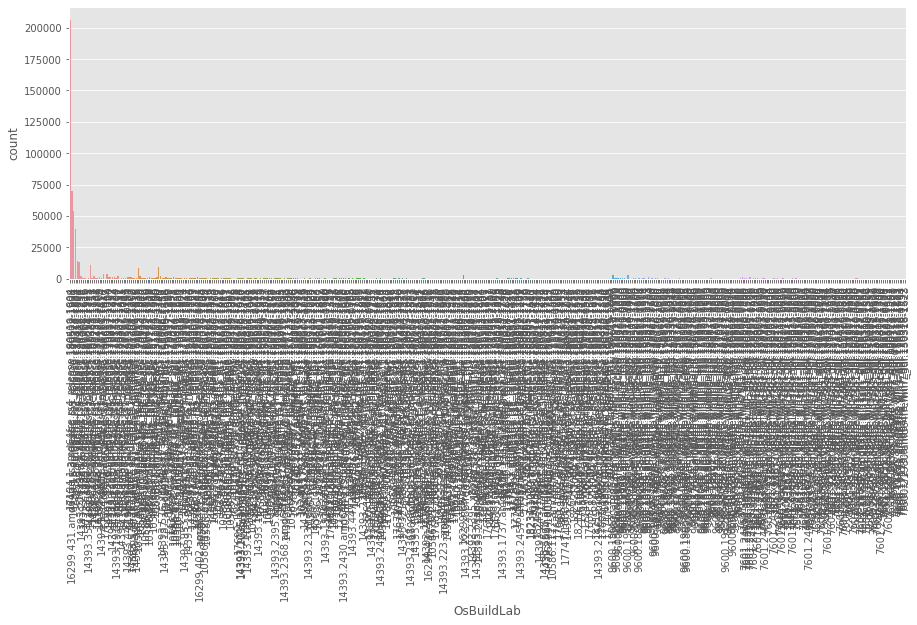

In [ ]:
descrp_cat(df_clean, 'OsBuildLab', TARGET)

La eliminamos porque tnemos la información en variables numéricas. (OsBuild, Census_OsBuildNumber, Census_OSBuildRevision,OSPlatform,Processor).

In [ ]:
df_clean.drop('OsBuildLab', axis = 1, inplace= True)

## OsBuild

'VALUE COUNTS'

OsBuild
17134   220779
16299   139901
15063    43352
14393    40717
10586    22955
10240    15014
9600     10825
7601      5281
17692      155
17738      134
17744      129
17758       86
17746       62
17713       60
17754       56
17751       53
17741       51
17755       45
17735       37
17686       36
17733       34
17763       33
7600        33
17760       31
17682       20
17677       17
18234       16
17672       15
18237       12
18242       12
17661        9
17666        8
17723        4
17634        4
17747        3
17618        3
17639        3
17730        3
17650        2
17655        2
17711        1
18219        1
17623        1
17749        1
17753        1
18214        1
17604        1
17704        1

'NULOS'

0

'DESCRIBE'

OsBuild
count  500000.000000
mean    15726.933842
std      2188.646069
min      7600.000000
25%     15063.000000
50%     16299.000000
75%     17134.000000
max     18242.000000

'CORR'

HasDetections   OsBuild
HasDetections       1.000000  0.024406
OsBuild             0.024406  1.000000

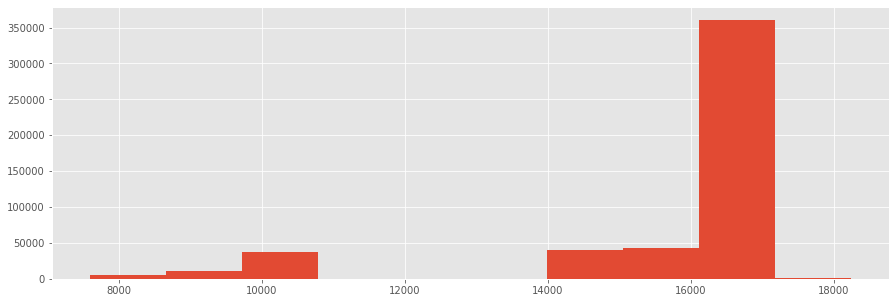

In [ ]:
descrp_num(df_clean, 'OsBuild', TARGET)

Mantenemos la Variable.

## Census_OSBuildNumber

'VALUE COUNTS'

Census_OSBuildNumber
17134                225979
16299                136572
15063                 44262
14393                 43702
10586                 33193
...                     ...
17723                     1
14421                     1
17618                     1
18214                     1
14971                     1

[61 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

Census_OSBuildNumber
count         500000.000000
mean           15841.372572
std             1959.440301
min             9600.000000
25%            15063.000000
50%            16299.000000
75%            17134.000000
max            18242.000000

'CORR'

HasDetections  Census_OSBuildNumber
HasDetections              1.000000              0.030039
Census_OSBuildNumber       0.030039              1.000000

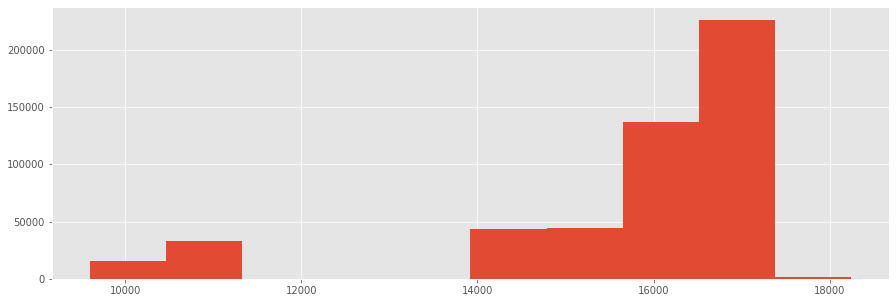

In [ ]:
descrp_num(df_clean, 'Census_OSBuildNumber', TARGET)

Mantenemos la variable.

## Census_OSBuildRevision

'VALUE COUNTS'

Census_OSBuildRevision
228                     79975
165                     50511
431                     30519
285                     26289
112                     19503
...                       ...
491                         1
456                         1
17446                       1
1230                        1
1005                        1

[242 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

Census_OSBuildRevision
count           500000.000000
mean               967.224762
std               2920.627724
min                  0.000000
25%                165.000000
50%                285.000000
75%                547.000000
max              19069.000000

'CORR'

HasDetections  Census_OSBuildRevision
HasDetections                1.000000               -0.009494
Census_OSBuildRevision      -0.009494                1.000000

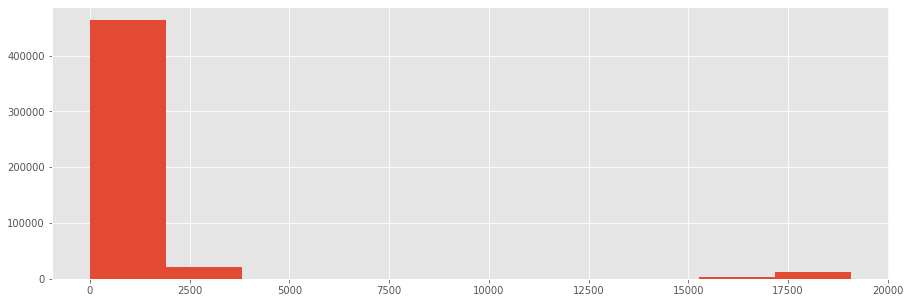

In [ ]:
descrp_num(df_clean, 'Census_OSBuildRevision', TARGET)

Mantenemos la variable.

## SkuEdition

'VALUE COUNTS'

SkuEdition
Home                 308567
Pro                  181042
Invalid                4423
Education              2321
Enterprise             1999
Enterprise LTSB        1141
Cloud                   309
Server                  198

'NULOS'

0

'DESCRIBE'

SkuEdition
count      500000
unique          8
top          Home
freq       308567

'CROSSTAB'

HasDetections         0       1
SkuEdition                     
Cloud               188     121
Education          1119    1202
Enterprise          964    1035
Enterprise LTSB     527     614
Home             156560  152007
Invalid            2354    2069
Pro               88189   92853
Server              146      52

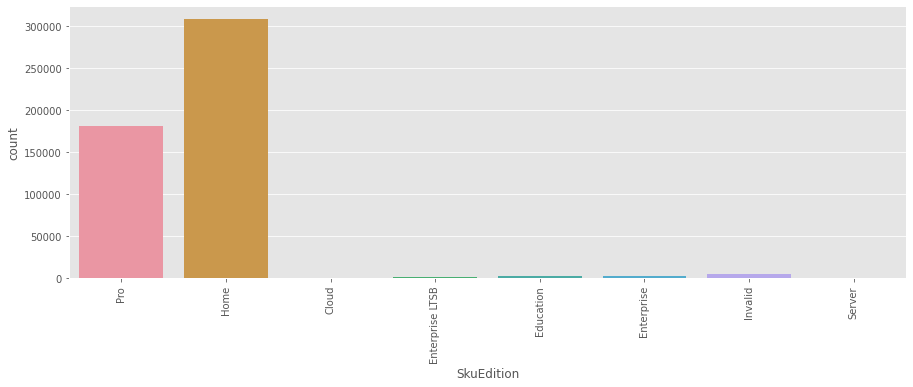

In [ ]:
descrp_cat(df_clean, 'SkuEdition', TARGET)

In [ ]:
OHE('SkuEdition', df_clean)

MachineIdentifier  ...  SkuEdition_Server
0       f1cd864e97bae82bdf96523e1a539121  ...                  0
1       ccd1f947803b4fb01fe083ef73fca491  ...                  0
2       f045ba8adeb047ad57e477f413465428  ...                  0
3       231d5020f24627e1cf031a6ce72c8c11  ...                  0
4       d785fe91cfe91f246e3025dad169798c  ...                  0
...                                  ...  ...                ...
499995  da750ba2364053258c8dd9e19612543a  ...                  0
499996  f3c75ed7cb47076b3217f56b21ba9ff1  ...                  0
499997  1a84c4668b7b35425704e120f5c591a2  ...                  0
499998  304d441735dd9c1f9d481bf3e64a7933  ...                  0
499999  b67ee7335d478732ce81fcfac7936f3d  ...                  0

[500000 rows x 87 columns]

In [ ]:
df_clean = OHE('SkuEdition', df_clean)

## PuaMode

'VALUE COUNTS'

PuaMode
NaN   499874
on       126

'NULOS'

499874

'DESCRIBE'

PuaMode
count      126
unique       1
top         on
freq       126

'CROSSTAB'

HasDetections   0   1
PuaMode              
on             31  95

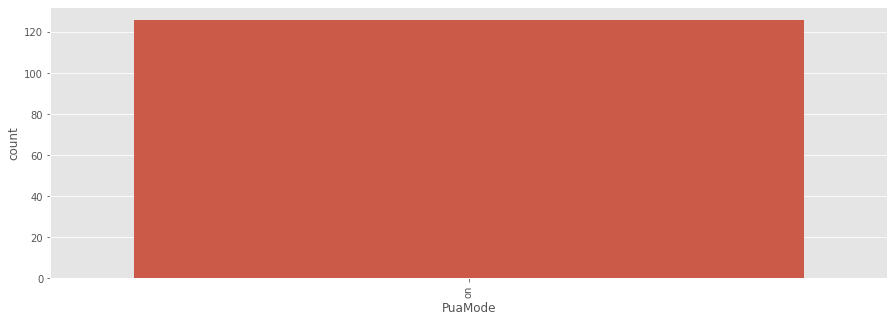

In [ ]:
descrp_cat(df_clean, 'PuaMode', TARGET)

In [ ]:
df_clean['PuaMode'].fillna('Nulos',inplace = True)

In [ ]:
df_clean['PuaMode'].value_counts()

Nulos    499874
on          126
Name: PuaMode, dtype: int64

In [ ]:
df_clean['PuaMode_ON']=(df_clean['PuaMode'] == 'on').astype(int)

In [ ]:
df_clean['PuaMode_ON'].value_counts()

0    499874
1       126
Name: PuaMode_ON, dtype: int64

In [ ]:
df_clean.drop('PuaMode', axis = 1, inplace = True)

## SmartScreen

'VALUE COUNTS'

SmartScreen
RequireAdmin       241594
NaN                178596
ExistsNotSet        58497
Off                 10388
Warn                 7530
Prompt               1950
Block                1274
off                    75
On                     53
&#x02;                 20
&#x01;                 14
on                      8
requireadmin            1

'NULOS'

178596

'DESCRIBE'

SmartScreen
count         321404
unique            12
top     RequireAdmin
freq          241594

'CROSSTAB'

HasDetections       0       1
SmartScreen                  
&#x01;              8       6
&#x02;              9      11
Block             634     640
ExistsNotSet    11382   47115
Off              5333    5055
On                 17      36
Prompt           1022     928
RequireAdmin   135704  105890
Warn             3224    4306
off                32      43
on                  4       4
requireadmin        1       0

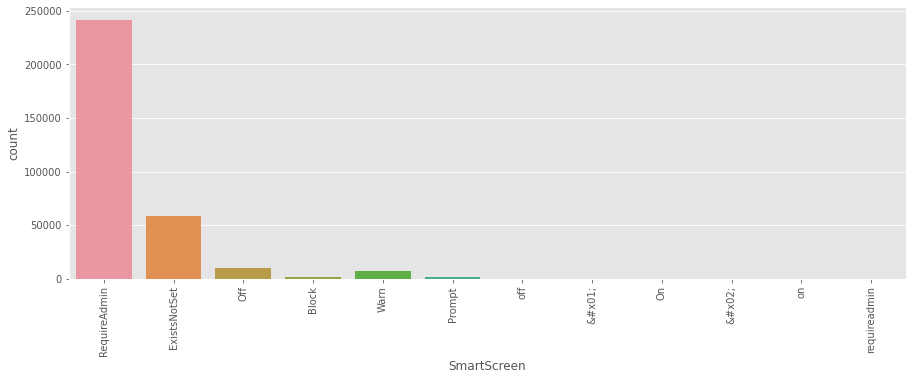

In [ ]:
descrp_cat(df_clean, 'SmartScreen', TARGET)

In [ ]:
df_clean['SmartScreen'].fillna('nulos', inplace = True)

In [ ]:
df_clean = OHE('SmartScreen',df_clean)

## Census_MDC2FormFactor

'VALUE COUNTS'

Census_MDC2FormFactor
Notebook                     320948
Desktop                      109527
Convertible                   22369
Detachable                    16802
AllInOne                      16372
PCOther                        7800
LargeTablet                    3645
SmallTablet                    1797
SmallServer                     496
MediumServer                    192
LargeServer                      50
ServerOther                       2

'NULOS'

0

'DESCRIBE'

Census_MDC2FormFactor
count                 500000
unique                    12
top                 Notebook
freq                  320948

'CROSSTAB'

HasDetections               0       1
Census_MDC2FormFactor                
AllInOne                 7988    8384
Convertible             11344   11025
Desktop                 52221   57306
Detachable              10451    6351
LargeServer                40      10
LargeTablet              2507    1138
MediumServer              130      62
Notebook               159537  161411
PCOther                  4085    3715
ServerOther                 2       0
SmallServer               305     191
SmallTablet              1437     360

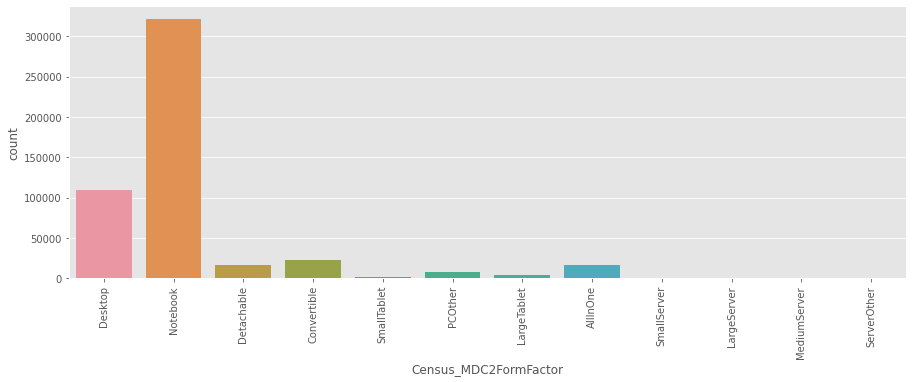

In [ ]:
descrp_cat(df_clean, 'Census_MDC2FormFactor', TARGET)

Vamos a agrupar las últimas 4 categorías por su poco peso.

In [ ]:
df_clean['Census_MDC2FormFactor']=unific_cate(df_clean, 'Census_MDC2FormFactor',8)

In [ ]:
df_clean['Census_MDC2FormFactor'].value_counts()

Notebook       320948
Desktop        109527
Convertible     22369
Detachable      16802
AllInOne        16372
PCOther          7800
LargeTablet      3645
SmallTablet      1797
Otros             740
Name: Census_MDC2FormFactor, dtype: int64

Ahora hacemos un OHE

In [ ]:
df_clean = OHE('Census_MDC2FormFactor',df_clean)

## Census_DeviceFamily

'VALUE COUNTS'

Census_DeviceFamily
Windows.Desktop               499183
Windows.Server                   816
Windows                            1

'NULOS'

0

'DESCRIBE'

Census_DeviceFamily
count               500000
unique                   3
top        Windows.Desktop
freq                499183

'CROSSTAB'

HasDetections             0       1
Census_DeviceFamily                
Windows                   1       0
Windows.Desktop      249532  249651
Windows.Server          514     302

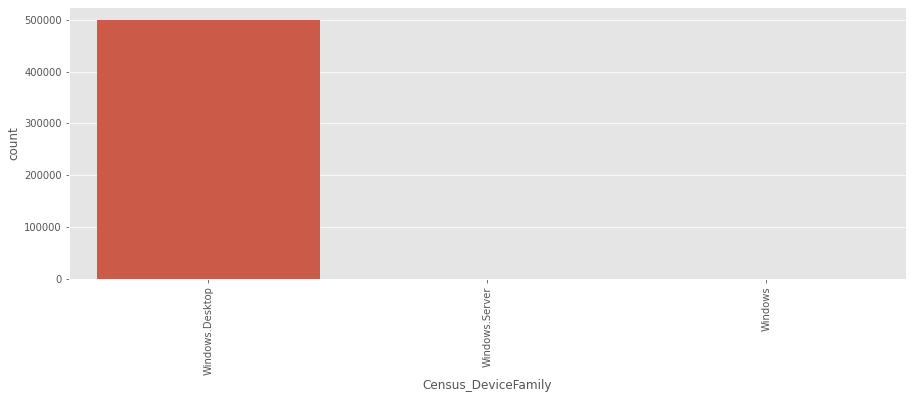

In [ ]:
descrp_cat(df_clean, 'Census_DeviceFamily', TARGET)

In [ ]:
unific_cate(df_clean, 'Census_DeviceFamily',1)

0         Windows.Desktop
1         Windows.Desktop
2         Windows.Desktop
3         Windows.Desktop
4         Windows.Desktop
               ...       
499995    Windows.Desktop
499996    Windows.Desktop
499997    Windows.Desktop
499998    Windows.Desktop
499999    Windows.Desktop
Name: Census_DeviceFamily, Length: 500000, dtype: category
Categories (2, object): ['Windows.Desktop', 'Otros']

In [ ]:
df_clean['Census_DeviceFamily']=unific_cate(df_clean, 'Census_DeviceFamily',1)

In [ ]:
df_clean['Census_DeviceFamily'].value_counts()

Windows.Desktop    499183
Otros                 817
Name: Census_DeviceFamily, dtype: int64

In [ ]:
df_clean['Census_DeviceFamily_Windows.Desktop'] = (df_clean['Census_DeviceFamily'] == 'Windows.Desktop').astype(int)

In [ ]:
df_clean['Census_DeviceFamily_Windows.Desktop'].value_counts()

1    499183
0       817
Name: Census_DeviceFamily_Windows.Desktop, dtype: int64

In [ ]:
df_clean.drop('Census_DeviceFamily',axis =1, inplace = True)

## Census_ProcessorClass

In [ ]:
descrp_cat(df_clean, 'Census_ProcessorClass', TARGET)

'VALUE COUNTS'

Census_ProcessorClass
NaN                  497918
mid                    1196
low                     546
high                    340

'NULOS'

497918

'DESCRIBE'

Census_ProcessorClass
count                   2082
unique                     3
top                      mid
freq                    1196

'CROSSTAB'

HasDetections            0    1
Census_ProcessorClass          
high                   129  211
low                    259  287
mid                    517  679

In [ ]:
df_clean['Census_ProcessorClass'].fillna('nulos', inplace = True)

Aplicamos OHE

In [ ]:
df_clean = OHE('Census_ProcessorClass', df_clean)

## Census_PrimaryDiskTypeName

'VALUE COUNTS'

Census_PrimaryDiskTypeName
HDD                              325429
SSD                              138155
UNKNOWN                           20083
Unspecified                       15624
NaN                                 709

'NULOS'

709

'DESCRIBE'

Census_PrimaryDiskTypeName
count                      499291
unique                          4
top                           HDD
freq                       325429

'CROSSTAB'

HasDetections                    0       1
Census_PrimaryDiskTypeName                
HDD                         160667  164762
SSD                          69334   68821
UNKNOWN                      11064    9019
Unspecified                   8624    7000

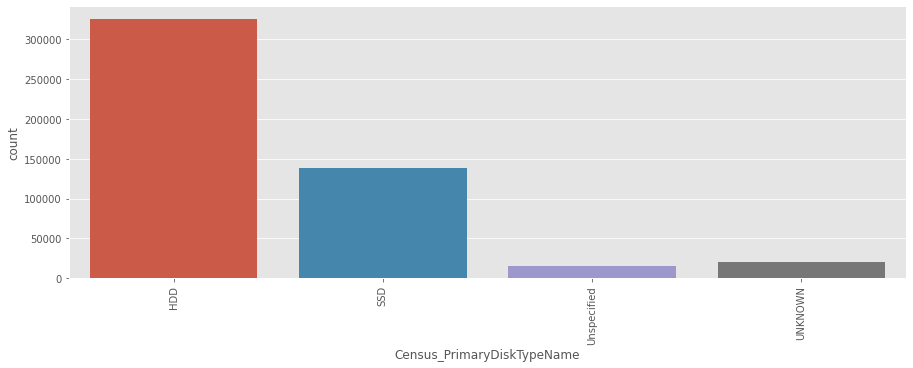

In [ ]:
descrp_cat(df_clean, 'Census_PrimaryDiskTypeName', TARGET)

In [ ]:
df_clean.head()

MachineIdentifier  ...  Census_ProcessorClass_nulos
0  f1cd864e97bae82bdf96523e1a539121  ...                            1
1  ccd1f947803b4fb01fe083ef73fca491  ...                            1
2  f045ba8adeb047ad57e477f413465428  ...                            1
3  231d5020f24627e1cf031a6ce72c8c11  ...                            1
4  d785fe91cfe91f246e3025dad169798c  ...                            1

[5 rows x 110 columns]

Agrupamos todos los desconocidos y nulos.

In [ ]:
unific_cate(df_clean,'Census_PrimaryDiskTypeName',2)

0           HDD
1           HDD
2           SSD
3           HDD
4           SSD
          ...  
499995      HDD
499996    Otros
499997      HDD
499998      HDD
499999      HDD
Name: Census_PrimaryDiskTypeName, Length: 500000, dtype: category
Categories (3, object): ['HDD', 'SSD', 'Otros']

In [ ]:
df_clean['Census_PrimaryDiskTypeName']= unific_cate(df_clean,'Census_PrimaryDiskTypeName',2)

In [ ]:
df_clean['Census_PrimaryDiskTypeName'].value_counts()


HDD      325429
SSD      138155
Otros     36416
Name: Census_PrimaryDiskTypeName, dtype: int64

In [ ]:
df_clean = OHE('Census_PrimaryDiskTypeName',df_clean)

## Census_ChassisTypeName

'VALUE COUNTS'

Census_ChassisTypeName
Notebook                             294232
Desktop                              104979
Laptop                                38261
Portable                              20181
AllinOne                              11407
MiniTower                              4849
Convertible                            4685
Other                                  4215
UNKNOWN                                3695
Detachable                             2930
LowProfileDesktop                      2878
HandHeld                               2652
SpaceSaving                            1689
Tablet                                  730
Tower                                   692
Unknown                                 575
MainServerChassis                       512
MiniPC                                  261
LunchBox                                224
RackMountChassis                        189
SubNotebook                              47
BusExpansionChassis                      38
NaN                                      37
30                                       11
StickPC                                   7
0                                         5
35                                        3
PizzaBox                                  3
MultisystemChassis                        3
Blade                                     3
SubChassis                                2
31                                        2
ExpansionChassis                          1
32                                        1
25                                        1

'NULOS'

37

'DESCRIBE'

Census_ChassisTypeName
count                  499963
unique                     34
top                  Notebook
freq                   294232

'CROSSTAB'

HasDetections                0       1
Census_ChassisTypeName                
0                            3       2
25                           1       0
30                           8       3
31                           0       2
32                           0       1
35                           2       1
AllinOne                  5576    5831
Blade                        3       0
BusExpansionChassis         23      15
Convertible               2433    2252
Desktop                  49829   55150
Detachable                1910    1020
ExpansionChassis             1       0
HandHeld                  1868     784
Laptop                   19397   18864
LowProfileDesktop         1397    1481
LunchBox                   122     102
MainServerChassis          284     228
MiniPC                     172      89
MiniTower                 2252    2597
MultisystemChassis           2       1
Notebook                146962  147270
Other                     3064    1151
PizzaBox                     2       1
Portable                 10485    9696
RackMountChassis           127      62
SpaceSaving                882     807
StickPC                      7       0
SubChassis                   1       1
SubNotebook                 30      17
Tablet                     467     263
Tower                      330     362
UNKNOWN                   2059    1636
Unknown                    328     247

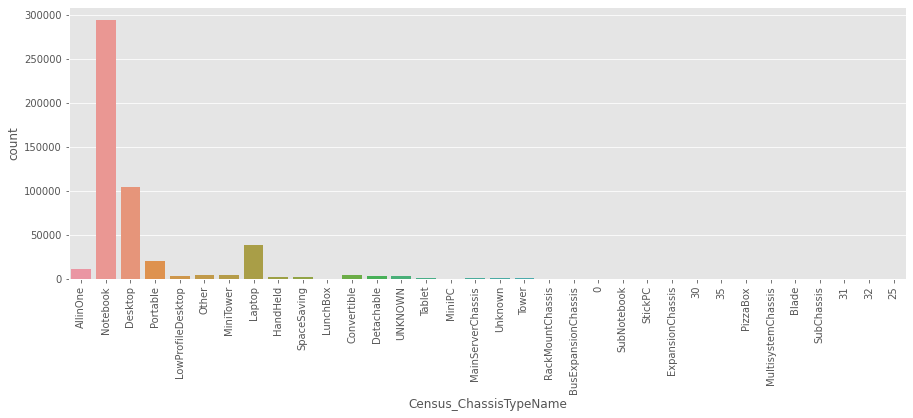

In [ ]:
descrp_cat(df_clean, 'Census_ChassisTypeName', TARGET)

In [ ]:
df_clean['Census_ChassisTypeName'].fillna('nulos', inplace= True)

In [ ]:
unific_cate(df_clean, 'Census_ChassisTypeName', 7)

0         AllinOne
1         Notebook
2         Notebook
3         Notebook
4         Notebook
            ...   
499995     Desktop
499996     Desktop
499997    Portable
499998    Notebook
499999      Laptop
Name: Census_ChassisTypeName, Length: 500000, dtype: category
Categories (8, object): ['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower',
                         'Convertible', 'Otros']

In [ ]:
df_clean['Census_ChassisTypeName'] = unific_cate(df_clean, 'Census_ChassisTypeName', 7)

In [ ]:
df_clean = OHE('Census_ChassisTypeName', df_clean)

## Census_PowerPlatformRoleName

'VALUE COUNTS'

Census_PowerPlatformRoleName
Mobile                                   346378
Desktop                                  116054
Slate                                     27475
Workstation                                6235
SOHOServer                                 2062
UNKNOWN                                    1172
EnterpriseServer                            406
AppliancePC                                 212
PerformanceServer                             4
NaN                                           2

'NULOS'

2

'DESCRIBE'

Census_PowerPlatformRoleName
count                        499998
unique                            9
top                          Mobile
freq                         346378

'CROSSTAB'

HasDetections                      0       1
Census_PowerPlatformRoleName                
AppliancePC                      166      46
Desktop                        55112   60942
EnterpriseServer                 229     177
Mobile                        172468  173910
PerformanceServer                  1       3
SOHOServer                      1038    1024
Slate                          17393   10082
UNKNOWN                          601     571
Workstation                     3037    3198

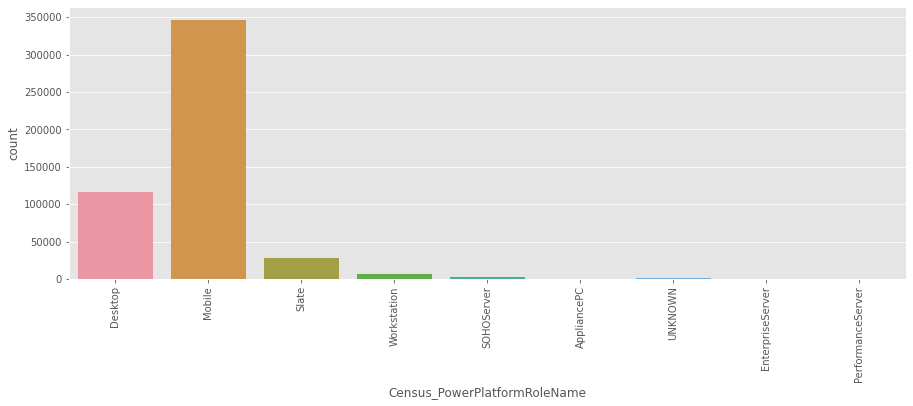

In [ ]:
descrp_cat(df_clean, 'Census_PowerPlatformRoleName', TARGET)

Elimino los nulos porque no representan peso.

In [ ]:
df_clean['Census_PowerPlatformRoleName'].dropna( inplace = True)

In [ ]:
len(df_clean['Census_PowerPlatformRoleName'].value_counts())

9

In [ ]:
df_clean['Census_PowerPlatformRoleName'] = unific_cate(df_clean, 'Census_PowerPlatformRoleName',5)

In [ ]:
df_clean = OHE ('Census_PowerPlatformRoleName',df_clean)

## Census_InternalBatteryType

'VALUE COUNTS'

Census_InternalBatteryType
NaN                       355603
lion                      113500
li-i                       13855
#                          10176
lip                         3326
liio                        1814
li p                         466
li                           356
nimh                         272
real                         162
bq20                         143
pbac                         130
vbox                          89
lgi0                          29
unkn                          19
lipo                          13
lhp0                          12
ithi                           7
4cel                           6
ram                            5
batt                           3
bad                            3
lipp                           3
virt                           2
a132                           2
icp3                           1
li-l                           1
3ion                           1
lgl0                           1

'NULOS'

355603

'DESCRIBE'

Census_InternalBatteryType
count                      144397
unique                         28
top                          lion
freq                       113500

'CROSSTAB'

HasDetections                   0      1
Census_InternalBatteryType              
#                            4855   5321
3ion                            1      0
4cel                            5      1
a132                            1      1
bad                             2      1
batt                            3      0
bq20                          105     38
icp3                            0      1
ithi                            5      2
lgi0                           12     17
lgl0                            0      1
lhp0                            8      4
li                            202    154
li p                          248    218
li-i                         7137   6718
li-l                            0      1
liio                          984    830
lion                        58785  54715
lip                          1535   1791
lipo                            7      6
lipp                            1      2
nimh                          154    118
pbac                           65     65
ram                             4      1
real                           77     85
unkn                            8     11
vbox                           67     22
virt                            2      0

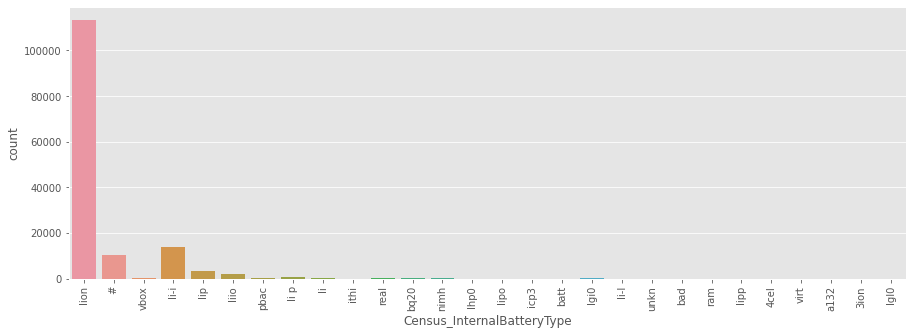

In [ ]:
descrp_cat(df_clean, 'Census_InternalBatteryType', TARGET)

In [ ]:
df_clean['Census_InternalBatteryType'].fillna('nulos_', inplace = True)

In [ ]:
df_clean['Census_InternalBatteryType'] = unific_cate(df_clean, 'Census_InternalBatteryType',2)

In [ ]:
df_clean['Census_InternalBatteryType'].value_counts()

nulos_    355603
lion      113500
Otros      30897
Name: Census_InternalBatteryType, dtype: int64

In [ ]:
df_clean = OHE('Census_InternalBatteryType',df_clean)

## Census_OSVersion

'VALUE COUNTS'

Census_OSVersion
10.0.17134.228              79975
10.0.17134.165              50511
10.0.16299.431              30519
10.0.17134.285              26289
10.0.17134.112              19501
...                           ...
10.0.17753.1                    1
10.0.17004.1000                 1
10.0.17749.1000                 1
10.0.17604.1000                 1
10.0.14971.1000                 1

[305 rows x 1 columns]

'NULOS'

0

'DESCRIBE'

Census_OSVersion
count            500000
unique              305
top      10.0.17134.228
freq              79975

'CROSSTAB'

HasDetections       0    1
Census_OSVersion          
10.0.10240.16384  785  714
10.0.10240.16387    2    0
10.0.10240.16389    1    1
10.0.10240.16393    0    2
10.0.10240.16394    3    0
...               ...  ...
10.0.18219.1000     0    1
10.0.18234.1000     9    5
10.0.18237.1000     8    6
10.0.18242.1000     5    8
6.3.9600.19069      1    0

[305 rows x 2 columns]

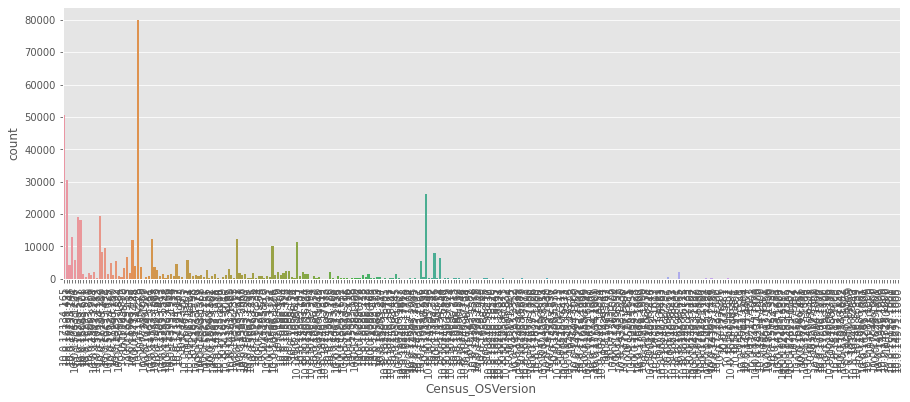

In [ ]:
descrp_cat(df_clean, 'Census_OSVersion', TARGET)

In [ ]:
n_rows(df_clean, 'Census_OSVersion')

Census_OSVersion_COUNT Census_OSVersion
10.0.17134.228                    79975   10.0.17134.228
10.0.17134.165                    50511   10.0.17134.165
10.0.16299.431                    30519   10.0.16299.431
10.0.17134.285                    26289   10.0.17134.285
10.0.17134.112                    19501   10.0.17134.112
...                                 ...              ...
10.0.17753.1                          1     10.0.17753.1
10.0.17004.1000                       1  10.0.17004.1000
10.0.17749.1000                       1  10.0.17749.1000
10.0.17604.1000                       1  10.0.17604.1000
10.0.14971.1000                       1  10.0.14971.1000

[305 rows x 2 columns]

In [ ]:
df_clean= df_clean.merge(n_rows(df_clean,'Census_OSVersion'), on = 'Census_OSVersion')

In [ ]:
df_clean.drop('Census_OSVersion', axis = 1, inplace = True)

## Census_OSArchitecture

'VALUE COUNTS'

Census_OSArchitecture
amd64                 454435
x86                    45551
arm64                     14

'NULOS'

0

'DESCRIBE'

Census_OSArchitecture
count                 500000
unique                     3
top                    amd64
freq                  454435

'CROSSTAB'

HasDetections               0       1
Census_OSArchitecture                
amd64                  222168  232267
arm64                      14       0
x86                     27865   17686

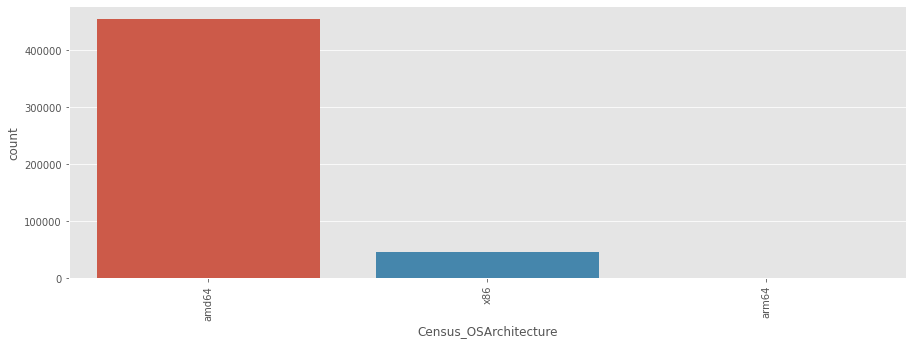

In [ ]:
descrp_cat(df_clean, 'Census_OSArchitecture', TARGET)

In [ ]:
df_clean = OHE ('Census_OSArchitecture', df_clean)

## Census_OSBranch

'VALUE COUNTS'

Census_OSBranch
rs4_release                         226001
rs3_release                          69216
rs3_release_svc_escrow               67027
rs2_release                          44264
rs1_release                          43705
th2_release                          18298
th2_release_sec                      14895
th1_st1                              10822
th1                                   4284
rs5_release                            839
rs3_release_svc_escrow_im              329
rs_prerelease                          184
rs_prerelease_flt                      132
rs5_release_sigma                        3
winblue_ltsb_escrow                      1

'NULOS'

0

'DESCRIBE'

Census_OSBranch
count           500000
unique              15
top        rs4_release
freq            226001

'CROSSTAB'

HasDetections                   0       1
Census_OSBranch                          
rs1_release                 23383   20322
rs2_release                 23034   21230
rs3_release                 37040   32176
rs3_release_svc_escrow      32455   34572
rs3_release_svc_escrow_im     197     132
rs4_release                107993  118008
rs5_release                   475     364
rs5_release_sigma               2       1
rs_prerelease                 108      76
rs_prerelease_flt              63      69
th1                          2392    1892
th1_st1                      5371    5451
th2_release                  9276    9022
th2_release_sec              8257    6638
winblue_ltsb_escrow             1       0

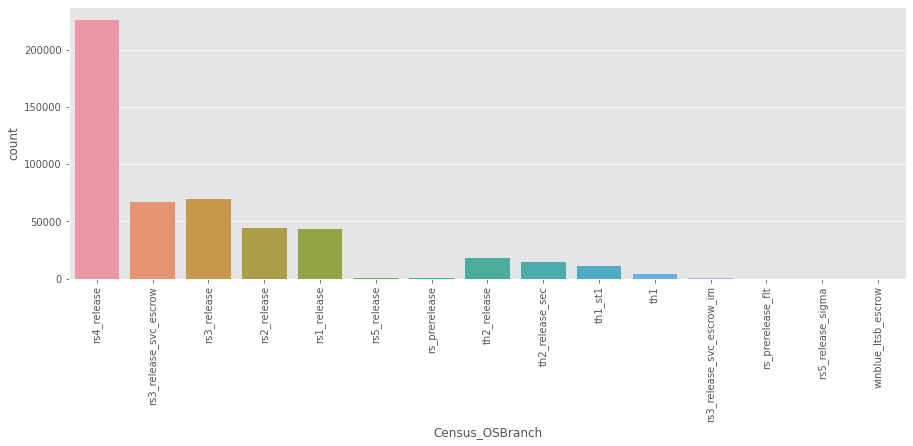

In [ ]:
descrp_cat(df_clean, 'Census_OSBranch', TARGET)

In [ ]:
df_clean = OHE('Census_OSBranch',df_clean)

## Census_OSEdition

'VALUE COUNTS'

Census_OSEdition
Core                                194469
Professional                        175808
CoreSingleLanguage                  108696
CoreCountrySpecific                   9275
ProfessionalEducation                 3100
Education                             2310
Enterprise                            2055
ProfessionalN                         1624
EnterpriseS                           1108
ServerStandard                         584
Cloud                                  336
CoreN                                  251
ServerStandardEval                     151
EducationN                              61
ServerDatacenterEval                    47
EnterpriseSN                            47
ServerSolution                          34
EnterpriseN                             28
ProfessionalEducationN                  12
ProfessionalWorkstation                  2
ProfessionalWorkstationN                 1
CloudN                                   1

'NULOS'

0

'DESCRIBE'

Census_OSEdition
count            500000
unique               22
top                Core
freq             194469

'CROSSTAB'

HasDetections                  0      1
Census_OSEdition                       
Cloud                        202    134
CloudN                         1      0
Core                      102803  91666
CoreCountrySpecific         4520   4755
CoreN                        143    108
CoreSingleLanguage         51108  57588
Education                   1100   1210
EducationN                    33     28
Enterprise                   990   1065
EnterpriseN                   12     16
EnterpriseS                  525    583
EnterpriseSN                  12     35
Professional               85919  89889
ProfessionalEducation       1405   1695
ProfessionalEducationN         8      4
ProfessionalN                751    873
ProfessionalWorkstation        1      1
ProfessionalWorkstationN       0      1
ServerDatacenterEval          32     15
ServerSolution                21     13
ServerStandard               347    237
ServerStandardEval           114     37

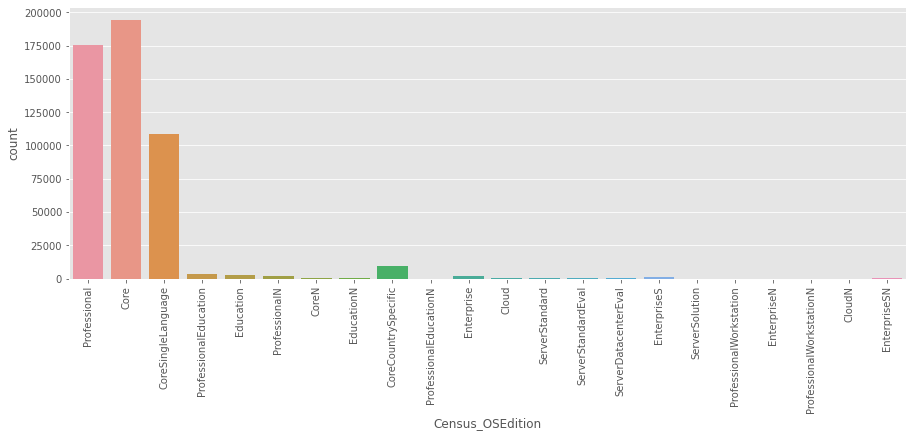

In [ ]:
descrp_cat(df_clean, 'Census_OSEdition', TARGET)

In [ ]:
df_clean['Census_OSEdition'] = unific_cate(df_clean, 'Census_OSEdition', 12)

In [ ]:
df_clean['Census_OSEdition'].value_counts().sum()

500000

In [ ]:
 df_clean= OHE('Census_OSEdition', df_clean)

## Census_OSSkuName

In [ ]:
descrp_cat(df_clean, 'Census_OSSkuName', TARGET)

'VALUE COUNTS'

Census_OSSkuName
CORE                                    194464
PROFESSIONAL                            178947
CORE_SINGLELANGUAGE                     108674
CORE_COUNTRYSPECIFIC                      9257
EDUCATION                                 2313
ENTERPRISE                                2063
PROFESSIONAL_N                            1634
ENTERPRISE_S                              1107
STANDARD_SERVER                            584
CLOUD                                      332
CORE_N                                     251
STANDARD_EVALUATION_SERVER                 151
EDUCATION_N                                 61
ENTERPRISE_S_N                              48
DATACENTER_EVALUATION_SERVER                47
SB_SOLUTION_SERVER                          34
ENTERPRISE_N                                28
PRO_WORKSTATION                              2
PRO_WORKSTATION_N                            1
UNLICENSED                                   1
CLOUDN                                       1

'NULOS'

0

'DESCRIBE'

Census_OSSkuName
count            500000
unique               21
top                CORE
freq             194464

'CROSSTAB'

HasDetections                      0      1
Census_OSSkuName                           
CLOUD                            199    133
CLOUDN                             1      0
CORE                          102798  91666
CORE_COUNTRYSPECIFIC            4514   4743
CORE_N                           143    108
CORE_SINGLELANGUAGE            51096  57578
DATACENTER_EVALUATION_SERVER      32     15
EDUCATION                       1100   1213
EDUCATION_N                       33     28
ENTERPRISE                       996   1067
ENTERPRISE_N                      12     16
ENTERPRISE_S                     524    583
ENTERPRISE_S_N                    13     35
PROFESSIONAL                   87344  91603
PROFESSIONAL_N                   759    875
PRO_WORKSTATION                    1      1
PRO_WORKSTATION_N                  0      1
SB_SOLUTION_SERVER                21     13
STANDARD_EVALUATION_SERVER       114     37
STANDARD_SERVER                  347    237
UNLICENSED                         0      1

In [ ]:
df_clean['Census_OSSkuName'] = unific_cate(df_clean, 'Census_OSSkuName', 11)

In [ ]:
df_clean = OHE('Census_OSSkuName', df_clean)

## Census_OSInstallTypeName

'VALUE COUNTS'

Census_OSInstallTypeName
UUPUpgrade                        146780
IBSClean                           92403
Update                             88892
Upgrade                            70013
Other                              46960
Reset                              36510
Refresh                            11540
Clean                               3885
CleanPCRefresh                      3017

'NULOS'

0

'DESCRIBE'

Census_OSInstallTypeName
count                    500000
unique                        9
top                  UUPUpgrade
freq                     146780

'CROSSTAB'

HasDetections                 0      1
Census_OSInstallTypeName              
Clean                      1853   2032
CleanPCRefresh             1622   1395
IBSClean                  44099  48304
Other                     24551  22409
Refresh                    6214   5326
Reset                     18905  17605
UUPUpgrade                69651  77129
Update                    46393  42499
Upgrade                   36759  33254

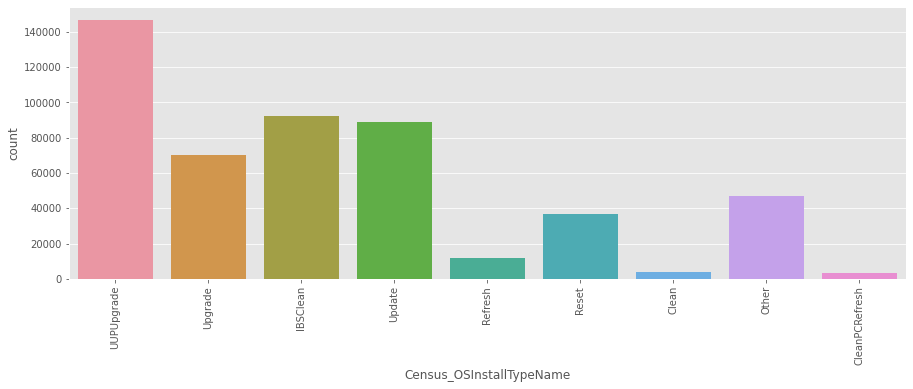

In [ ]:
descrp_cat(df_clean, 'Census_OSInstallTypeName', TARGET)

In [ ]:
df_clean = OHE('Census_OSInstallTypeName', df_clean)

## Census_OSWUAutoUpdateOptionsName

'VALUE COUNTS'

Census_OSWUAutoUpdateOptionsName
FullAuto                                                         222482
UNKNOWN                                                          140961
Notify                                                           113507
AutoInstallAndRebootAtMaintenanceTime                             20731
Off                                                                1506
DownloadNotify                                                      813

'NULOS'

0

'DESCRIBE'

Census_OSWUAutoUpdateOptionsName
count                            500000
unique                                6
top                            FullAuto
freq                             222482

'CROSSTAB'

HasDetections                               0       1
Census_OSWUAutoUpdateOptionsName                     
AutoInstallAndRebootAtMaintenanceTime   10675   10056
DownloadNotify                            512     301
FullAuto                               107675  114807
Notify                                  59640   53867
Off                                       774     732
UNKNOWN                                 70771   70190

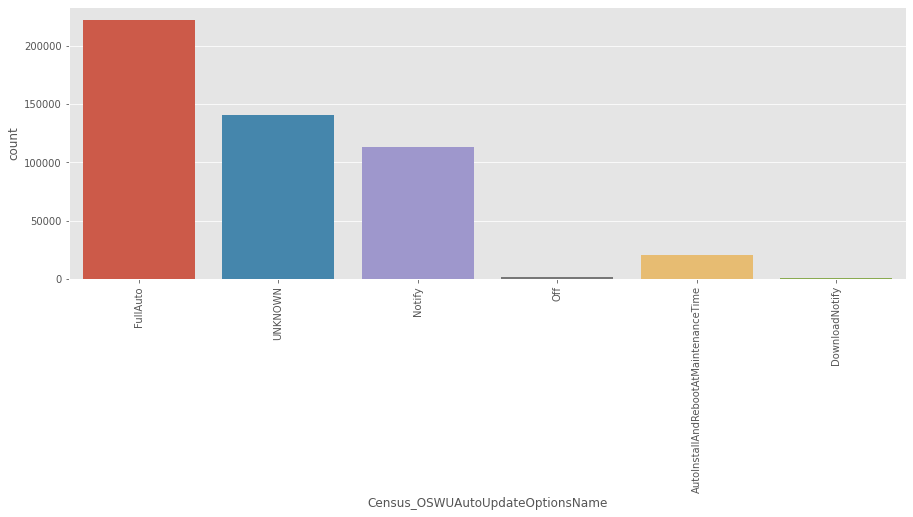

In [ ]:
descrp_cat(df_clean, 'Census_OSWUAutoUpdateOptionsName', TARGET)

In [ ]:
df_clean = OHE('Census_OSWUAutoUpdateOptionsName', df_clean)

## Census_GenuineStateName

'VALUE COUNTS'

Census_GenuineStateName
IS_GENUINE                        441402
INVALID_LICENSE                    44990
OFFLINE                            12834
UNKNOWN                              774

'NULOS'

0

'DESCRIBE'

Census_GenuineStateName
count                   500000
unique                       4
top                 IS_GENUINE
freq                    441402

'CROSSTAB'

HasDetections                 0       1
Census_GenuineStateName                
INVALID_LICENSE           22754   22236
IS_GENUINE               220925  220477
OFFLINE                    5840    6994
UNKNOWN                     528     246

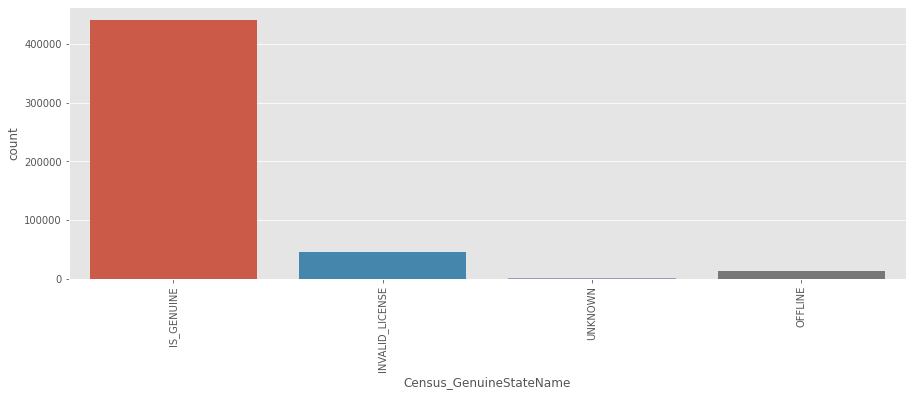

In [ ]:
descrp_cat(df_clean, 'Census_GenuineStateName', TARGET)

In [ ]:
df_clean = OHE('Census_GenuineStateName', df_clean)

## Census_ActivationChannel

'VALUE COUNTS'

Census_ActivationChannel
Retail                            264932
OEM:DM                            191350
Volume:GVLK                        25109
OEM:NONSLP                         17943
Volume:MAK                           468
Retail:TB:Eval                       198

'NULOS'

0

'DESCRIBE'

Census_ActivationChannel
count                    500000
unique                        6
top                      Retail
freq                     264932

'CROSSTAB'

HasDetections                  0       1
Census_ActivationChannel                
OEM:DM                     96470   94880
OEM:NONSLP                  8629    9314
Retail                    134400  130532
Retail:TB:Eval               146      52
Volume:GVLK                10146   14963
Volume:MAK                   256     212

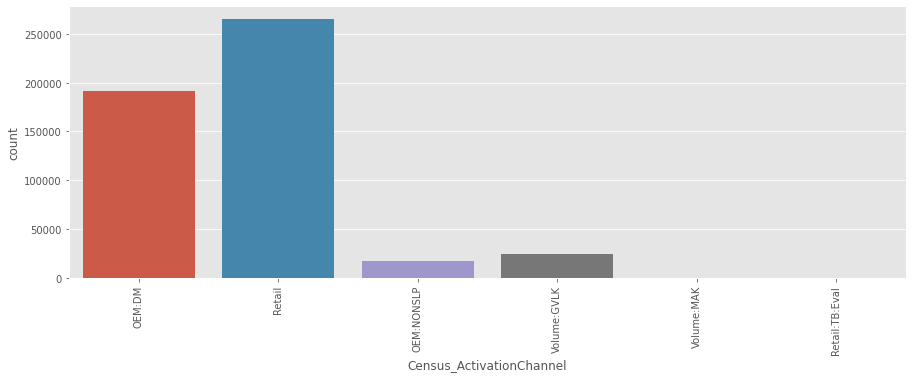

In [ ]:
descrp_cat(df_clean, 'Census_ActivationChannel', TARGET)

In [ ]:
df_clean = OHE('Census_ActivationChannel', df_clean)

## Census_FlightRing




'VALUE COUNTS'

Census_FlightRing
Retail               468299
NOT_SET               16044
Unknown               13701
WIS                     606
RP                      583
WIF                     549
Disabled                217
OSG                       1

'NULOS'

0

'DESCRIBE'

Census_FlightRing
count             500000
unique                 8
top               Retail
freq              468299

'CROSSTAB'

HasDetections           0       1
Census_FlightRing                
Disabled              117     100
NOT_SET              8064    7980
OSG                     1       0
RP                    284     299
Retail             233606  234693
Unknown              7323    6378
WIF                   296     253
WIS                   356     250

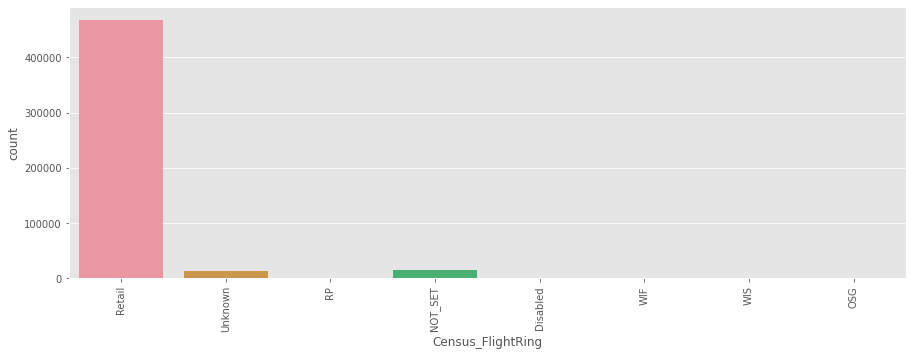

In [ ]:
descrp_cat(df_clean, 'Census_FlightRing', TARGET)

In [ ]:
df_clean = OHE('Census_FlightRing', df_clean)

# 4. Modelling

#Nueva Copia para entrenar al Modelo

In [ ]:
df_model = df_clean.copy()

In [ ]:
df_model.set_index('MachineIdentifier', inplace = True)
df_model.head()

RtpStateBitfield  ...  Census_FlightRing_WIS
MachineIdentifier                                   ...                       
f1cd864e97bae82bdf96523e1a539121               7.0  ...                      0
f045ba8adeb047ad57e477f413465428               7.0  ...                      0
77b631464f8cea84272190b77e9412bb               7.0  ...                      0
40145ca0d172feec790ff99f33439111               7.0  ...                      0
7f497d8907751e5870a855d84bdfd280               7.0  ...                      0

[5 rows x 192 columns]

In [ ]:
df_model.shape

(500000, 192)

# Separamos Development y Validation

In [ ]:
table =df_model.pivot_table(index= ['Platform_Id', 'EngineVersion_Index'], values = TARGET, aggfunc=[len, np.sum, np.mean])

In [ ]:
table

len           sum          mean
                                HasDetections HasDetections HasDetections
Platform_Id EngineVersion_Index                                          
0           1                               3             2      0.666667
            2                               7             4      0.571429
            3                               1             1      1.000000
            4                               2             1      0.500000
            5                               1             0      0.000000
...                                       ...           ...           ...
3           48                            396           141      0.356061
            49                           4856          2884      0.593904
            50                           4260          2092      0.491080
            51                              2             1      0.500000
            52                             76            35      0.460526

[121 rows x 3 columns]

Para poder visualizar correctamente exporto a un Excel.

In [ ]:
#from google.colab import files
#table.to_excel('pivot_table.xlsx')
#files.download('pivot_table.xlsx')

In [ ]:
df_val=df_model[(df_model['Platform_Id']==0) & (df_model['EngineVersion_Index']<=37)]

In [ ]:
df_val.shape

(18018, 192)

In [ ]:
df_model= df_model.drop(df_val.index,0)

In [ ]:
df_model.shape

(481982, 192)

In [ ]:
df_val_X= df_val.drop(TARGET, axis= 1)
df_val_y= df_val[[TARGET]]

df_model_X= df_model.drop(TARGET, axis= 1)
df_model_y= df_model[[TARGET]]

# Train y Test

In [ ]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(
    df_model_X,
    df_model_y,
    random_state = 42,
    test_size= 0.2
)

In [ ]:
df_model_X.shape

(481982, 191)

In [ ]:
X_train.shape

(385585, 191)

In [ ]:
X_test.shape

(96397, 191)

#Modelo 1
- max_depth= 4 
-   min_samples_leaf=100
-    random_state=42


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
first_model= DecisionTreeClassifier( 
    max_depth= 4, 
    min_samples_leaf=100,
    random_state=42)


## Entrenar el modelo 1

In [ ]:
%%time
first_model.fit(X_train, y_train)

CPU times: user 6.57 s, sys: 605 ms, total: 7.18 s
Wall time: 7.13 s


DecisionTreeClassifier(max_depth=4, min_samples_leaf=100, random_state=42)

# Función para graficar Decision Tree

In [ ]:
def graph_dtree(model,no_target_name, target_name):
  text_tree = export_graphviz(
    decision_tree=model,
    out_file=None,
    feature_names=X_train.columns,
    class_names=[no_target_name, target_name],
    filled= True,
    impurity=True,
    proportion=True,
    rotate=False,
    rounded=True,
    precision=3,
  

)
  
  plt.figure(figsize=(10,15))
  return display(graphviz.Source(text_tree))

## DecisionTree

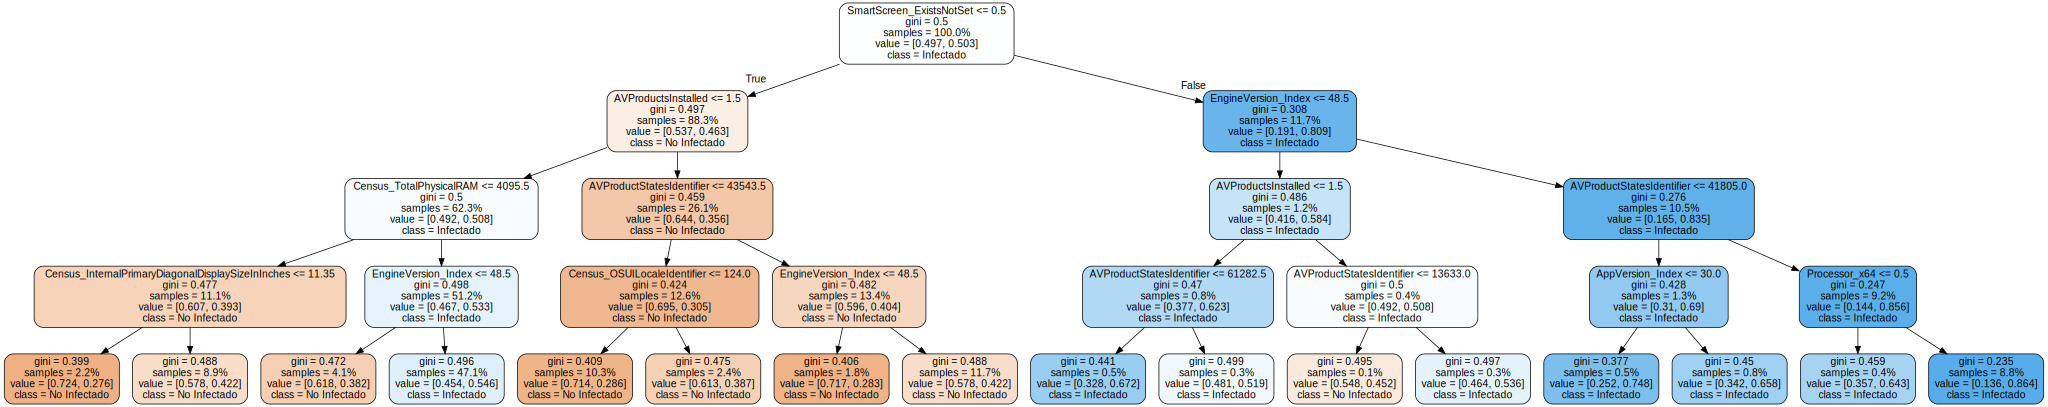

<Figure size 720x1080 with 0 Axes>

In [ ]:
graph_dtree(first_model, 'No Infectado', 'Infectado')

In [ ]:
test_prediction = pd.DataFrame(
                  first_model.predict(X_test),index = y_test.index, columns = ['Prediccion'])
test_prediction.head()
test_prediction.shape

(96397, 1)

In [ ]:
y_test.shape

(96397, 1)

In [ ]:
results_df= y_test.join(test_prediction)
results_df

HasDetections  Prediccion
MachineIdentifier                                          
7343bdbed6466ca75bc8e8624cf68ddc              1           1
93316f441341bab30a2e9fa79e1abafc              1           1
85e36aa0050cd598176c8baa36ce864a              1           0
bf6e4b1b764cbaf9eeca80446d032848              1           1
83fa5ac6e4b9de60f5da582e448343d4              0           0
...                                         ...         ...
c9bee465628228b625746048babc7c43              0           0
8828848774a98ff42c8bbf52aca2a612              0           0
840111fbf3d3252a28cab589194a0f98              1           1
a4c732c630fb4d65a9014c31058d2566              0           1
37e1de39aad676dc19a22363d872f05b              1           0

[96397 rows x 2 columns]

# Metricas de Evaluación

## Confusion Matrix

In [ ]:
confusion_matrix =pd.crosstab(results_df[TARGET],results_df['Prediccion'])
confusion_matrix

Prediccion         0      1
HasDetections              
0              25127  22850
1              14555  33865

## Accuracy

In [ ]:
first_model.score(X_test,y_test)

0.6119692521551501

In [ ]:
acc_1 =first_model.score(X_test,y_test)

## Curva ROC y AUC

In [ ]:
y_score= pd.DataFrame(first_model.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

In [ ]:
metrics.roc_auc_score(y_test,y_score)

0.6530039062845384

In [ ]:
auc_1 = metrics.roc_auc_score(y_test,y_score)

In [ ]:
y_score.head()

Prediccion_Score
MachineIdentifier                                 
7343bdbed6466ca75bc8e8624cf68ddc          0.545698
93316f441341bab30a2e9fa79e1abafc          0.545698
85e36aa0050cd598176c8baa36ce864a          0.422392
bf6e4b1b764cbaf9eeca80446d032848          0.545698
83fa5ac6e4b9de60f5da582e448343d4          0.387196

In [ ]:
metrics.roc_curve(y_test, y_score)

(array([0.        , 0.02346958, 0.02547054, 0.02913896, 0.03493341,
        0.03735123, 0.4712258 , 0.47399796, 0.47626988, 0.47752048,
        0.61291869, 0.71648915, 0.74562811, 0.7977781 , 0.94309773,
        0.96765117, 1.        ]),
 array([0.        , 0.15241636, 0.15983065, 0.16670797, 0.17771582,
        0.18248658, 0.69357703, 0.69708798, 0.69940107, 0.70047501,
        0.79576621, 0.86955803, 0.88808344, 0.92001239, 0.97734407,
        0.98795952, 1.        ]),
 array([1.86433035, 0.86433035, 0.74835886, 0.67226891, 0.65777369,
        0.64275568, 0.54569805, 0.53592233, 0.51909185, 0.45238095,
        0.42239237, 0.42182891, 0.38719613, 0.38229566, 0.28616828,
        0.28327444, 0.27575184]))

In [ ]:
fpr, tpr, th = metrics.roc_curve(y_test, y_score)

In [ ]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

Text(0, 0.5, 'TPR')

# Vamos a ver donde hace Overfit

In [ ]:
train_scores, test_scores = list(), list()

In [ ]:
valores = [i for i in range(1, 17)]

In [ ]:
%%time
for i in valores:
  dt_overfit = DecisionTreeClassifier(max_depth=i, min_samples_leaf=100, random_state=42)
  dt_overfit.fit(X_train,y_train)
  acc_train_overfit =dt_overfit.score(X_train,y_train)
  train_scores.append(acc_train_overfit) 
  acc_test_overfit =dt_overfit.score(X_test,y_test)
  test_scores.append(acc_test_overfit)
  print(f'MaxDepth= {i}, Train acc:{np.round(acc_train_overfit,4)}, Test acc:{np.round(acc_test_overfit,4)}') 

MaxDepth= 1, Train acc:0.5688, Test acc:0.5711
MaxDepth= 2, Train acc:0.5784, Test acc:0.5774
MaxDepth= 3, Train acc:0.6021, Test acc:0.602
MaxDepth= 4, Train acc:0.612, Test acc:0.612
MaxDepth= 5, Train acc:0.6124, Test acc:0.6119
MaxDepth= 6, Train acc:0.6168, Test acc:0.6162
MaxDepth= 7, Train acc:0.6186, Test acc:0.6171
MaxDepth= 8, Train acc:0.6242, Test acc:0.6223
MaxDepth= 9, Train acc:0.6294, Test acc:0.6259
MaxDepth= 10, Train acc:0.6321, Test acc:0.6277
MaxDepth= 11, Train acc:0.6358, Test acc:0.6294
MaxDepth= 12, Train acc:0.6403, Test acc:0.6298
MaxDepth= 13, Train acc:0.6433, Test acc:0.6293
MaxDepth= 14, Train acc:0.6467, Test acc:0.6286
MaxDepth= 15, Train acc:0.6499, Test acc:0.6287
MaxDepth= 16, Train acc:0.6532, Test acc:0.6272
CPU times: user 3min 43s, sys: 360 ms, total: 3min 43s
Wall time: 3min 42s


In [ ]:
from matplotlib import pyplot

In [ ]:
plt.figure(figsize=(15,5))

pyplot.plot(valores, train_scores, '-o', label='Train')
pyplot.plot(valores, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

## Conclusion:
A partir de max depth 6 empieza a haber overfitting.

# Modelo 2
- max_depth= 5 
-    min_samples_leaf=100
-    random_state=42

In [ ]:
#Modelo
model2= DecisionTreeClassifier( 
    max_depth= 5, 
    min_samples_leaf=100,
    random_state=42)

# Entrenamos el modelo

model2.fit(X_train, y_train)

#Prediccion
test_prediction2 = pd.DataFrame(
                  model2.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df2= y_test.join(test_prediction2)


In [ ]:
results_df2

HasDetections  Prediccion
MachineIdentifier                                          
7343bdbed6466ca75bc8e8624cf68ddc              1           1
93316f441341bab30a2e9fa79e1abafc              1           1
85e36aa0050cd598176c8baa36ce864a              1           0
bf6e4b1b764cbaf9eeca80446d032848              1           1
83fa5ac6e4b9de60f5da582e448343d4              0           0
...                                         ...         ...
c9bee465628228b625746048babc7c43              0           0
8828848774a98ff42c8bbf52aca2a612              0           0
840111fbf3d3252a28cab589194a0f98              1           1
a4c732c630fb4d65a9014c31058d2566              0           1
37e1de39aad676dc19a22363d872f05b              1           0

[96397 rows x 2 columns]

In [ ]:
#Confusino Matrix
confusion_matrix_2 =pd.crosstab(results_df2[TARGET],results_df2['Prediccion'])
confusion_matrix_2

Prediccion         0      1
HasDetections              
0              24680  23297
1              14110  34310

In [ ]:
# Accuracy
acc_2 = model2.score(X_test,y_test)
acc_2

0.6119485046215131

In [ ]:
# ROC y AUC
y_score= pd.DataFrame(model2.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_2 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)

In [ ]:
auc_2

0.6650457829437875

Text(0, 0.5, 'TPR')

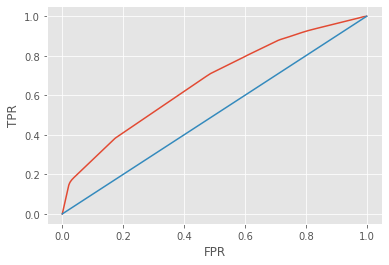

In [ ]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

#Modelo 3
- max_depth= 3 
-    min_samples_leaf=100
-    random_state=42

max depth = 3

In [ ]:
#Modelo
model3= DecisionTreeClassifier( 
    max_depth= 3, 
    min_samples_leaf=100,
    random_state=42)

# Entrenamos el modelo

model3.fit(X_train, y_train)

#Prediccion
test_prediction3 = pd.DataFrame(
                  model3.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df3= y_test.join(test_prediction3)

#Confusino Matrix
confusion_matrix_3 =pd.crosstab(results_df3[TARGET],results_df3['Prediccion'])

# Accuracy
acc_3 = model3.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(model3.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_3 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_3)
print('Acc_3:', acc_3)
print('AUC_3:',auc_3)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

Confusion Matrix Prediccion         0      1
HasDetections              
0              22565  25412
1              12957  35463
Acc_3: 0.6019689409421455
AUC_3: 0.6423533701441357


Text(0, 0.5, 'TPR')

# Modelo 4
- criterion= 'entropy' 
-    max_depth= 4 
-    min_samples_leaf=100
-    random_state=42

Confusion Matrix Prediccion         0      1
HasDetections              
0              22565  25412
1              12957  35463
Acc_4: 0.6119692521551501
AUC_4: 0.6530101760690663


Text(0, 0.5, 'TPR')

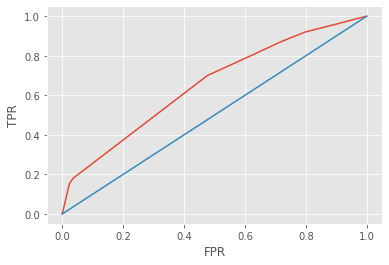

In [ ]:
#Modelo
model4= DecisionTreeClassifier(
    criterion= 'entropy', 
    max_depth= 4, 
    min_samples_leaf=100,
    random_state=42)

# Entrenamos el modelo

model4.fit(X_train, y_train)

#Prediccion
test_prediction4 = pd.DataFrame(
                  model4.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df4= y_test.join(test_prediction4)

#Confusino Matrix
confusion_matrix_4 =pd.crosstab(results_df4[TARGET],results_df4['Prediccion'])

# Accuracy
acc_4 = model4.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(model4.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_4 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_3)
print('Acc_4:', acc_4)
print('AUC_4:',auc_4)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

# Modelo 5
- max_depth = 5
- min_samples_leaf=150 
- random_state=1

In [ ]:
#Modelo
model5= DecisionTreeClassifier( 
    max_depth= 5, 
    min_samples_leaf=150,
    random_state=1)

# Entrenamos el modelo

model5.fit(X_train, y_train)

#Prediccion
test_prediction5 = pd.DataFrame(
                  model5.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df5= y_test.join(test_prediction5)

#Confusino Matrix
confusion_matrix_5 =pd.crosstab(results_df5[TARGET],results_df5['Prediccion'])

# Accuracy
acc_5 = model5.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(model5.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_5 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_3)
print('Acc_5:', acc_5)
print('AUC_5:',auc_5)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

Confusion Matrix Prediccion         0      1
HasDetections              
0              22565  25412
1              12957  35463
Acc_5: 0.6119485046215131
AUC_5: 0.6650402546425311


Text(0, 0.5, 'TPR')

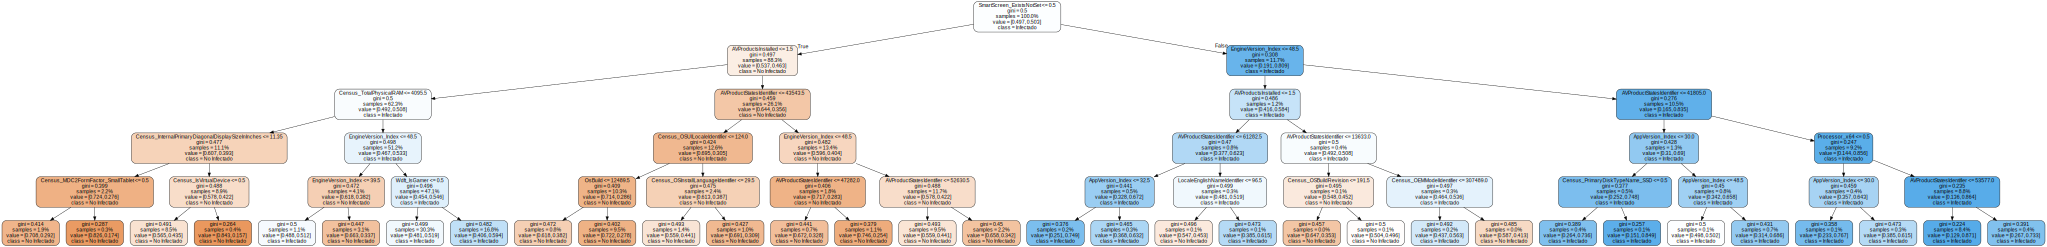

<Figure size 720x1080 with 0 Axes>

In [ ]:
graph_dtree(model5, 'No Infectado', 'Infectado')

# Modelo 6
- max_depth = 5 
- min_samples_leaf = 60
-  random_state = 11

Confusion Matrix Prediccion         0      1
HasDetections              
0              22565  25412
1              12957  35463
Acc_6: 0.6119485046215131
AUC_6: 0.6650474497206973


Text(0, 0.5, 'TPR')

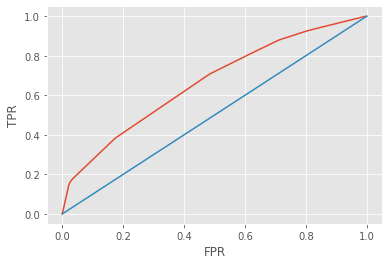

In [ ]:
#Modelo
model6= DecisionTreeClassifier( 
    max_depth= 5, 
    min_samples_leaf=60,
    random_state=11)

# Entrenamos el modelo

model6.fit(X_train, y_train)

#Prediccion
test_prediction6 = pd.DataFrame(
                  model6.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df6= y_test.join(test_prediction6)

#Confusino Matrix
confusion_matrix_6 =pd.crosstab(results_df6[TARGET],results_df6['Prediccion'])

# Accuracy
acc_6 = model6.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(model6.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_6 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_3)
print('Acc_6:', acc_6)
print('AUC_6:',auc_6)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

# Resumen de los Modelos

In [ ]:
modelos = ['Modelo_1', 
           'Modelo_2',
           'Modelo_3',
           'Modelo_4',
           'Modelo_5',
           'Modelo_6'
           ]

In [ ]:
acc_all = [acc_1,acc_2,acc_3,acc_4,acc_5,acc_6]

In [ ]:
auc_all =[auc_1,auc_2,auc_3,auc_4,auc_5,auc_6]

In [ ]:
df_modelos_all = pd.DataFrame({'Acc':acc_all,'AUC': auc_all}, index= modelos)
df_modelos_all.round(4)

Acc     AUC
Modelo_1  0.6120  0.6530
Modelo_2  0.6119  0.6650
Modelo_3  0.6020  0.6424
Modelo_4  0.6120  0.6530
Modelo_5  0.6119  0.6650
Modelo_6  0.6119  0.6650

# DF con variables modificadas

In [ ]:
import plotly.express as px 

## Extraemos las variables más importantes y las graficamos

In [ ]:
feature_names = model5.feature_names_in_
feature_importances = model5.feature_importances_

In [ ]:
df_tb=pd.DataFrame({'variables':feature_names,'importancia':feature_importances}).sort_values(by='importancia', ascending = True).tail(20)


In [ ]:
fig = px.bar(df_tb, 
             x="importancia", y="variables", title='Variables más importantes', text='importancia', orientation='h', 
             width=700, height=700, range_x = [0, max(df_tb['importancia'])+.15])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')

##Creamos una lista para poder separar y crear un nuevo dataframe con este slice

In [ ]:
df_names_ = df_tb['variables'].values.tolist()
df_names_

['OsPlatformSubRelease_windows7',
 'SmartScreen_Off',
 'Census_OSBuildRevision',
 'Census_PrimaryDiskTypeName_SSD',
 'Census_OEMModelIdentifier',
 'LocaleEnglishNameIdentifier',
 'Census_MDC2FormFactor_SmallTablet',
 'OsBuild',
 'AppVersion_Index',
 'Census_OSInstallLanguageIdentifier',
 'Processor_x64',
 'Census_OSUILocaleIdentifier',
 'Census_IsVirtualDevice',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Wdft_IsGamer',
 'AVProductStatesIdentifier',
 'Census_TotalPhysicalRAM',
 'EngineVersion_Index',
 'AVProductsInstalled',
 'SmartScreen_ExistsNotSet']

In [ ]:
df_names_.append('HasDetections')

In [ ]:
df_names_.append('Platform_Id')

##Copiamos el df y hacemos un slice con las variables más representativas

In [ ]:
df_slice = df_clean.copy()

In [ ]:
df_slice = df_slice[df_names_]

##Separamos entre dev y validation, usamos el mismo criterio de los modelos anteriores 

In [ ]:
table =df_slice.pivot_table(index= ['Platform_Id', 'EngineVersion_Index'], values = TARGET, aggfunc=[len, np.sum, np.mean])

In [ ]:
df_val=df_slice[(df_slice['Platform_Id']==0) & (df_slice['EngineVersion_Index']<=37)]

In [ ]:
df_slice= df_slice.drop(df_val.index,0)

In [ ]:
df_slice.shape

(481982, 22)

In [ ]:
df_val.shape

(18018, 22)

## Validation y Development

In [ ]:
df_val_X= df_val.drop(TARGET, axis= 1)
df_val_y= df_val[[TARGET]]

df_dev_X= df_slice.drop(TARGET, axis= 1)
df_dev_y= df_slice[[TARGET]]

In [ ]:
df_dev_X.shape

(481982, 21)

## Entrenamos el modelo y ejecutamos

In [ ]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(
    df_dev_X,
    df_dev_y,
    random_state = 42,
    test_size= 0.2
)

#Modelo 2.1
- max_depth =4
- random state = 42

Confusion Matrix Prediccion         0      1
HasDetections              
0              25127  22850
1              14555  33865
Acc_tb: 0.6119692521551501
AUC_tb: 0.6530039062845384


Text(0, 0.5, 'TPR')

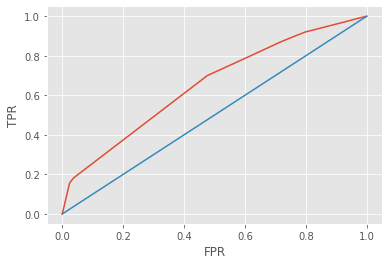

In [ ]:
#Modelo
modeltb= DecisionTreeClassifier( 
    max_depth= 4, 
    random_state=42)

#Entrenamos el modelo
modeltb.fit(X_train,y_train)

#Prediccion
test_prediction_tb = pd.DataFrame(
                  modeltb.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df= y_test.join(test_prediction_tb)

#Confusino Matrix
confusion_matrix_ =pd.crosstab(results_df[TARGET],results_df['Prediccion'])

# Accuracy
acc_tb21 = modeltb.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(modeltb.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_tb21 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_)
print('Acc_tb:', acc_tb21)
print('AUC_tb:',auc_tb21)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

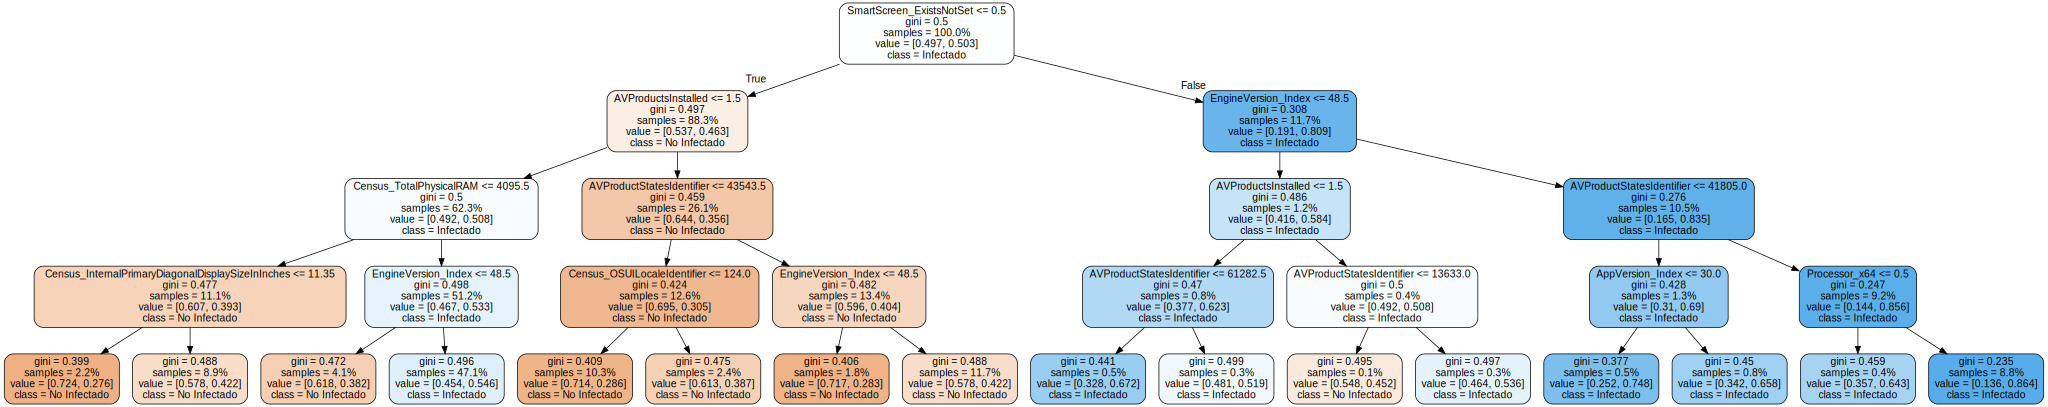

<Figure size 720x1080 with 0 Axes>

In [ ]:
graph_dtree(modeltb, 'No Infectado', 'Infectado')

# Analizamos el Overfit

In [ ]:
train_scores, test_scores = list(), list()
valores = [i for i in range(1, 11)]
for i in valores:
  dt_overfit = DecisionTreeClassifier(max_depth=i, random_state=42)
  dt_overfit.fit(X_train,y_train)
  acc_train_overfit =dt_overfit.score(X_train,y_train)
  train_scores.append(acc_train_overfit) 
  acc_test_overfit =dt_overfit.score(X_test,y_test)
  test_scores.append(acc_test_overfit)
  print(f'MaxDepth= {i}, Train acc:{np.round(acc_train_overfit,4)}, Test acc:{np.round(acc_test_overfit,4)}') 

MaxDepth= 1, Train acc:0.5688, Test acc:0.5711
MaxDepth= 2, Train acc:0.5784, Test acc:0.5774
MaxDepth= 3, Train acc:0.6021, Test acc:0.602
MaxDepth= 4, Train acc:0.612, Test acc:0.612
MaxDepth= 5, Train acc:0.6124, Test acc:0.6119
MaxDepth= 6, Train acc:0.6178, Test acc:0.6177
MaxDepth= 7, Train acc:0.6197, Test acc:0.6191
MaxDepth= 8, Train acc:0.6241, Test acc:0.6239
MaxDepth= 9, Train acc:0.6278, Test acc:0.6248
MaxDepth= 10, Train acc:0.6309, Test acc:0.6248


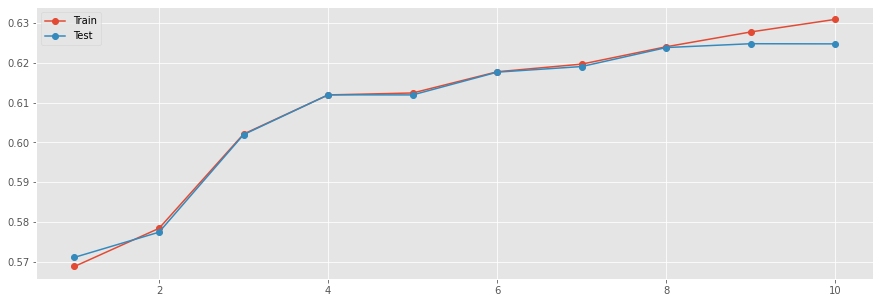

In [ ]:
plt.figure(figsize=(15,5))

pyplot.plot(valores, train_scores, '-o', label='Train')
pyplot.plot(valores, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

# Modelo 2.2
- max_depth = 5
- random_state = 42

Confusion Matrix Prediccion         0      1
HasDetections              
0              24680  23297
1              14110  34310
Acc_tb: 0.6119485046215131
AUC_tb: 0.6650536827001049


Text(0, 0.5, 'TPR')

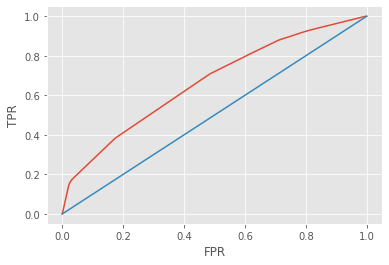

In [ ]:
#Modelo
modeltb= DecisionTreeClassifier( 
    max_depth= 5, 
    random_state=90)

#Entrenamos el modelo
modeltb.fit(X_train,y_train)

#Prediccion
test_prediction_tb = pd.DataFrame(
                  modeltb.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df= y_test.join(test_prediction_tb)

#Confusino Matrix
confusion_matrix_ =pd.crosstab(results_df[TARGET],results_df['Prediccion'])

# Accuracy
acc_tb22 = modeltb.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(modeltb.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_tb22 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_)
print('Acc_tb:', acc_tb22)
print('AUC_tb:',auc_tb22)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

#Modelo 2.3
- max_depth = 6
- random_state = 110

Confusion Matrix Prediccion         0      1
HasDetections              
0              26891  21086
1              15769  32651
Acc_tb: 0.6176748239053083
AUC_tb: 0.6710857879399857


Text(0, 0.5, 'TPR')

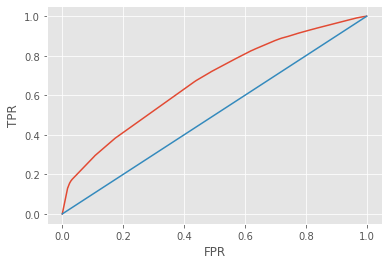

In [ ]:
#Modelo
modeltb= DecisionTreeClassifier( 
    max_depth= 6, 
    random_state=110)

#Entrenamos el modelo
modeltb.fit(X_train,y_train)

#Prediccion
test_prediction_tb = pd.DataFrame(
                  modeltb.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df= y_test.join(test_prediction_tb)

#Confusino Matrix
confusion_matrix_ =pd.crosstab(results_df[TARGET],results_df['Prediccion'])

# Accuracy
acc_tb23 = modeltb.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(modeltb.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_tb23 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_)
print('Acc_tb:', acc_tb23)
print('AUC_tb:',auc_tb23)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

# Modelo 2.4
- max_depth = 7
- random_state = 42

Confusion Matrix Prediccion         0      1
HasDetections              
0              26227  21750
1              14969  33451
Acc_tb: 0.6190856561926201
AUC_tb: 0.6758616382142425


Text(0, 0.5, 'TPR')

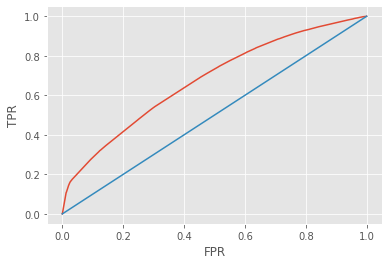

In [ ]:
#Modelo
modeltb= DecisionTreeClassifier( 
    max_depth= 7, 
    random_state=42)

#Entrenamos el modelo
modeltb.fit(X_train,y_train)

#Prediccion
test_prediction_tb = pd.DataFrame(
                  modeltb.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df= y_test.join(test_prediction_tb)

#Confusino Matrix
confusion_matrix_ =pd.crosstab(results_df[TARGET],results_df['Prediccion'])

# Accuracy
acc_tb24 = modeltb.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(modeltb.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_tb24 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_)
print('Acc_tb:', acc_tb24)
print('AUC_tb:',auc_tb24)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

#Modelo 2.5
  - max_depth = 8
  - random_state = 42

Confusion Matrix Prediccion         0      1
HasDetections              
0              29417  18560
1              17699  30721
Acc_tb: 0.623857588929116
AUC_tb: 0.6789116326883087


Text(0, 0.5, 'TPR')

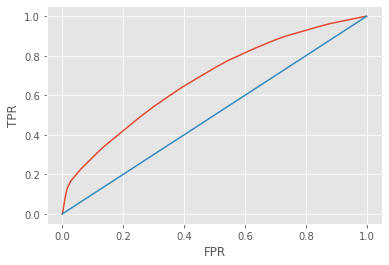

In [ ]:
#Modelo
modeltb5= DecisionTreeClassifier( 
    max_depth= 8, 
    random_state=42)

#Entrenamos el modelo
modeltb5.fit(X_train,y_train)

#Prediccion
test_prediction_tb5 = pd.DataFrame(
                  modeltb5.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df5= y_test.join(test_prediction_tb5)

#Confusino Matrix
confusion_matrix_ =pd.crosstab(results_df5[TARGET],results_df5['Prediccion'])

# Accuracy
acc_tb25 = modeltb5.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(modeltb5.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_tb25 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_)
print('Acc_tb:', acc_tb25)
print('AUC_tb:',auc_tb25)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

# Modelo 2.6
- max_depth =8
- random_state = 12

Confusion Matrix Prediccion         0      1
HasDetections              
0              29417  18560
1              17702  30718
Acc_tb: 0.6238264676286607
AUC_tb: 0.6788654794979252


Text(0, 0.5, 'TPR')

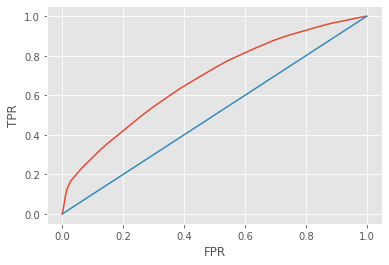

In [ ]:
#Modelo
modeltb= DecisionTreeClassifier( 
    max_depth= 8, 
    random_state=12)

#Entrenamos el modelo
modeltb.fit(X_train,y_train)

#Prediccion
test_prediction_tb = pd.DataFrame(
                  modeltb.predict(X_test),index = y_test.index, columns = ['Prediccion'])

results_df= y_test.join(test_prediction_tb)

#Confusino Matrix
confusion_matrix_ =pd.crosstab(results_df[TARGET],results_df['Prediccion'])

# Accuracy
acc_tb26 = modeltb.score(X_test,y_test)

# ROC y AUC
y_score= pd.DataFrame(modeltb.predict_proba(X_test)[:,1],index = y_test.index, columns = ['Prediccion_Score'])

# AUC
auc_tb26 = metrics.roc_auc_score(y_test,y_score)

#Array 
fpr, tpr, th = metrics.roc_curve(y_test, y_score)



print('Confusion Matrix', confusion_matrix_)
print('Acc_tb:', acc_tb26)
print('AUC_tb:',auc_tb26)

#Plot
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

#Resumen Modelos 2

In [ ]:
modelos = ['Modelo_1', 
           'Modelo_2',
           'Modelo_3',
           'Modelo_4',
           'Modelo_5',
           'Modelo_6'
           ]

acc_all2 = [acc_tb21,acc_tb22,acc_tb23,acc_tb24,acc_tb25,acc_tb26]
auc_all2 =[auc_tb21,auc_tb22,auc_tb23,auc_tb24,auc_tb25,auc_tb26]

df_modelos_all2 = pd.DataFrame({'Acc_tb':acc_all2,'AUC_tb': auc_all2}, index= modelos)
df_modelos_all2.round(4)

Acc_tb  AUC_tb
Modelo_1  0.6120  0.6530
Modelo_2  0.6119  0.6651
Modelo_3  0.6177  0.6711
Modelo_4  0.6191  0.6759
Modelo_5  0.6239  0.6789
Modelo_6  0.6238  0.6789

#Resumen todos los modelos

In [ ]:
pd.concat([df_modelos_all,df_modelos_all2], axis =1).round(4)*100

Acc    AUC  Acc_tb  AUC_tb
Modelo_1  61.20  65.30   61.20   65.30
Modelo_2  61.19  66.50   61.19   66.51
Modelo_3  60.20  64.24   61.77   67.11
Modelo_4  61.20  65.30   61.91   67.59
Modelo_5  61.19  66.50   62.39   67.89
Modelo_6  61.19  66.50   62.38   67.89

## El modelo 5 de la segunda segmentación (tb) es el modelo que mejor predicción tiene, acá podemos ver si comportamiento:

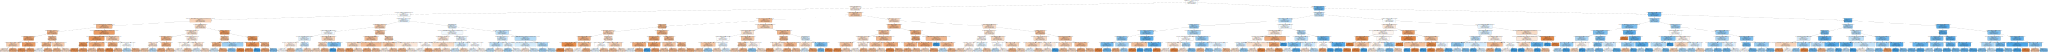

<Figure size 720x1080 with 0 Axes>

In [ ]:
graph_dtree(modeltb5,'No Infectado', 'Infectado')

In [ ]:
confusion_matrix_ =pd.crosstab(results_df5[TARGET],results_df5['Prediccion'])
confusion_matrix

Prediccion         0      1
HasDetections              
0              25127  22850
1              14555  33865